In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
p = sns.color_palette()

USE_SAMPLE = False
TRAIN_FACE = '../sample/train_face.txt' if USE_SAMPLE else '../data/train_face.txt'
TRAIN_USER_INTERACT = '../sample/train_interaction.txt' if USE_SAMPLE else '../data/train_interaction.txt'
TRAIN_TEXT = '../sample/train_text.txt' if USE_SAMPLE else '../data/train_text.txt'
TEST_FACE = '../sample/test_face.txt' if USE_SAMPLE else '../data/test_face.txt'
TEST_INTERACT = '../sample/test_interaction.txt' if USE_SAMPLE else '../data/test_interaction.txt'
TEST_TEXT = '../sample/test_text.txt' if USE_SAMPLE else '../data/test_text.txt'

In [123]:
import io
import json
model_metainfo = {
    'desc': "我的"
}
model_metainfo_file = 'info'

with io.open(model_metainfo_file, 'w', encoding='utf8') as outfile:
#     json.dump(model_metainfo, outfile, ensure_ascii=False, indent=4)
    metadata = json.dumps(model_metainfo, outfile, ensure_ascii=False, indent=4)
    outfile.write(metadata.decode('utf8'))


In [3]:
face_train = pd.read_csv(TRAIN_FACE, 
                        sep='\t', 
                        header=None, 
                        names=['photo_id', 'faces'])

In [4]:
user_item_train = pd.read_csv(TRAIN_USER_INTERACT, 
                             sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'click', 'like', 'follow', 'time', 'playing_time', 'duration_time'])

In [4]:
text_train = pd.read_csv(TRAIN_TEXT,
                       sep='\t',
                       header=None,
                       names=['photo_id', 'cover_words'])

In [5]:
face_test = pd.read_csv(TEST_FACE, 
                        sep='\t', 
                        header=None, 
                        names=['photo_id', 'faces'])

In [6]:
user_item_test = pd.read_csv(TEST_INTERACT, 
                             sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'time', 'duration_time'])

In [7]:
text_test = pd.read_csv(TEST_TEXT,
                       sep='\t',
                       header=None,
                       names=['photo_id', 'cover_words'])

In [7]:
user_item_train['click'].mean()

0.2024292396826292

In [8]:
user_item_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20854344 entries, 0 to 20854343
Data columns (total 8 columns):
user_id          int64
photo_id         int64
click            int64
like             int64
follow           int64
time             int64
playing_time     int64
duration_time    int64
dtypes: int64(8)
memory usage: 1.2 GB


In [9]:
user_item_train['duration_time'].describe()

count    2.085434e+07
mean     1.989893e+01
std      2.735497e+01
min      0.000000e+00
25%      1.100000e+01
50%      1.100000e+01
75%      1.700000e+01
max      3.831000e+03
Name: duration_time, dtype: float64

In [10]:
user_item_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3291332 entries, 0 to 3291331
Data columns (total 4 columns):
user_id          int64
photo_id         int64
time             int64
duration_time    int64
dtypes: int64(4)
memory usage: 100.4 MB


In [11]:
user_item_train['like'].mean()

0.003035866292413705

In [12]:
user_item_train['follow'].mean()

0.0009912563061202021

In [13]:
user_item_train['time'].describe()

count    2.085434e+07
mean     7.610647e+11
std      3.679046e+07
min      7.609949e+11
25%      7.610322e+11
50%      7.610669e+11
75%      7.610993e+11
max      7.611249e+11
Name: time, dtype: float64

In [14]:
user_item_test['time'].describe()

count    3.291332e+06
mean     7.611580e+11
std      7.654993e+06
min      7.611250e+11
25%      7.611531e+11
50%      7.611597e+11
75%      7.611641e+11
max      7.611681e+11
Name: time, dtype: float64

In [15]:
lower_train, higher_train = user_item_train['time'].min(), user_item_train['time'].max()
lower_test, higher_test = user_item_test['time'].min(), user_item_test['time'].max()

In [16]:
lower_train, higher_train

(760994920751, 761124883233)

In [17]:
lower_test, higher_test

(761124966356, 761168068776)

In [18]:
(761168068776 - 760994920751)/3600/1000

48

In [19]:
users_train = set(user_item_train['user_id'].unique())

In [20]:
users_test = set(user_item_test['user_id'].unique())

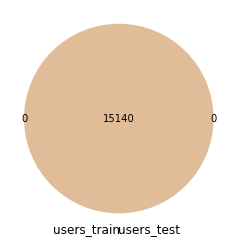

In [21]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(users_train), set(users_test)], ['users_train', 'users_test'])
plt.show()

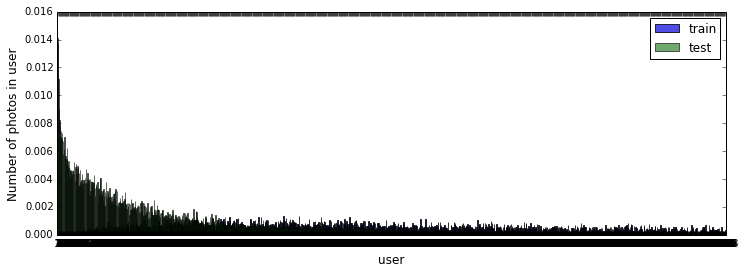

In [21]:
sizes_train = user_item_train.groupby('user_id')['photo_id'].count().value_counts()
sizes_test = user_item_test.groupby('user_id')['photo_id'].count().value_counts()
sizes_train = sizes_train / np.sum(sizes_train)
sizes_test = sizes_test / np.sum(sizes_test)

plt.figure(figsize=(12,4))
sns.barplot(sizes_train.index, sizes_train.values, alpha=0.8, color=p[0], label='train')
sns.barplot(sizes_test.index, sizes_test.values, alpha=0.6, color=p[1], label='test')
plt.legend()
plt.xlabel('user', fontsize=12)
plt.ylabel('Number of photos in user', fontsize=12)

In [22]:
photo_intersection_prop = 1. * len(set(user_item_train.photo_id.unique()) & set(user_item_test.photo_id.unique())) / len(user_item_test.photo_id.unique())

In [23]:
photo_intersection_prop

0.0

In [24]:
face_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1613135 entries, 0 to 1613134
Data columns (total 2 columns):
photo_id    1613135 non-null int64
faces       1613135 non-null object
dtypes: int64(1), object(1)
memory usage: 24.6+ MB


In [25]:
def add_face_feature(face_data):
    def ages_avg(lists):
        ages = [l[2] for l in lists if l[1] == 1]
        return reduce(ages, lambda x, y: x + y) / len(ages)
    face_data['faces'] = face_data['faces'].apply(eval)
    face_data['face_num'] = face_data['faces'].apply(lambda l : len(l))
    face_data['man_num'] = face_data['faces'].apply(lambda lists: len([1 for l in lists if l[1] == 1]))
    face_data['woman_num'] = face_data['faces'].apply(lambda lists: len([1 for l in lists if l[1] == 0]))
    face_data['man_scale'] = face_data['faces'].apply(lambda lists: sum([l[0] for l in lists if l[1] == 1]))
    face_data['woman_scale'] = face_data['faces'].apply(lambda lists: sum([l[0] for l in lists if l[1] == 0]))
    face_data['human_scale'] = face_data['man_scale'] + face_data['woman_scale']
    face_data['man_avg_age'] = face_data['faces'].apply(lambda lists: np.mean([l[2] for l in lists if l[1] == 1]))
    face_data['woman_avg_age'] = face_data['faces'].apply(lambda lists: np.mean([l[2] for l in lists if l[1] == 0]))
    face_data['human_avg_age'] = face_data['faces'].apply(lambda lists: np.mean([l[2] for l in lists]))
    face_data['man_avg_attr'] = face_data['faces'].apply(lambda lists: np.mean([l[3] for l in lists if l[1] == 1]))
    face_data['woman_avg_attr'] = face_data['faces'].apply(lambda lists: np.mean([l[3] for l in lists if l[1] == 0]))
    face_data['human_avg_attr'] = face_data['faces'].apply(lambda lists: np.mean([l[3] for l in lists]))
    return face_data

In [26]:
face_data = pd.concat([face_train, face_test])

In [27]:
face_tata = add_face_feature(face_data)

/Library/Python/2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [28]:
face_data.fillna(0, inplace=True)

In [29]:
face_data.head()

,photo_id,faces,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,9,"[[0.0377, 1, 3, 50]]",1,1,0,0.0377,0.0000,0.0377,3.0,0.0,3.0,50.0,0.0,50.0
1,3,"[[0.219, 0, 22, 66]]",1,0,1,0.0000,0.2190,0.2190,0.0,22.0,22.0,0.0,66.0,66.0
2,8,"[[0.0849, 0, 13, 54], [0.1221, 0, 22, 88]]",2,0,2,0.0000,0.2070,0.2070,0.0,17.5,17.5,0.0,71.0,71.0
3,2,"[[0.2018, 1, 18, 60]]",1,1,0,0.2018,0.0000,0.2018,18.0,0.0,18.0,60.0,0.0,60.0
4,19,"[[0.0123, 0, 24, 52]]",1,0,1,0.0000,0.0123,0.0123,0.0,24.0,24.0,0.0,52.0,52.0


In [30]:
face_data.drop(['faces'], axis=1, inplace=True)

In [31]:
face_data.head()

,photo_id,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,9,1,1,0,0.0377,0.0000,0.0377,3.0,0.0,3.0,50.0,0.0,50.0
1,3,1,0,1,0.0000,0.2190,0.2190,0.0,22.0,22.0,0.0,66.0,66.0
2,8,2,0,2,0.0000,0.2070,0.2070,0.0,17.5,17.5,0.0,71.0,71.0
3,2,1,1,0,0.2018,0.0000,0.2018,18.0,0.0,18.0,60.0,0.0,60.0
4,19,1,0,1,0.0000,0.0123,0.0123,0.0,24.0,24.0,0.0,52.0,52.0


In [32]:
np.sum(face_data['face_num']>=2)

311640

In [33]:
face_data.head()

,photo_id,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,9,1,1,0,0.0377,0.0000,0.0377,3.0,0.0,3.0,50.0,0.0,50.0
1,3,1,0,1,0.0000,0.2190,0.2190,0.0,22.0,22.0,0.0,66.0,66.0
2,8,2,0,2,0.0000,0.2070,0.2070,0.0,17.5,17.5,0.0,71.0,71.0
3,2,1,1,0,0.2018,0.0000,0.2018,18.0,0.0,18.0,60.0,0.0,60.0
4,19,1,0,1,0.0000,0.0123,0.0123,0.0,24.0,24.0,0.0,52.0,52.0


In [34]:
user_item_data = pd.concat([user_item_train[['user_id', 'photo_id', 'time', 'duration_time']], user_item_test])

photo_data = pd.DataFrame()
photo_data['photo_id'] = user_item_data['photo_id']
# photo_data['duration_time'] = user_item_data['duration_time']
photo_data['exposure_num'] = user_item_data['photo_id'].groupby(user_item_data['photo_id']).transform('count') 
photo_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24145676 entries, 0 to 3291331
Data columns (total 2 columns):
photo_id        int64
exposure_num    int64
dtypes: int64(2)
memory usage: 552.7 MB


In [35]:
photo_data.drop_duplicates(inplace=True)
photo_data = pd.merge(photo_data, face_data,
                 how="left",
                 on=['photo_id'])



In [36]:
photo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5174532 entries, 0 to 5174531
Data columns (total 14 columns):
photo_id          int64
exposure_num      int64
face_num          float64
man_num           float64
woman_num         float64
man_scale         float64
woman_scale       float64
human_scale       float64
man_avg_age       float64
woman_avg_age     float64
human_avg_age     float64
man_avg_attr      float64
woman_avg_attr    float64
human_avg_attr    float64
dtypes: float64(12), int64(2)
memory usage: 592.2 MB


In [37]:
photo_data.fillna(0, inplace=True)


In [38]:
photo_data.head(10)

,photo_id,exposure_num,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,6484142,13,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,4647664,2,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,4994626,34,3.0,3.0,0.0,0.3959,0.0000,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333
3,4416881,1,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,2597756,2,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
5,4977481,155,3.0,3.0,0.0,0.0103,0.0000,0.0103,27.000000,0.0,27.000000,51.666667,0.0,51.666667
6,5089000,852,1.0,0.0,1.0,0.0000,0.0384,0.0384,0.000000,22.0,22.000000,0.000000,84.0,84.000000
7,693195,55,2.0,1.0,1.0,0.0162,0.0094,0.0256,27.000000,27.0,27.000000,50.000000,51.0,50.500000
8,163901,265,2.0,1.0,1.0,0.0088,0.0104,0.0192,21.000000,27.0,24.000000,56.000000,48.0,52.000000
9,6472236,1,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [39]:
photo_data[photo_data['photo_id'] == 4647664]

,photo_id,exposure_num,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
1,4647664,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
np.sum(photo_data['face_num']>=1)

1942191

(0, 20)


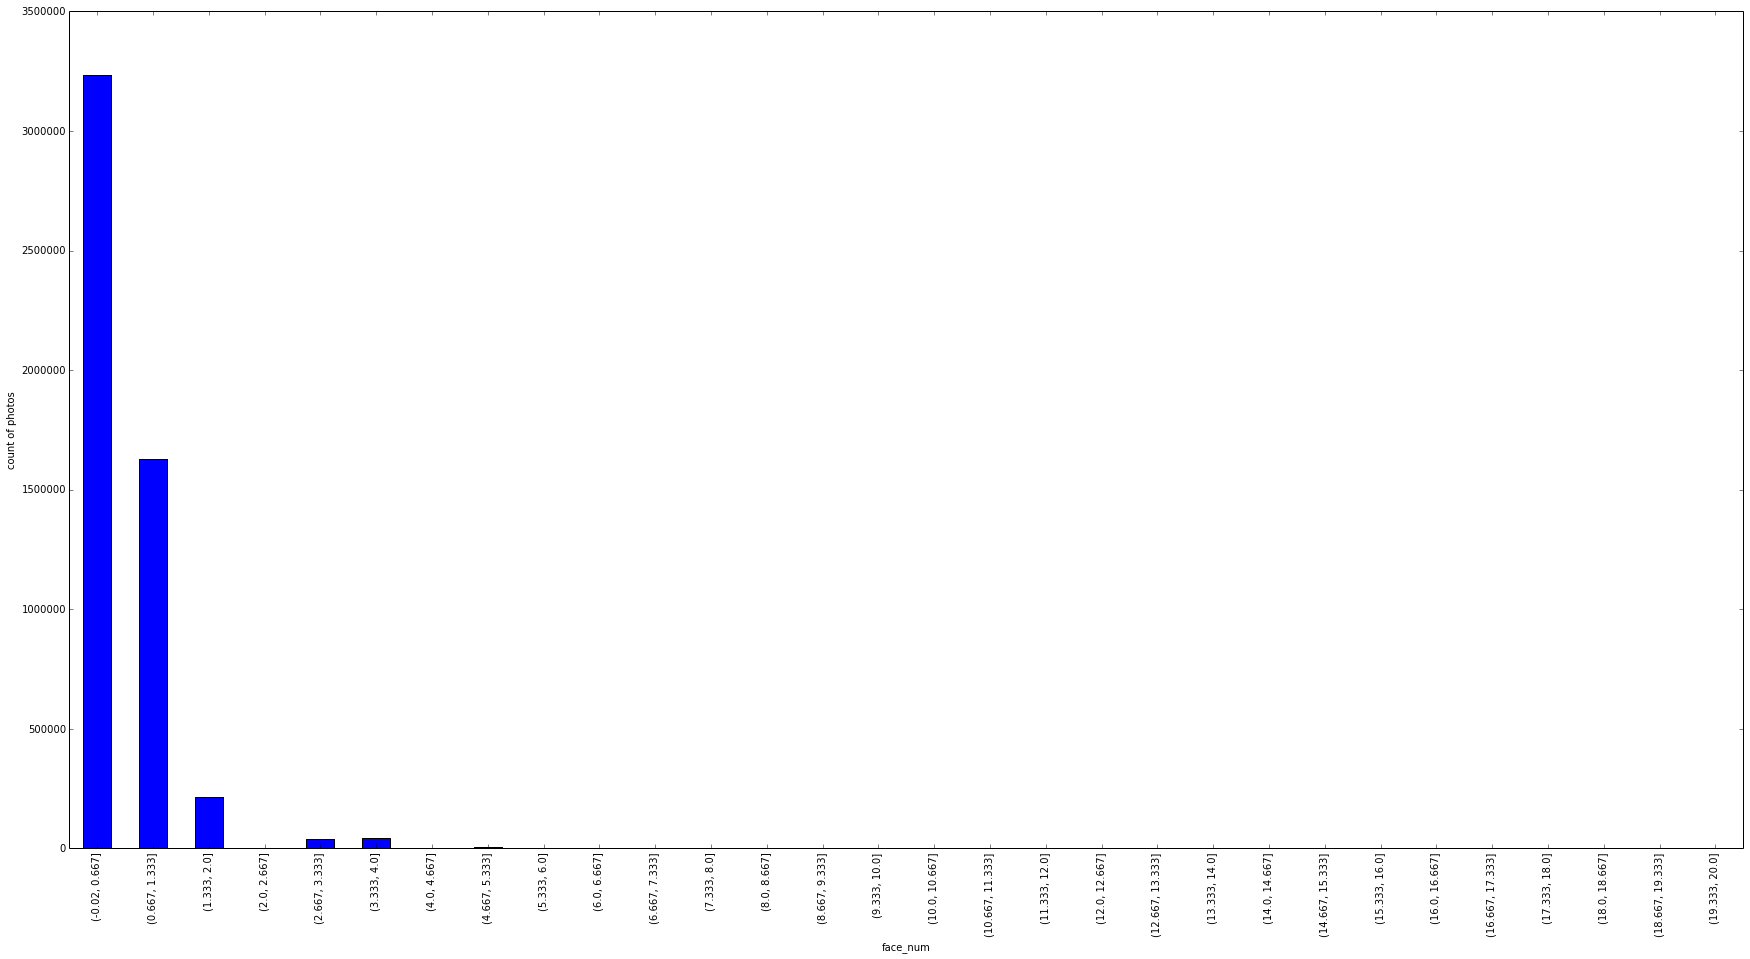

In [41]:
lower, higher = int(photo_data.face_num.min()), int(photo_data.face_num.max())
print(lower, higher)
n_bins = 10
# edges = range(lower, higher+1, (higher-lower)/n_bins)
# lbs = ['[%d, %d)'%(edges[i], edges[i+1]) for i in range(len(edges))]
# quartiles = pd.cut(photo_data.face_num, bins=n_bins, labels=lbs, include_lowest=True)
quartiles = pd.cut(photo_data.face_num, 30)
grouped = photo_data.groupby(quartiles)


plt.figure(figsize=(30,15)) 
plt.xlabel('face num')
plt.ylabel('count of photos')
photos_of_face_num = grouped.size()
photos_of_face_num.plot.bar()

In [42]:
def plot_data_cut(df, col, n_bins=20):
    quartiles = pd.cut(df[col], n_bins)
    grouped = df.groupby(quartiles)
    
    plt.figure(figsize=(30,15)) 
    plt.xlabel(col)
    plt.ylabel('counts in ' + col)
    nums_of_col = grouped.size()
    nums_of_col.plot.bar()

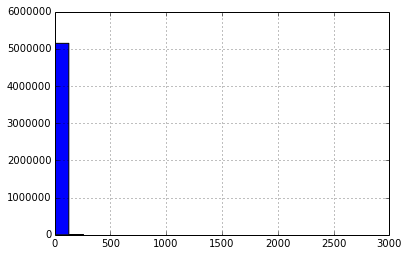

In [43]:
photo_data['exposure_num'].hist(bins=20)

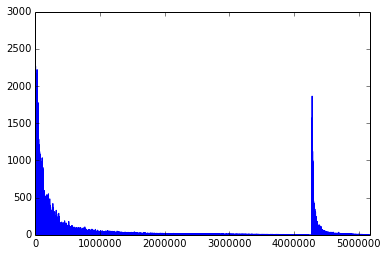

In [44]:
photo_data.exposure_num.plot()

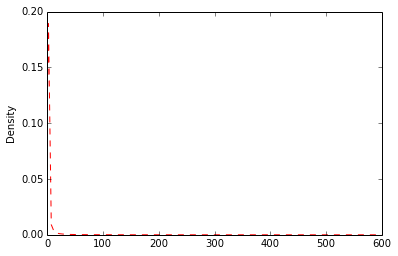

In [45]:
# photo_data.exposure_num.hist(bins=doanes(photo_data.exposure_num.dropna()), normed=True, color='lightseagreen')
photo_data.exposure_num.dropna().plot(kind='kde', xlim=(0,600), style='r--')

In [46]:
photo_data.exposure_num.describe()

count    5.174532e+06
mean     4.666253e+00
std      2.922452e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.521000e+03
Name: exposure_num, dtype: float64

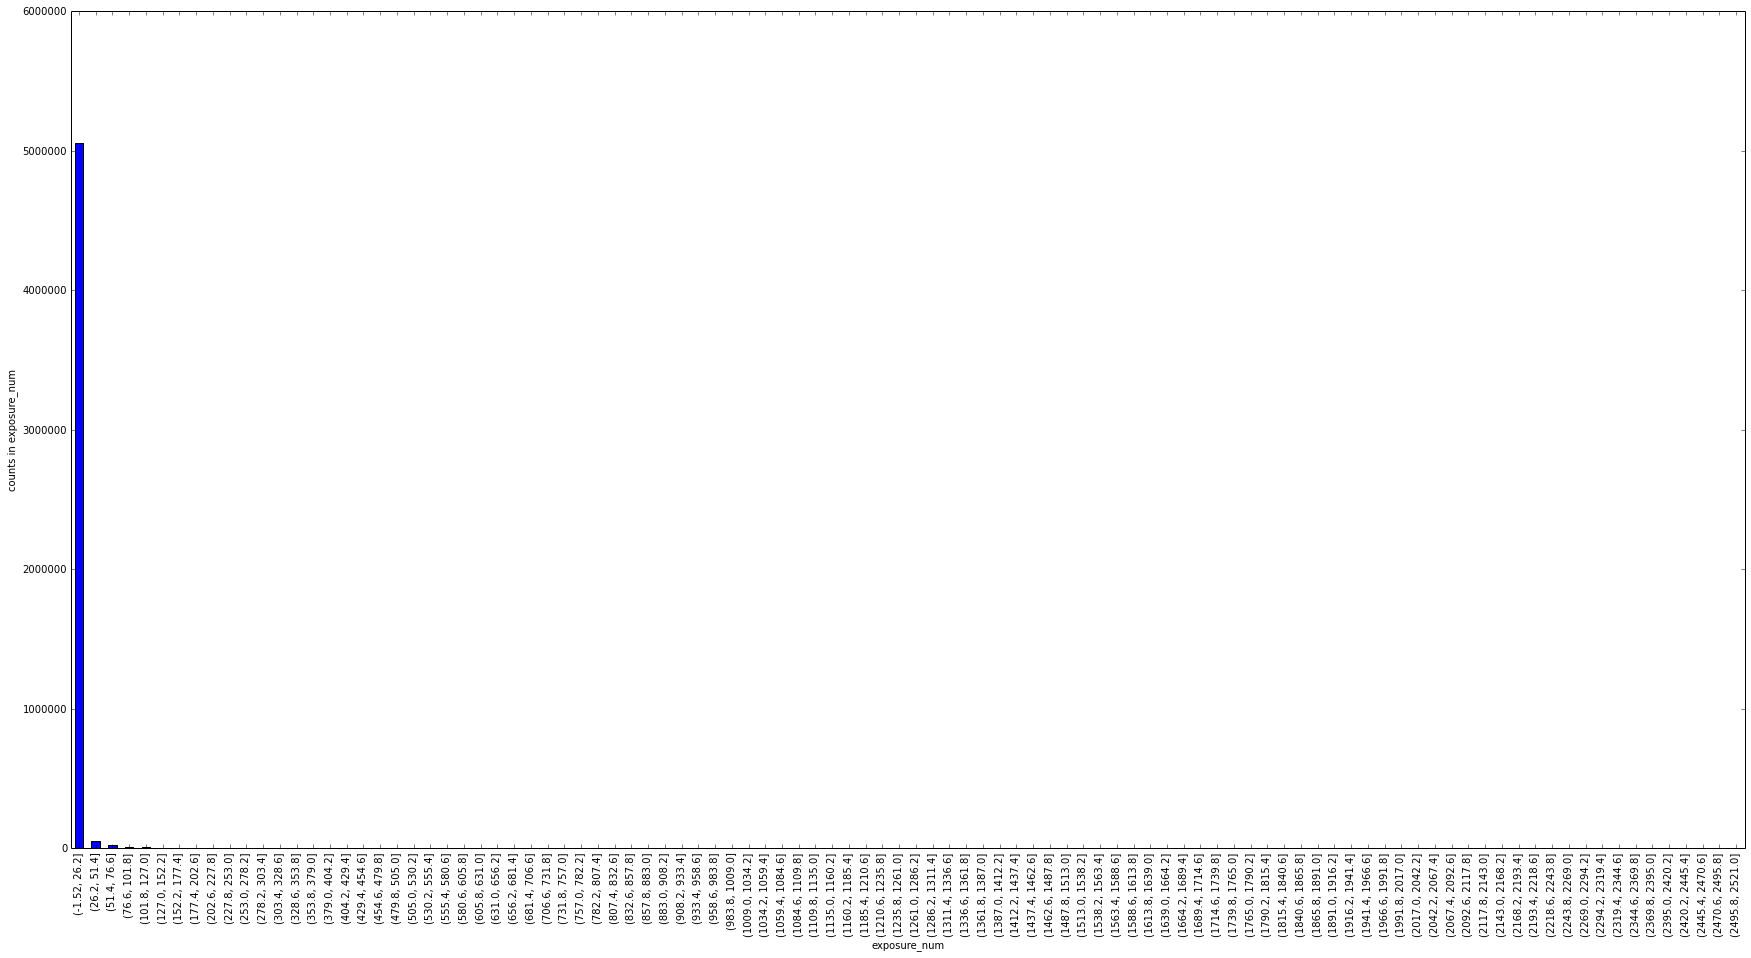

In [47]:
plot_data_cut(photo_data, 'exposure_num', 100)

In [97]:
# plot_data_cut(photo_data, 'duration_time', 100)

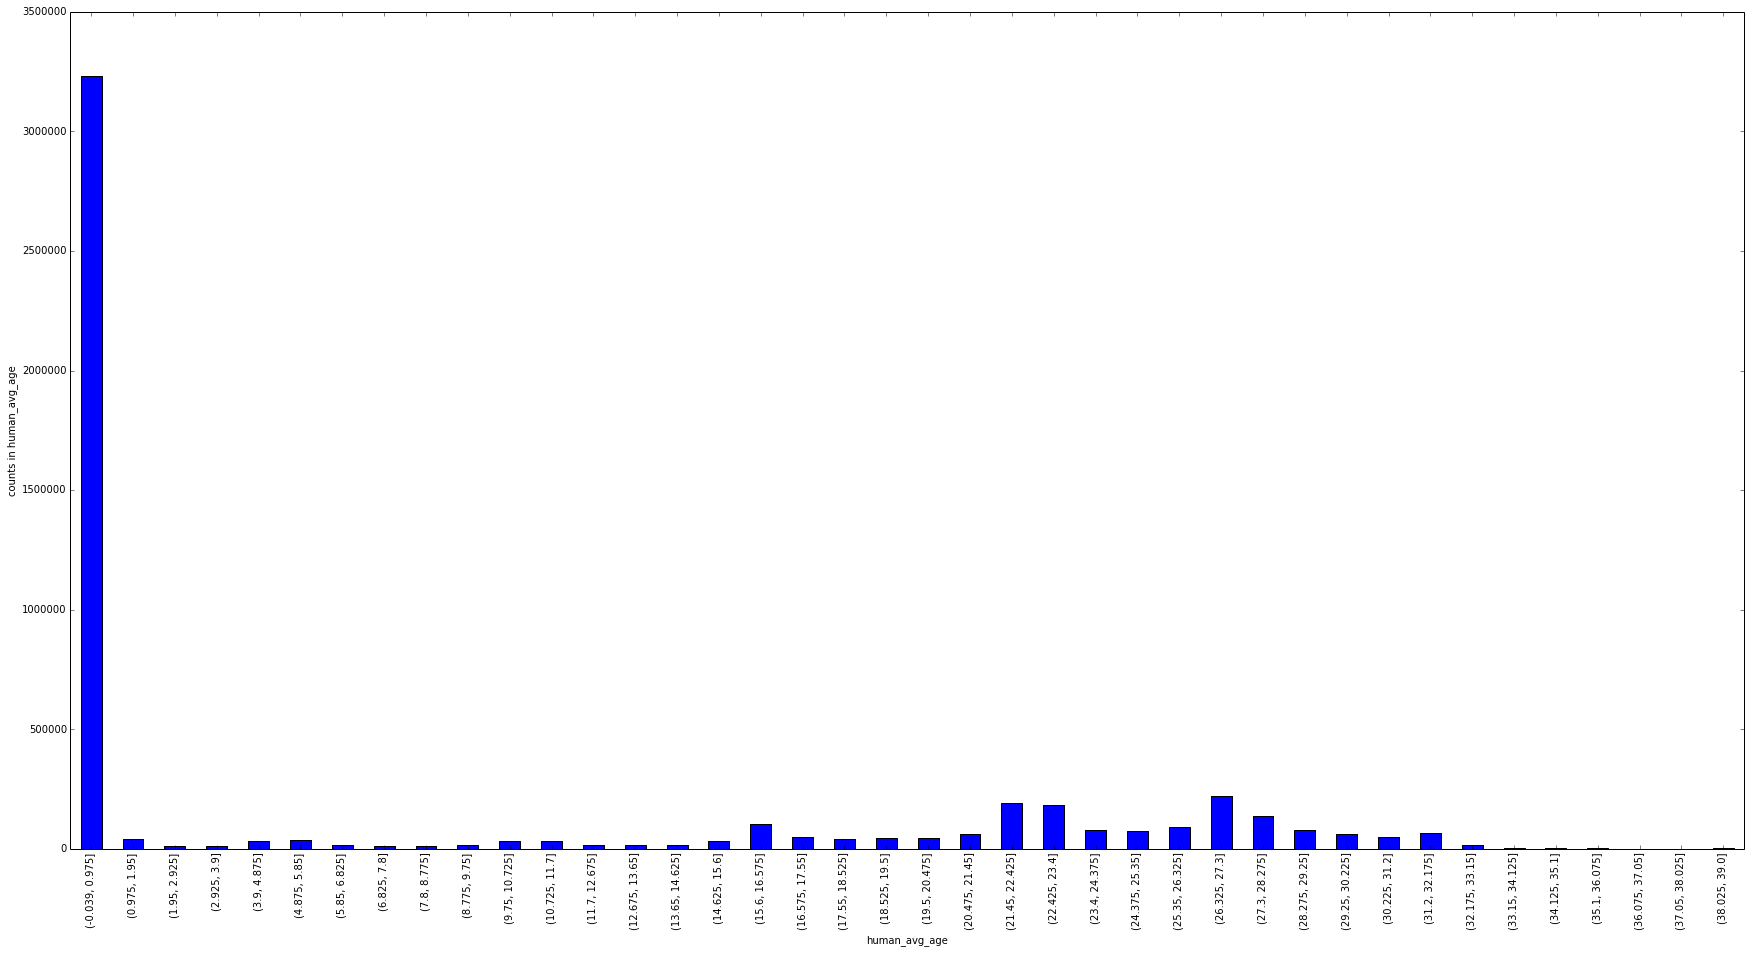

In [44]:
plot_data_cut(photo_data, 'human_avg_age', 40)

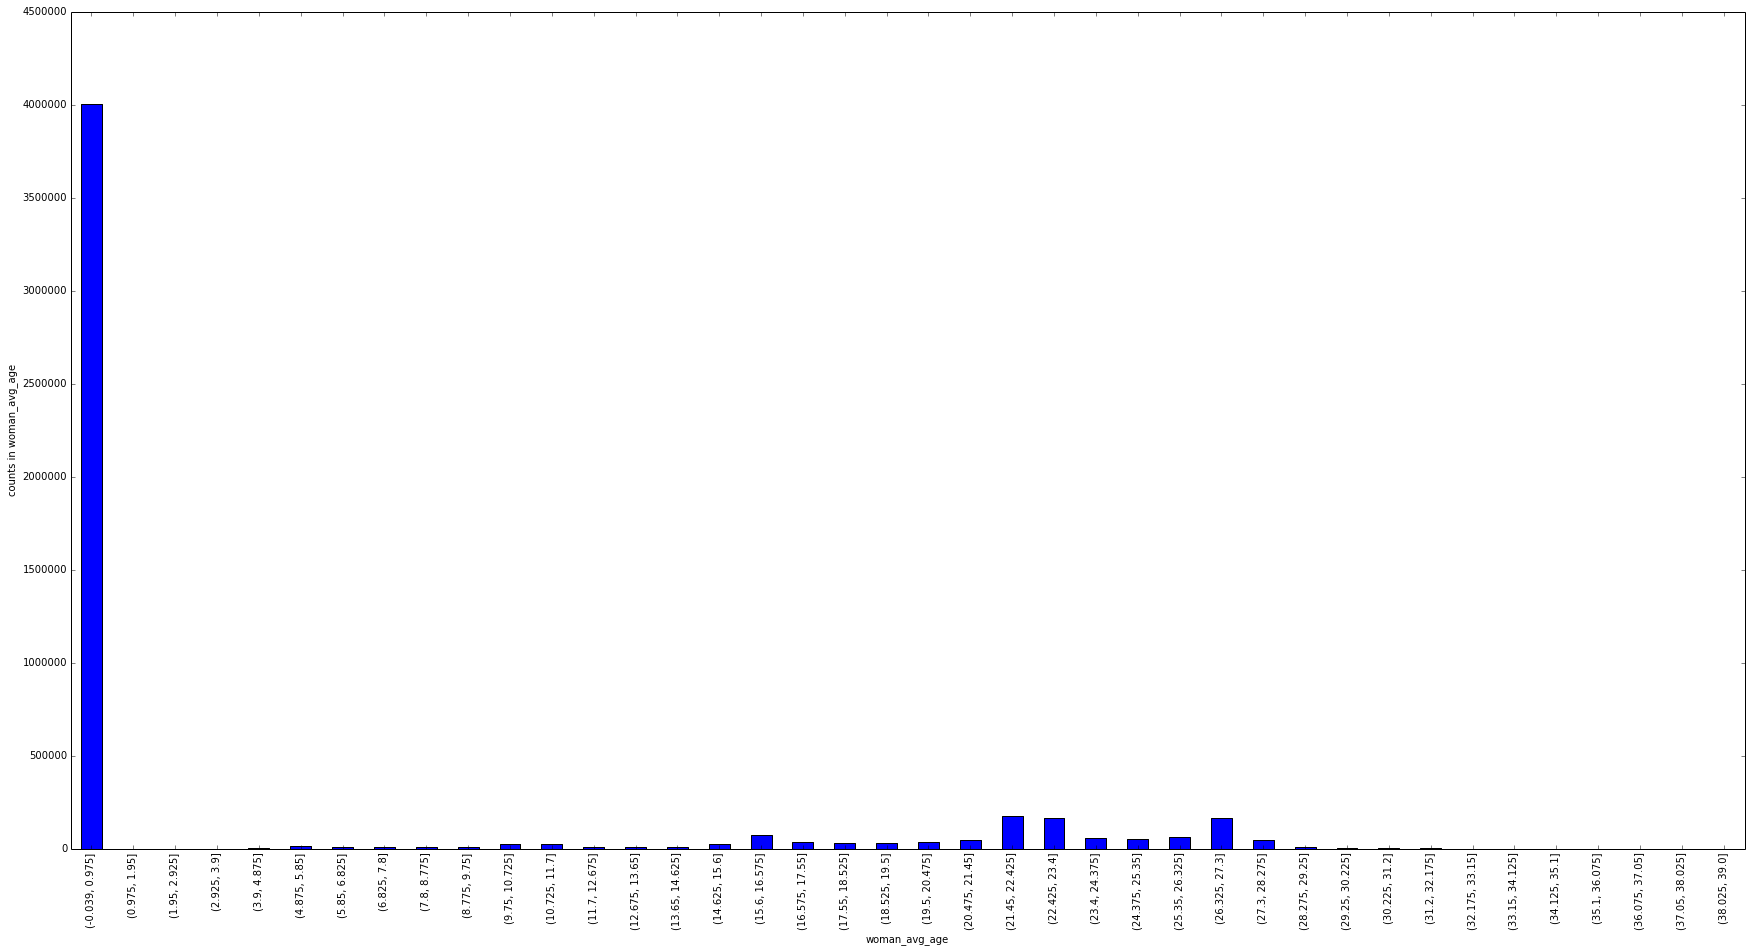

In [45]:
plot_data_cut(photo_data, 'woman_avg_age', 40)

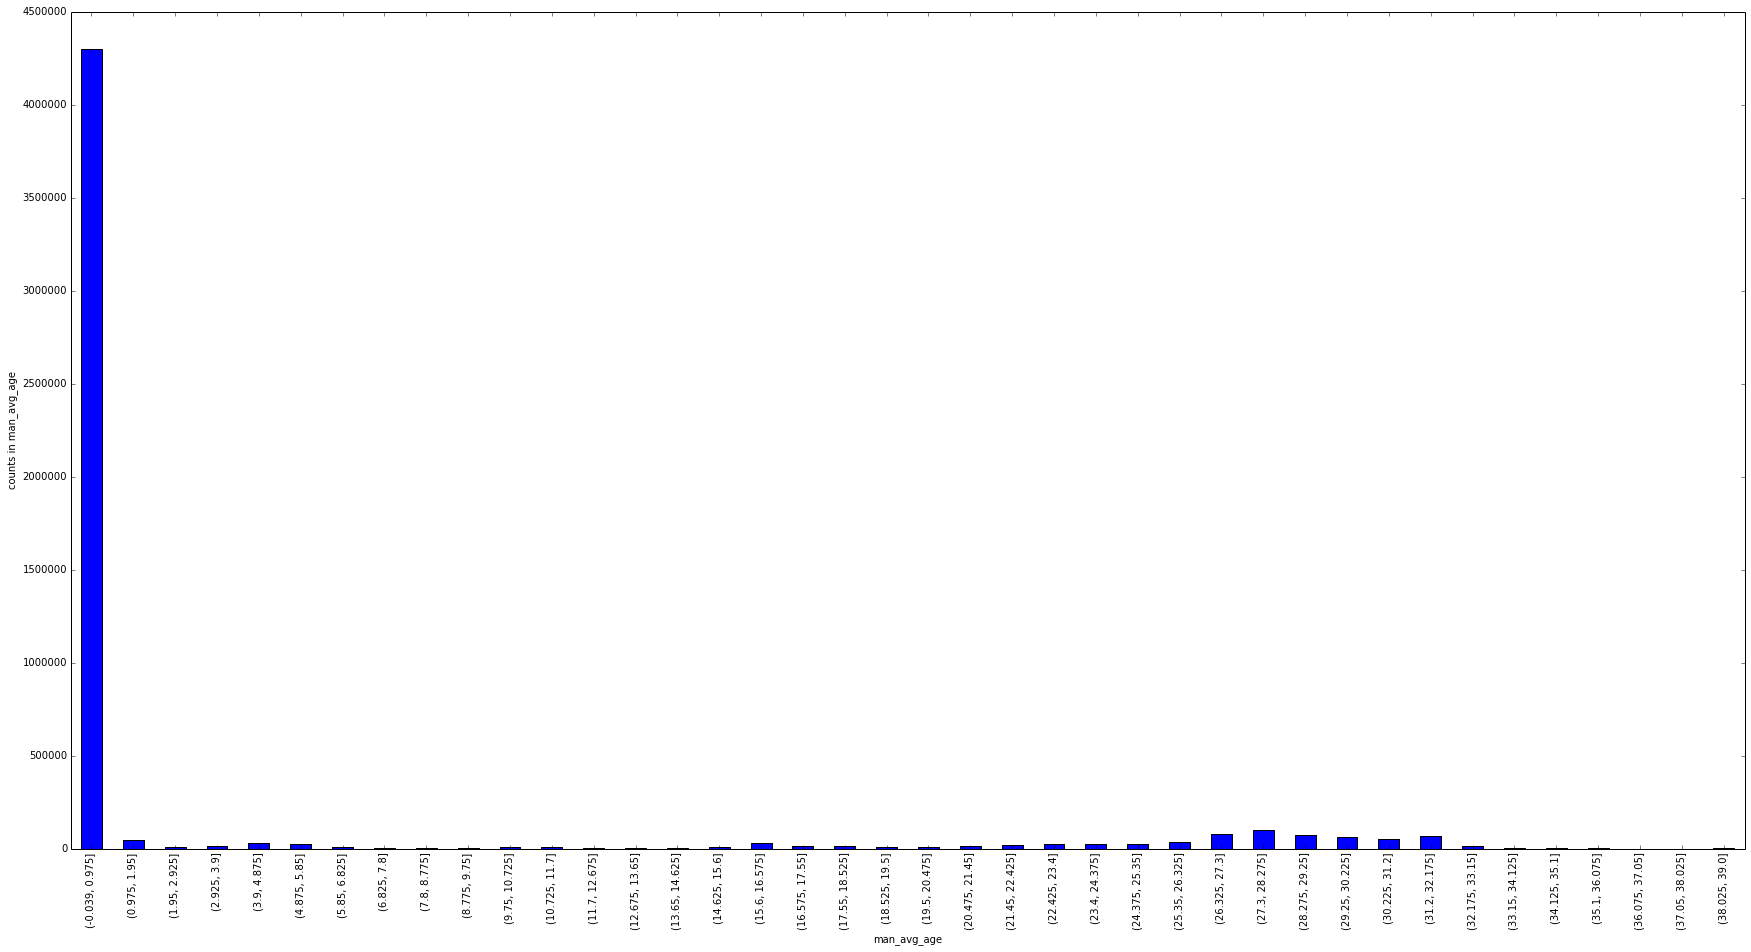

In [46]:
plot_data_cut(photo_data, 'man_avg_age', 40)

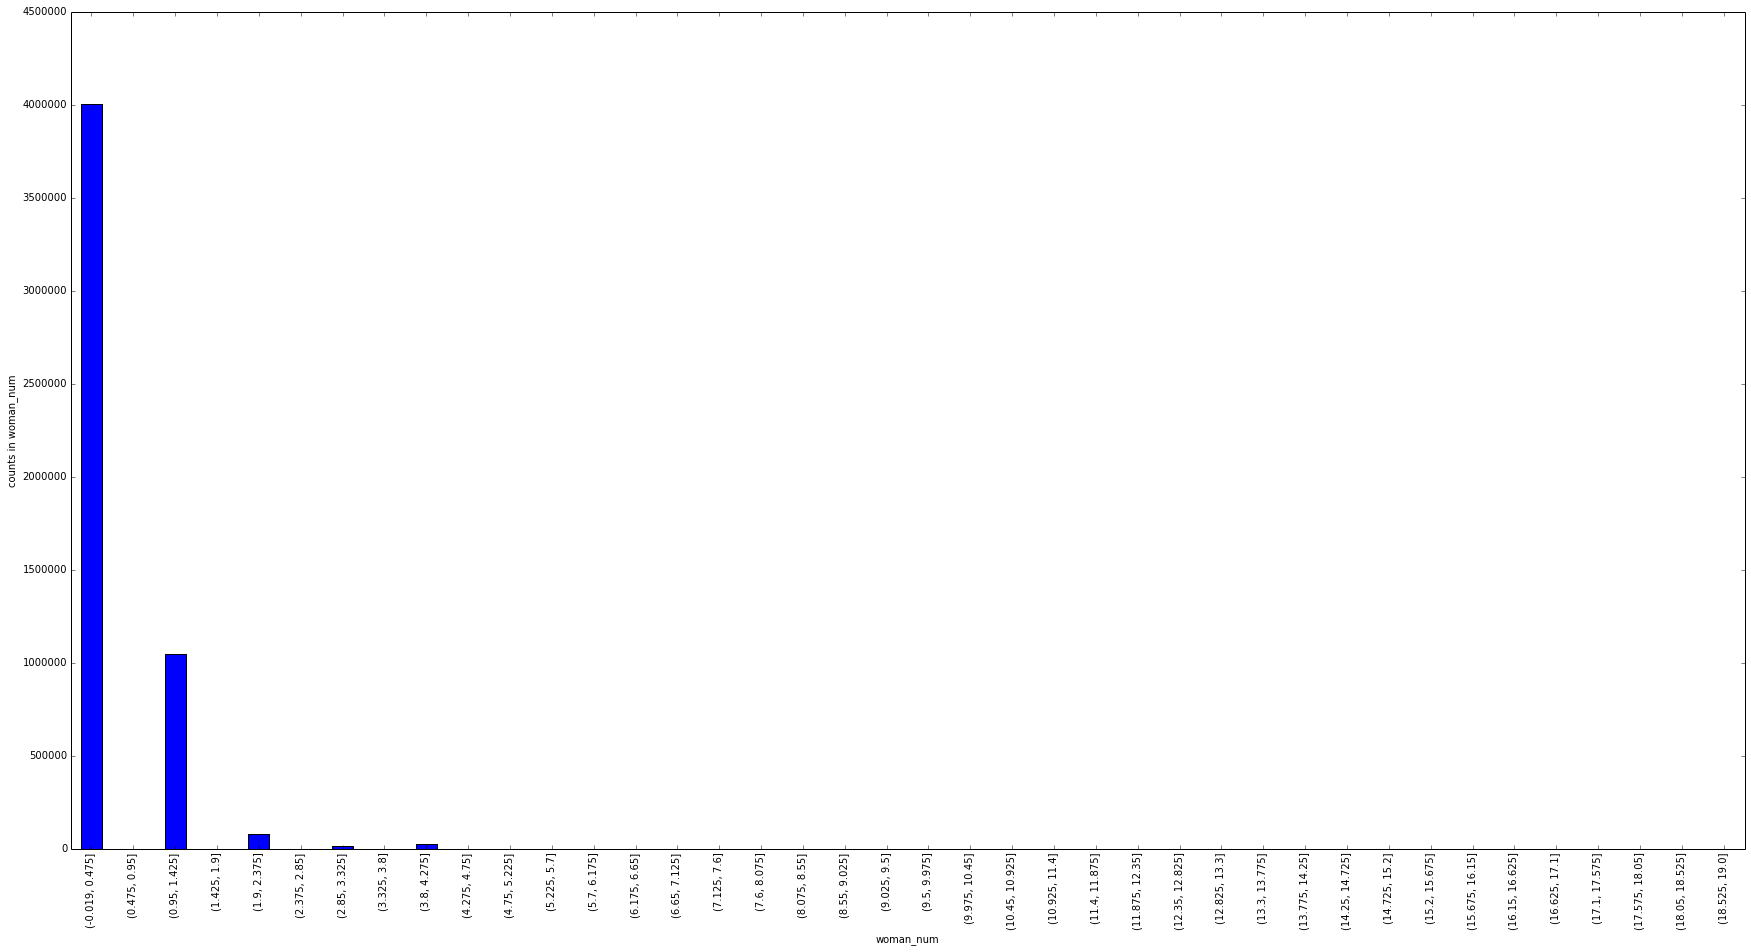

In [47]:
plot_data_cut(photo_data, 'woman_num', 40)

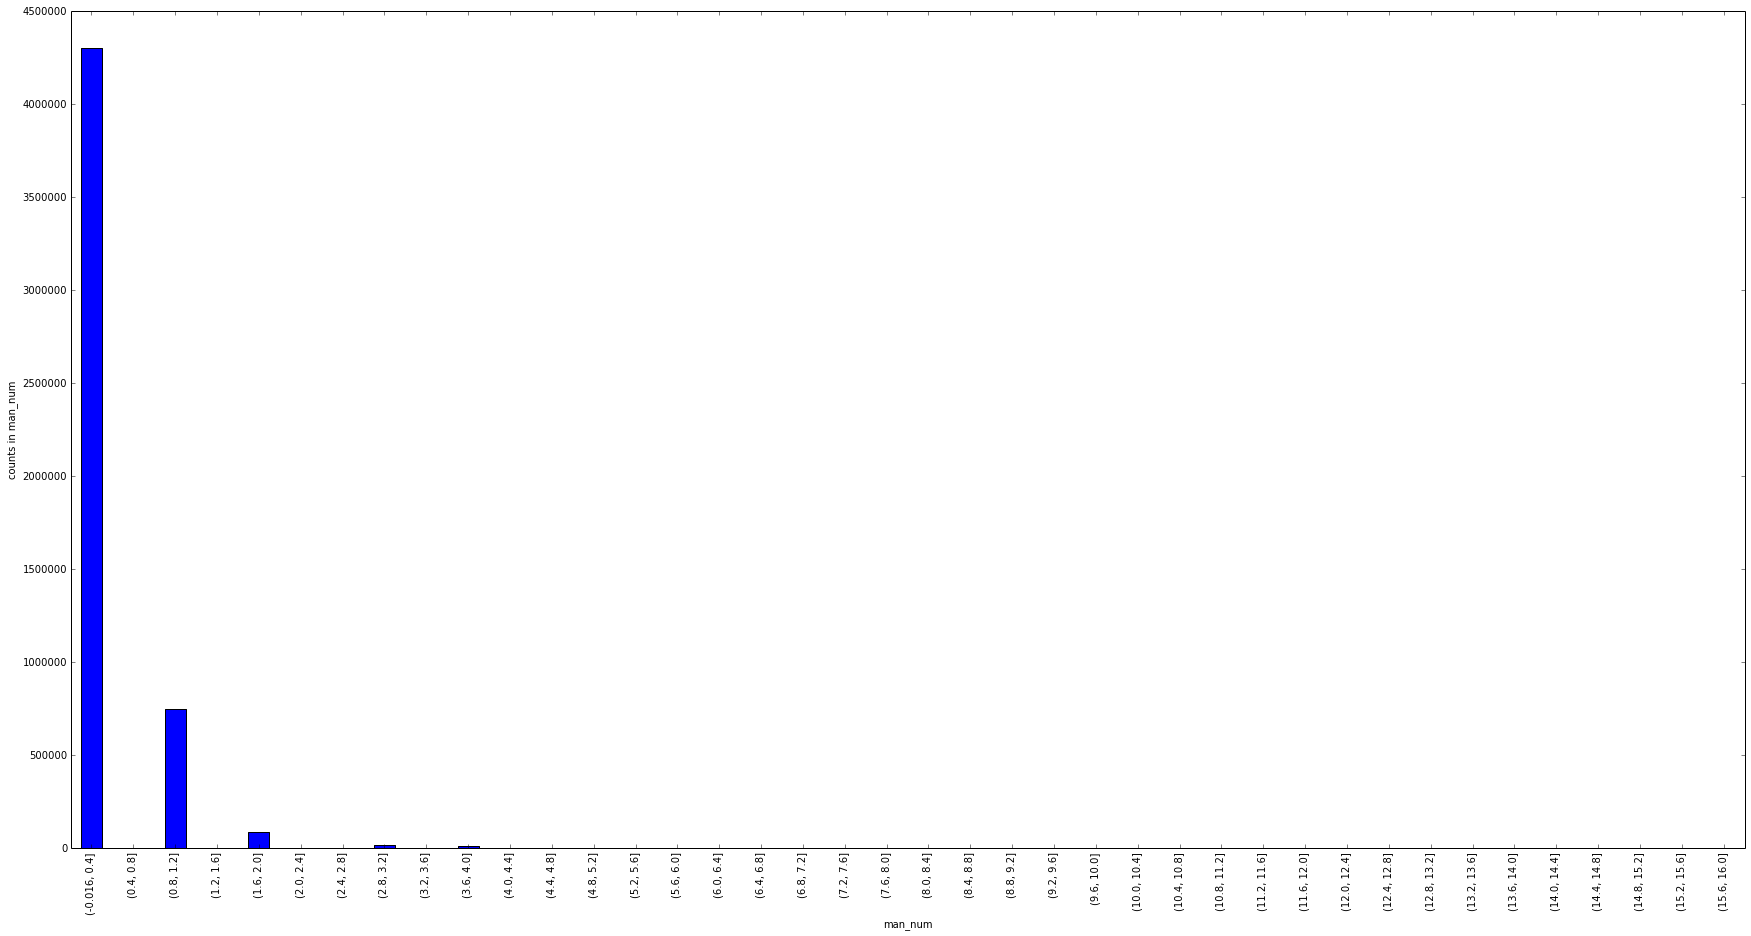

In [48]:
plot_data_cut(photo_data, 'man_num', 40)

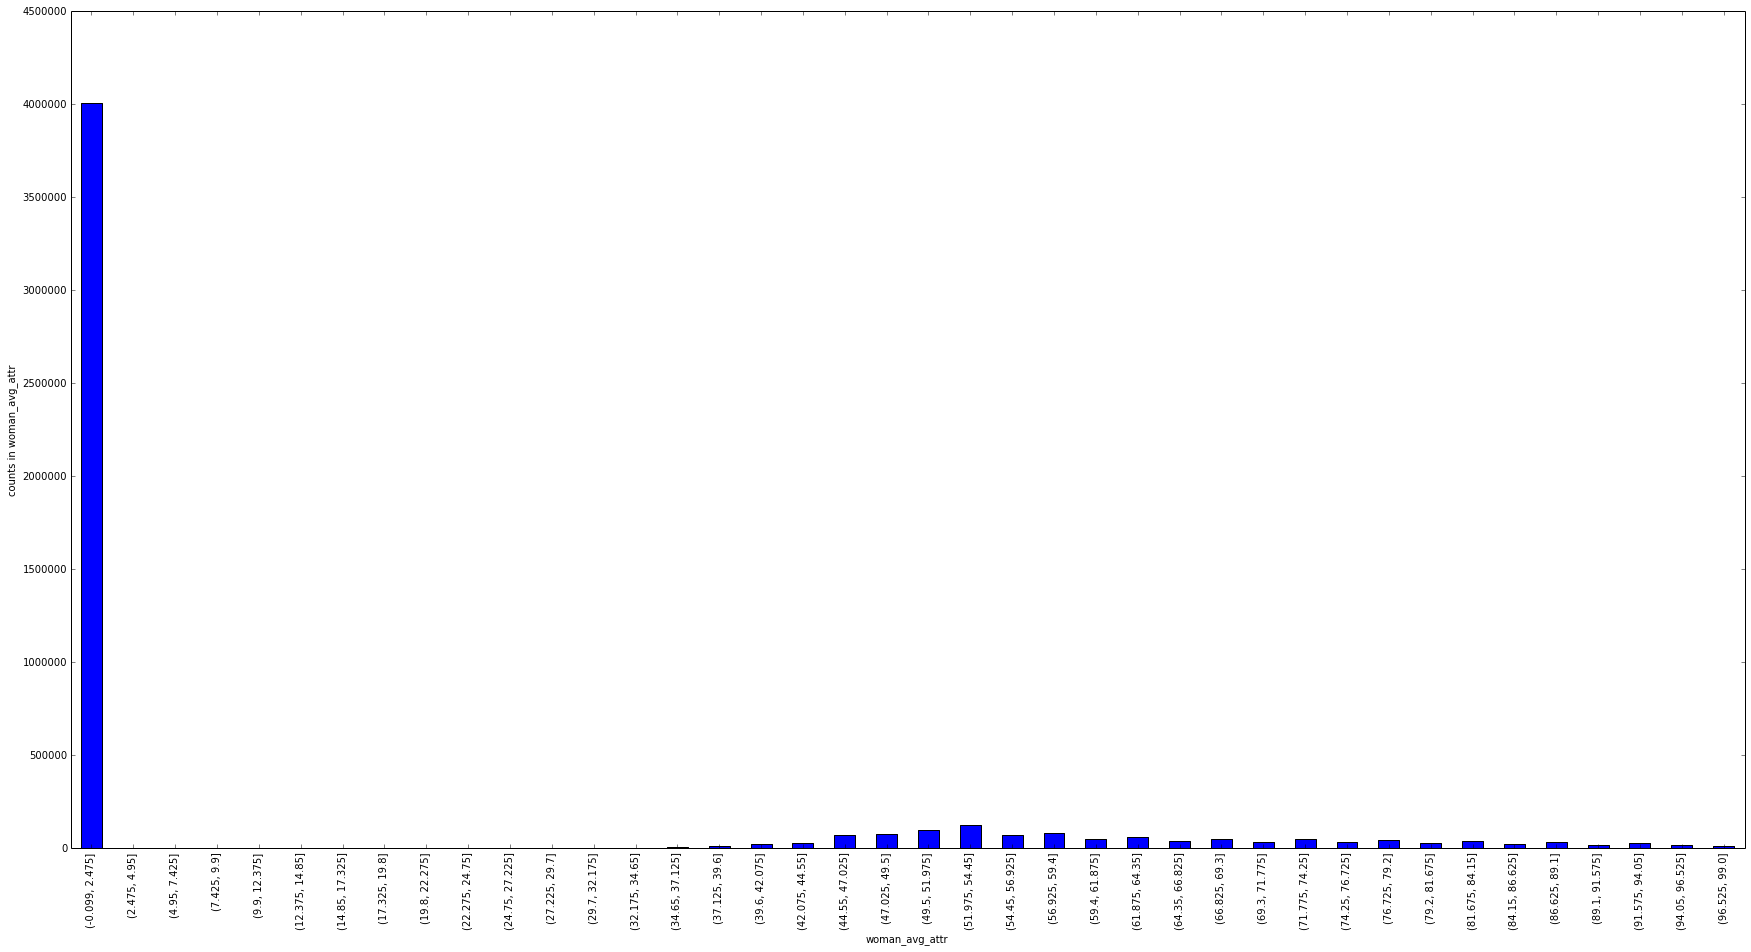

In [49]:
plot_data_cut(photo_data, 'woman_avg_attr', 40)

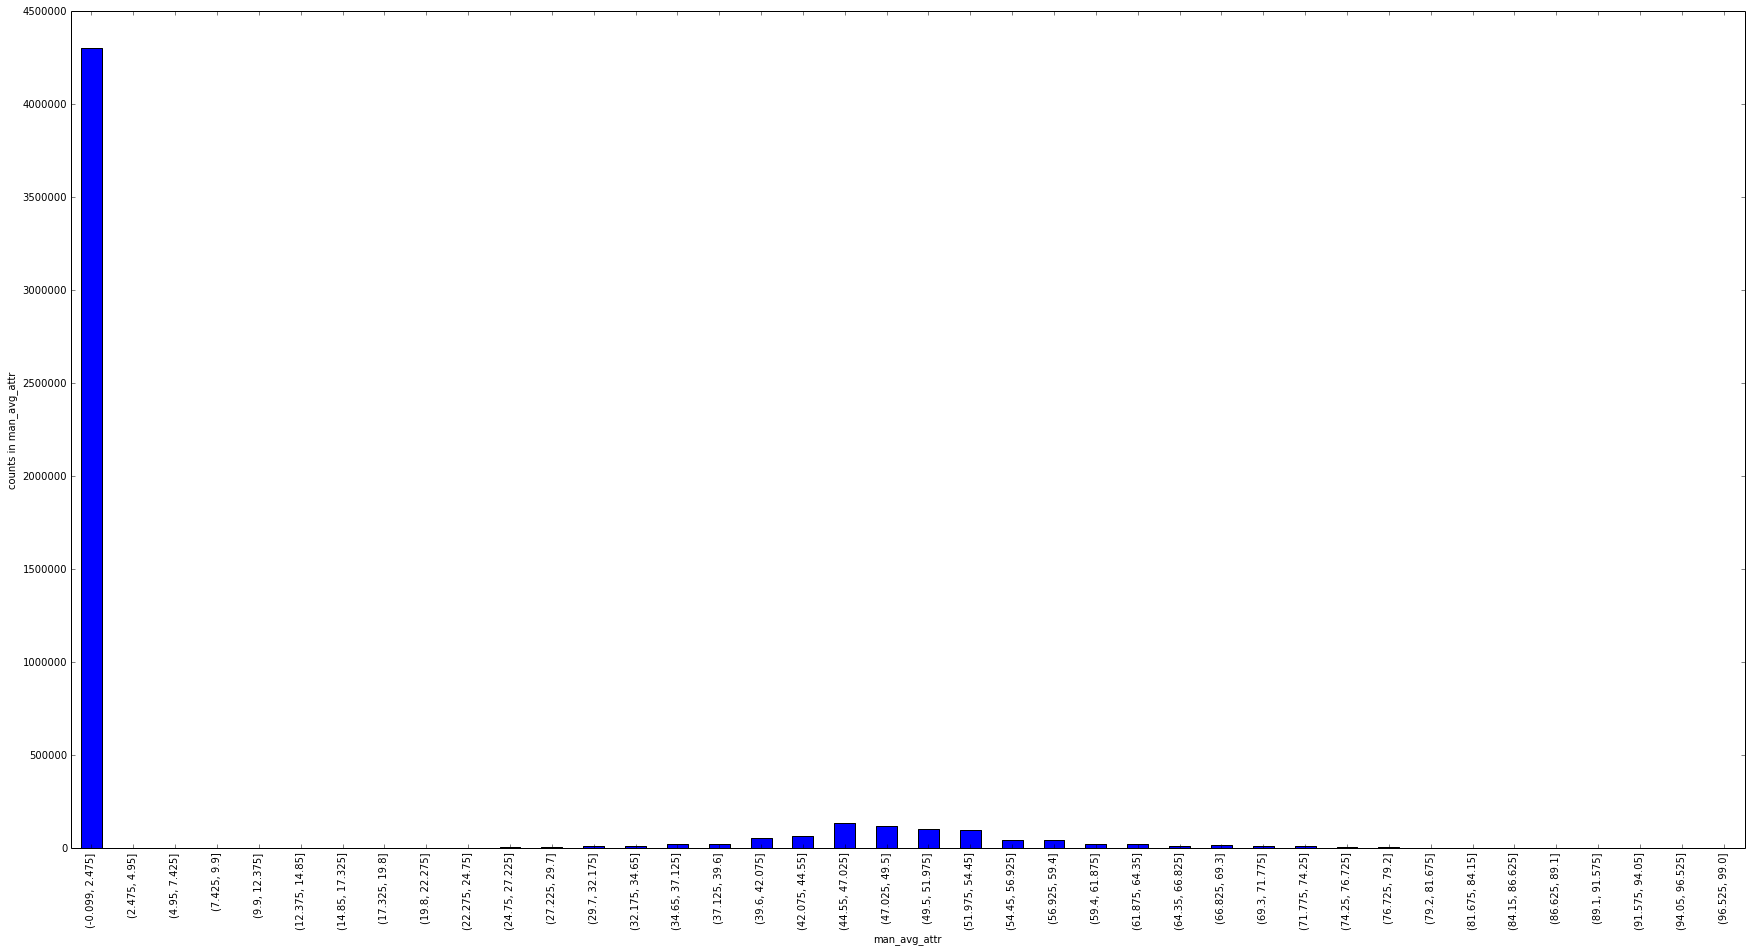

In [50]:
plot_data_cut(photo_data, 'man_avg_attr', 40)

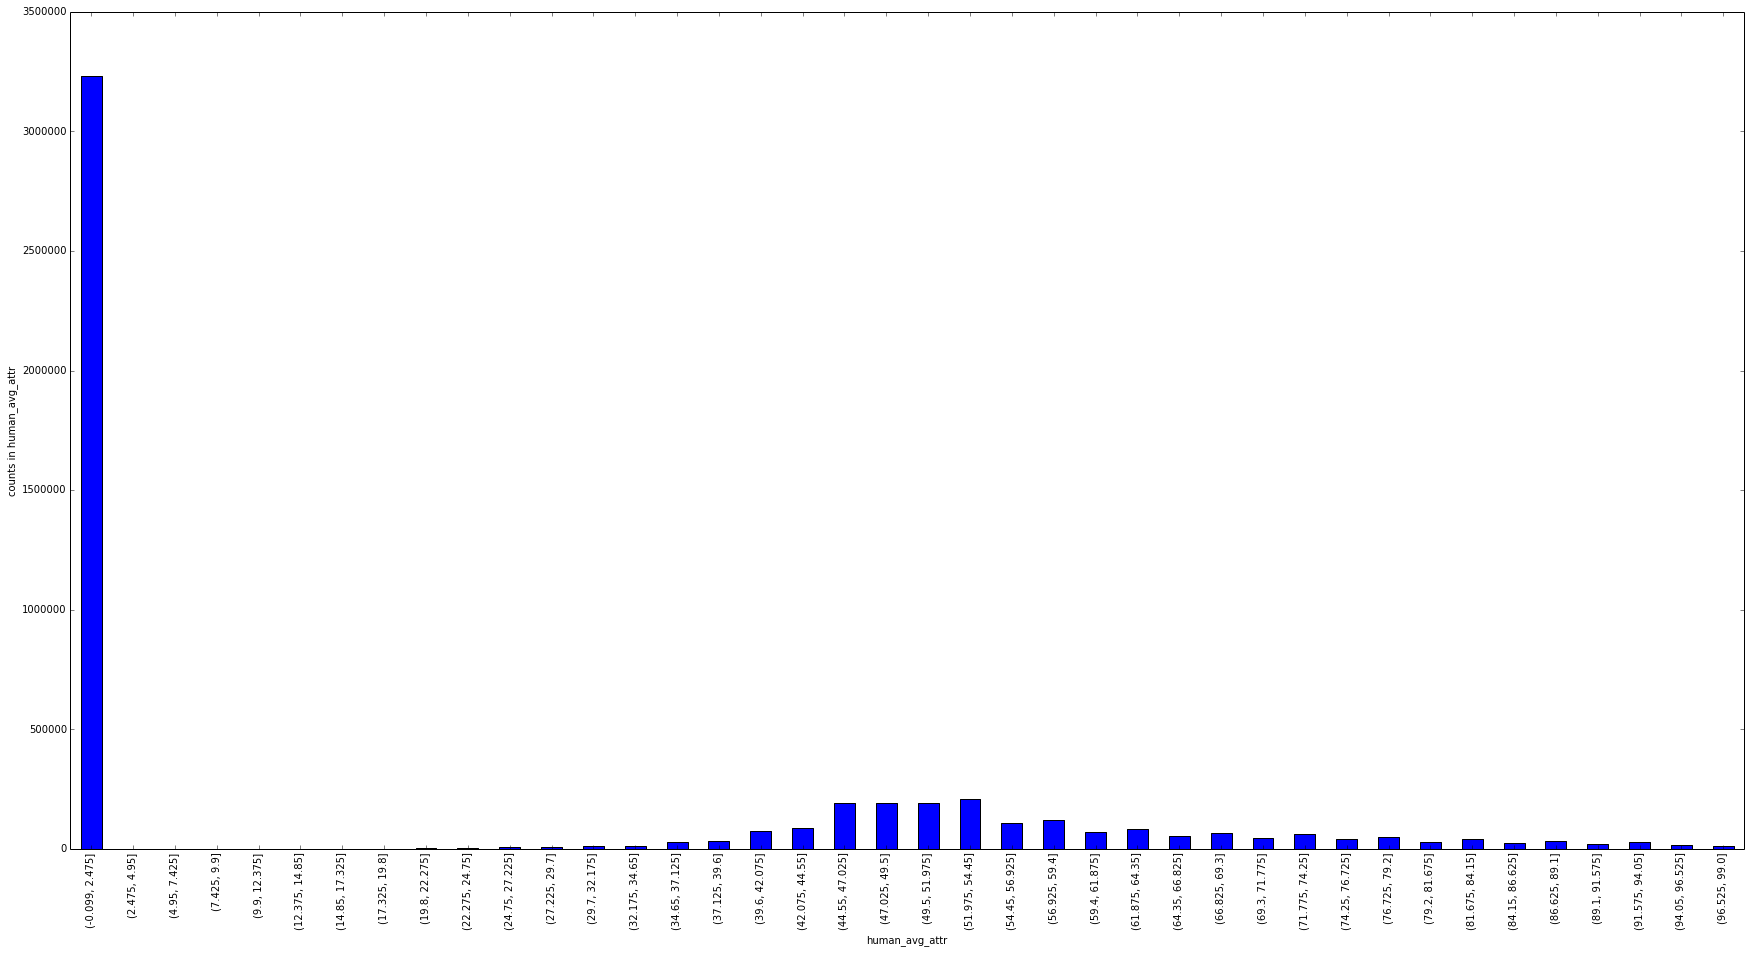

In [51]:
plot_data_cut(photo_data, 'human_avg_attr', 40)

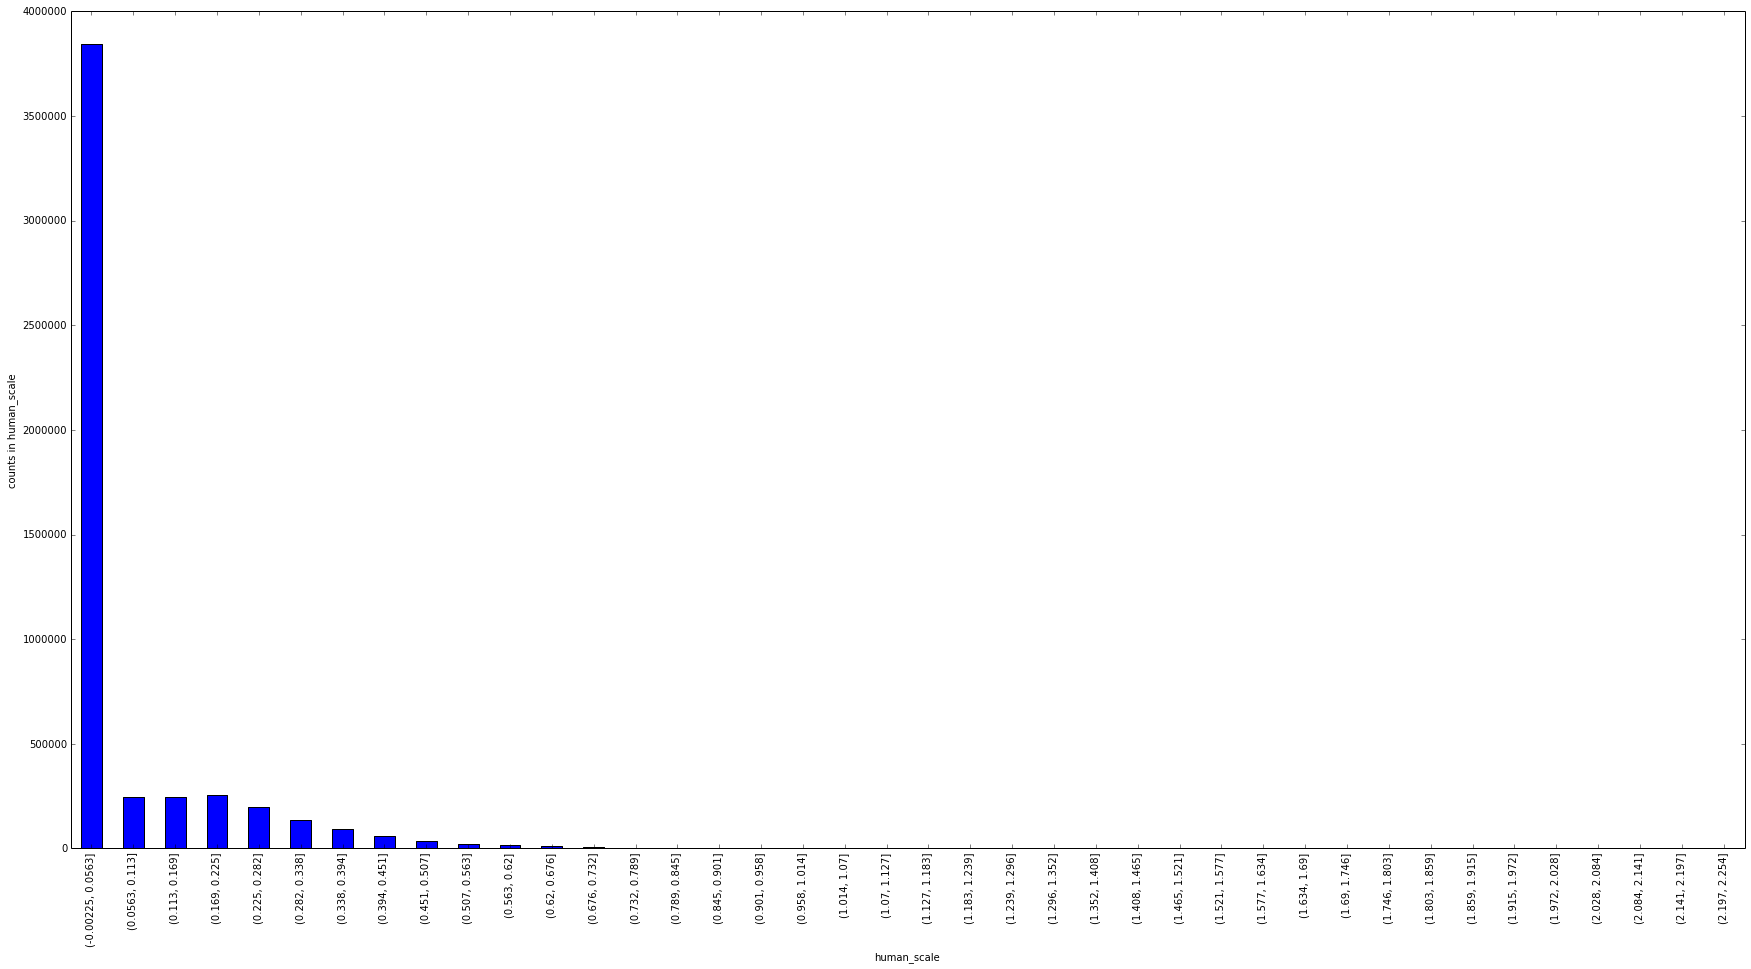

In [52]:
plot_data_cut(photo_data, 'human_scale', 40)

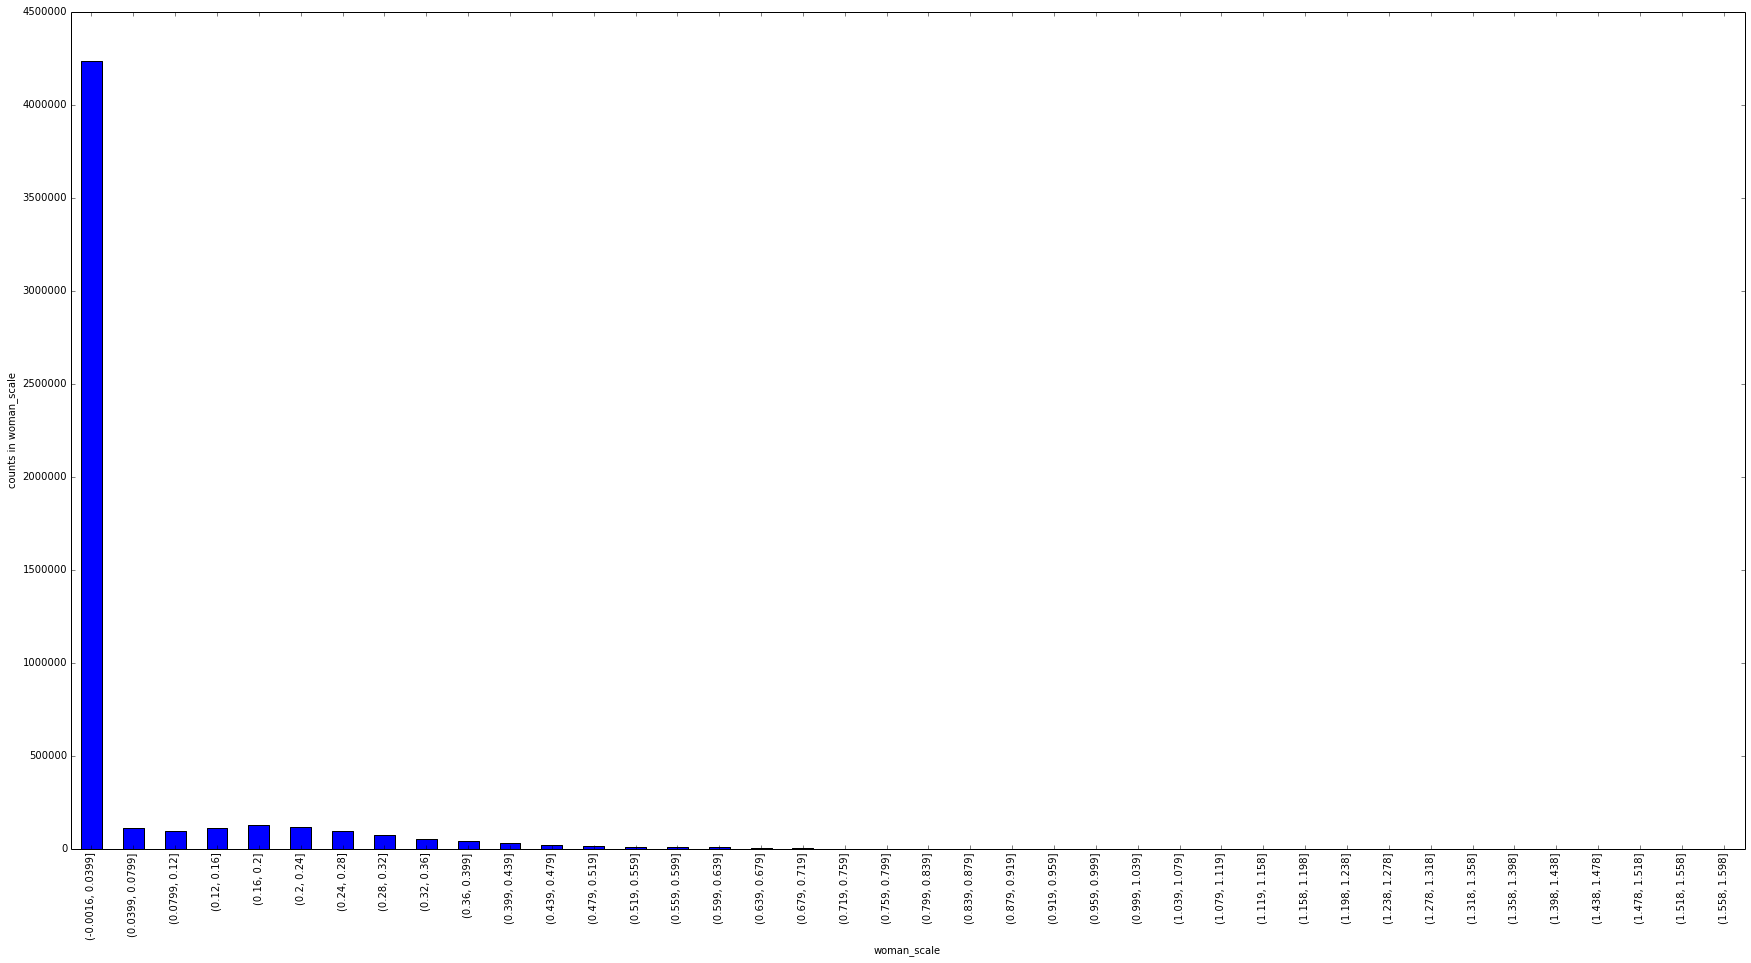

In [53]:
plot_data_cut(photo_data, 'woman_scale', 40)

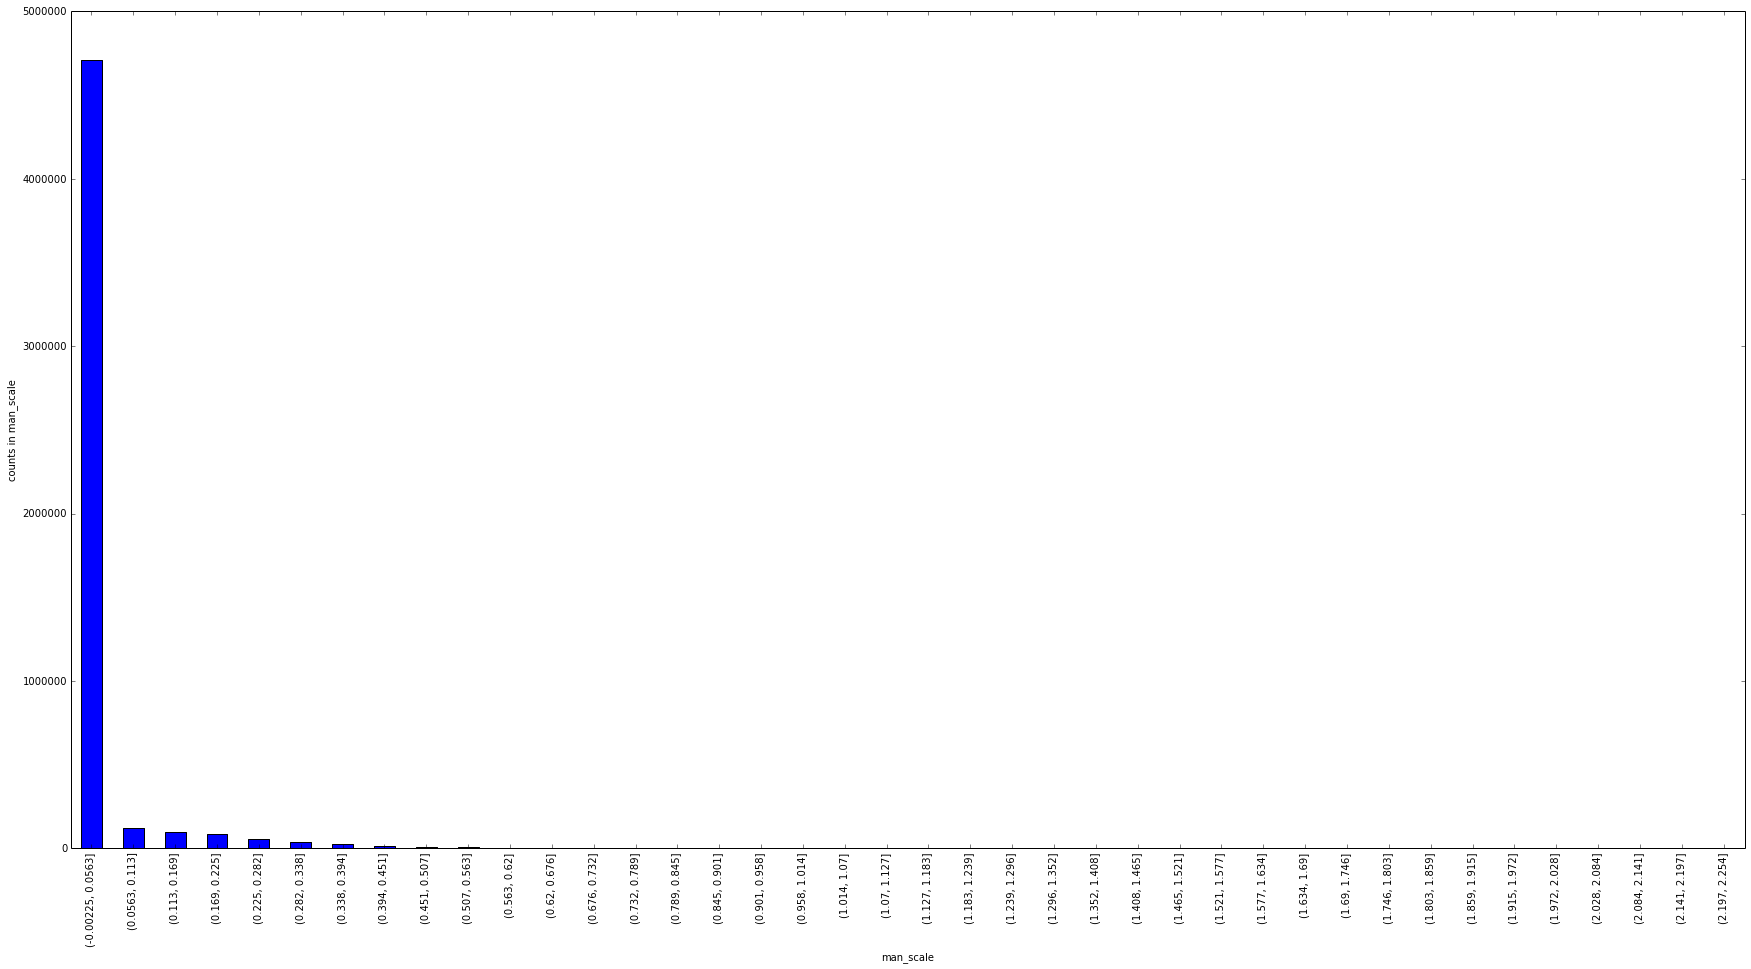

In [54]:
plot_data_cut(photo_data, 'man_scale', 40)

In [55]:
user_item_data.columns.values

array(['user_id', 'photo_id', 'time', 'duration_time'], dtype=object)

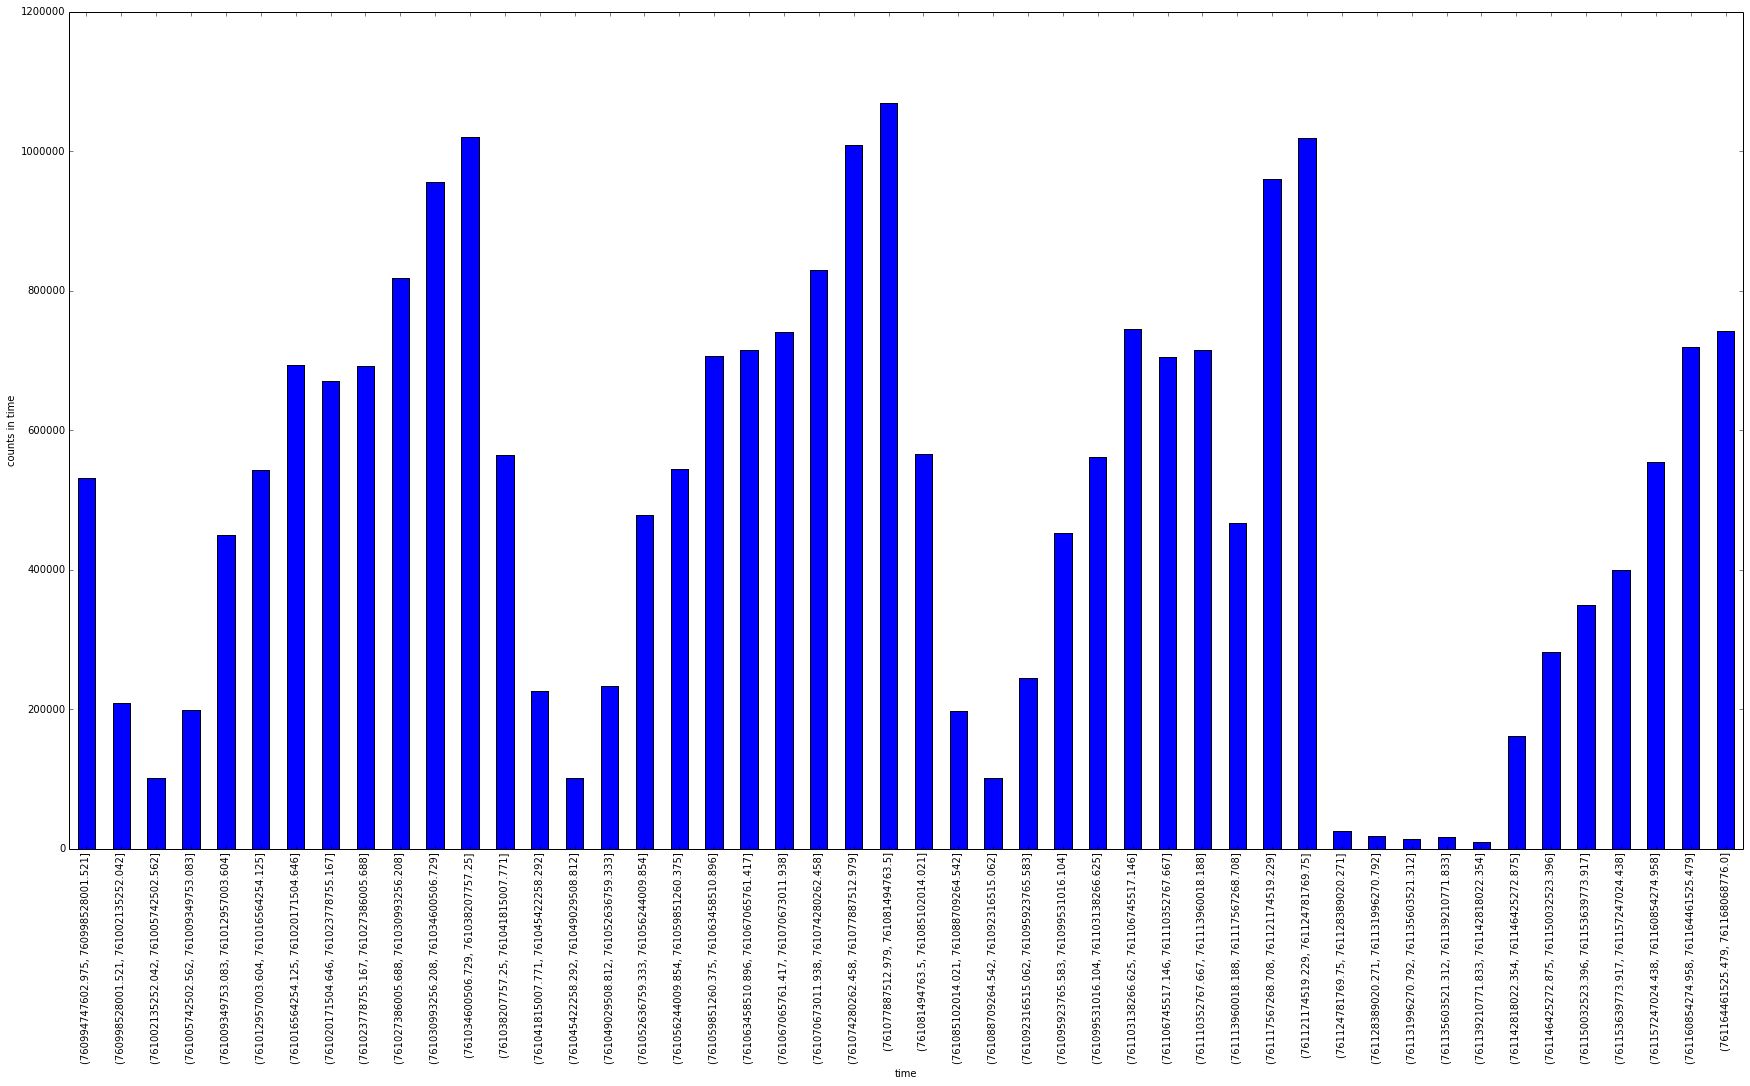

In [56]:
plot_data_cut(user_item_data, 'time', 48)

In [57]:
user_item_data.duration_time.describe()

count    2.414568e+07
mean     1.986848e+01
std      2.747413e+01
min      0.000000e+00
25%      1.100000e+01
50%      1.100000e+01
75%      1.700000e+01
max      3.831000e+03
Name: duration_time, dtype: float64

In [58]:
list(photo_data.columns.values)

['photo_id',
 'exposure_num',
 'face_num',
 'man_num',
 'woman_num',
 'man_scale',
 'woman_scale',
 'human_scale',
 'man_avg_age',
 'woman_avg_age',
 'human_avg_age',
 'man_avg_attr',
 'woman_avg_attr',
 'human_avg_attr']

In [59]:
def exposure_num_discretization(exposure_num):
    if 0 < exposure_num and exposure_num <= 10:
        return 0
    elif 10 < exposure_num and exposure_num <= 100:
        return 1
    elif 100 < exposure_num and exposure_num <= 1000:
        return 2
    else:
        return 3
    
def duration_time_discretization(t):
    if 0 < t <= 30:
        return 0
    elif 30 < t <= 60:
        return 1
    elif 60 < t < 300:
        return 2
    else:
        return 3

def face_num_discretization(face_num):
    if face_num == 0:
        return 0
    elif face_num == 1:
        return 1
    elif face_num == 2:
        return 2
    elif face_num == 3:
        return 3
    else:
        return 4

def man_num_discretization(man_num):
    if man_num == 0:
        return 0
    elif man_num == 1:
        return 1
    elif man_num == 2:
        return 2
    elif man_num == 3:
        return 3
    else:
        return 4
    
def woman_num_discretization(woman_num):
    if woman_num == 0:
        return 0
    elif woman_num == 1:
        return 1
    elif woman_num == 2:
        return 2
    elif woman_num == 3:
        return 3
    else:
        return 4

def human_avg_age_discretization(human_age):
    if human_age == 0:
        return 0
    elif 0 < human_age and human_age <= 12:
        return 1
    elif 12 < human_age and human_age <= 18:
        return 2
    elif 18 < human_age and human_age <= 24:
        return 3
    elif 24 < human_age and human_age <= 32:
        return 4
    elif human_age > 32:
        return 5

def woman_avg_age_discretization(woman_age):
    if woman_age == 0:
        return 0
    elif 0 < woman_age and woman_age <= 12:
        return 1
    elif 12 < woman_age and woman_age <= 18:
        return 2
    elif 18 < woman_age and woman_age <= 24:
        return 3
    elif 24 < woman_age and woman_age <= 28:
        return 4
    elif woman_age > 28:
        return 5

def man_avg_age_discretization(man_age):
    if man_age == 0:
        return 0
    elif 0 < man_age and man_age <= 12:
        return 1
    elif 12 < man_age and man_age <= 18:
        return 2
    elif 18 < man_age and man_age <= 24:
        return 3
    elif 24 < man_age and man_age <= 40:
        return 4
    elif woman_age > 40:
        return 5
    
def human_avg_attr_discretization(human_attr):
    if human_attr == 0:
        return 0
    elif 0 < human_attr and human_attr <= 50:
        return 1
    elif 50 < human_attr and human_attr <= 60:
        return 2
    elif 60 < human_attr and human_attr <= 70:
        return 3
    elif 70 < human_attr and human_attr <= 80:
        return 4
    elif human_attr > 80:
        return 5

def man_avg_attr_discretization(man_attr):
    if man_attr == 0:
        return 0
    elif 0 < man_attr and man_attr <= 50:
        return 1
    elif 50 < man_attr and man_attr <= 60:
        return 2
    elif 60 < man_attr and man_attr <= 70:
        return 3
    elif 70 < man_attr and man_attr <= 80:
        return 4
    elif man_attr > 80:
        return 5
    
def woman_avg_attr_discretization(woman_attr):
    if woman_attr == 0:
        return 0
    elif 0 < woman_attr and woman_attr <= 50:
        return 1
    elif 50 < woman_attr and woman_attr <= 60:
        return 2
    elif 60 < woman_attr and woman_attr <= 70:
        return 3
    elif 70 < woman_attr and woman_attr <= 80:
        return 4
    elif woman_attr > 80:
        return 5
    
def human_scale_discretization(human_scale):
    if human_scale == 0:
        return 0
    elif 0 < human_scale and human_scale <= 0.1:
        return 1
    elif 0.1 < human_scale and human_scale <= 0.2:
        return 2
    elif 0.2 < human_scale and human_scale <= 0.3:
        return 3
    elif 0.3 < human_scale and human_scale <= 0.4:
        return 4
    elif 0.4 < human_scale and human_scale <= 0.5:
        return 5
    elif 0.5 < human_scale and human_scale <= 0.6:
        return 6
    else:
        return 7

def man_scale_discretization(man_scale):
    if man_scale == 0:
        return 0
    elif 0 < man_scale and man_scale <= 0.1:
        return 1
    elif 0.1 < man_scale and man_scale <= 0.2:
        return 2
    elif 0.2 < man_scale and man_scale <= 0.3:
        return 3
    elif 0.3 < man_scale and man_scale <= 0.4:
        return 4
    elif 0.4 < man_scale and man_scale <= 0.5:
        return 5
    elif 0.5 < man_scale and man_scale <= 0.6:
        return 6
    else:
        return 7

def woman_scale_discretization(woman_scale):
    if woman_scale == 0:
        return 0
    elif 0 < woman_scale and woman_scale <= 0.1:
        return 1
    elif 0.1 < woman_scale and woman_scale <= 0.2:
        return 2
    elif 0.2 < woman_scale and woman_scale <= 0.3:
        return 3
    elif 0.3 < woman_scale and woman_scale <= 0.4:
        return 4
    elif 0.4 < woman_scale and woman_scale <= 0.5:
        return 5
    elif 0.5 < woman_scale and woman_scale <= 0.6:
        return 6
    else:
        return 7


In [60]:
photo_data['have_face_cate'] = photo_data['face_num'].apply(lambda x: x >= 1)

In [61]:
photo_data.head()

,photo_id,exposure_num,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,have_face_cate
0,6484142,13,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
1,4647664,2,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
2,4994626,34,3.0,3.0,0.0,0.3959,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333,True
3,4416881,1,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
4,2597756,2,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False


In [62]:
# pd.get_dummies(photo_data)

In [63]:
user_item_train = pd.merge(user_item_train, photo_data,
                          how='left',
                          on=['photo_id'])

In [64]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,have_face_cate
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,0.3959,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333,True
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False


In [65]:
# user_item_train[(user_item_train['user_id'] == 35273) & (user_item_train['click'] == 1)]

In [66]:
# user_item_train['user_id'].groupby(user_item_train['user_id']).transform('count').drop_duplicates()

In [67]:
# user_item_train['like'].groupby(user_item_train['user_id']).transform('sum').drop_duplicates()

# 点击率相关特征平滑
点击率、喜爱率、偏爱率的统计，如果是直接用点击数比总数，对于CTR来说往往会有偏差，比如一个用户看了一个视频，而且点了，那么他的点击率就是1，但是一个用户看了100个视频，点了80个，点击率是0.8，显然，我们不能说前者就是倾向于更爱点击了，因此我们需要做平滑处理！
雅虎一篇论文做了关于CTR特征平滑的方法，$\frac{C + \alpha}{I + \alpha + \beta}$, 关键是找到分子分母合适的平滑参数。

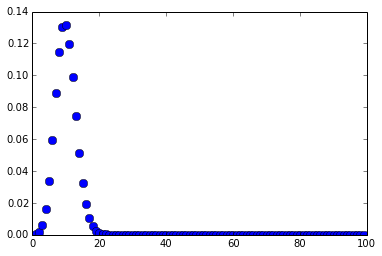

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

n, p = 100, 0.1
x = np.arange(1,100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
plt.show()

In [68]:
users = pd.DataFrame()
users['user_id'] = user_item_train['user_id']

users['browse_num'] = user_item_train['user_id'].groupby(user_item_train['user_id']).transform('count')
users['click_num'] = user_item_train['click'].groupby(user_item_train['user_id']).transform('sum')
users['like_num'] = user_item_train['like'].groupby(user_item_train['user_id']).transform('sum')
users['follow_num'] = user_item_train['follow'].groupby(user_item_train['user_id']).transform('sum')
users['playing_sum'] = user_item_train['playing_time'].groupby(user_item_train['user_id']).transform('sum')
users['duration_sum'] = user_item_train['duration_time'].groupby(user_item_train['user_id']).transform('sum')
users['click_ratio'] = user_item_train['click'].groupby(user_item_train['user_id']).transform('mean')
users['like_ratio'] = user_item_train['like'].groupby(user_item_train['user_id']).transform('mean')
users['follow_ratio'] = user_item_train['follow'].groupby(user_item_train['user_id']).transform('mean')
users['playing_ratio'] = (users['playing_sum'] / users['duration_sum'])
users[users['playing_ratio']>1] = 1

In [69]:
users.head()

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio
0,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741
1,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741
2,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741
3,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741
4,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741


In [70]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,have_face_cate
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,0.3959,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333,True
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False


In [71]:
def browse_time_diff(group):
#     print(group.head())
    m1, m2 = group.min(), group.max()
    return (m2 - m1) / 1000

In [72]:
users['browse_time_diff'] = user_item_train.groupby(['user_id'])['time'].transform(browse_time_diff)

In [73]:
users.head()

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio,browse_time_diff
0,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741,85339
1,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741,85339
2,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741,85339
3,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741,85339
4,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741,85339


In [74]:
users.drop_duplicates(['user_id'], inplace=True)

In [75]:
users.head()

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio,browse_time_diff
0,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.000000,0.148741,85339
1736,17470,477,82,0,1,1937,8586,0.171908,0.000000,0.002096,0.225600,52031
2213,14148,852,139,2,1,1120,16928,0.163146,0.002347,0.001174,0.066163,91511
3065,37431,355,128,4,1,2548,8752,0.360563,0.011268,0.002817,0.291133,42472
3420,35273,2486,576,0,1,7228,35415,0.231698,0.000000,0.000402,0.204094,112242


In [76]:
users.reset_index(drop=True, inplace=True)

In [77]:
users.head()

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio,browse_time_diff
0,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.000000,0.148741,85339
1,17470,477,82,0,1,1937,8586,0.171908,0.000000,0.002096,0.225600,52031
2,14148,852,139,2,1,1120,16928,0.163146,0.002347,0.001174,0.066163,91511
3,37431,355,128,4,1,2548,8752,0.360563,0.011268,0.002817,0.291133,42472
4,35273,2486,576,0,1,7228,35415,0.231698,0.000000,0.000402,0.204094,112242


In [78]:
users.shape

(15120, 12)

In [129]:
users[users['click_ratio']>0.8]

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,...,playing_freq,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
893,1,1,1,1,1,1,1,1.000000,1.000000,1.000000,...,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2749,20545,223,198,0,0,3088,3529,0.887892,0.000000,0.000000,...,1.665588,0.378788,0.222222,0.156566,0.011819,0.011405,5.525253,3.381313,10.888889,8.707071
2915,29711,263,212,0,0,3470,3674,0.806084,0.000000,0.000000,...,0.037119,0.382075,0.250000,0.132075,0.008446,0.006595,5.688679,3.037736,9.113208,6.689465
2976,23440,417,380,2,0,5379,6494,0.911271,0.004796,0.000000,...,0.052581,0.531579,0.339474,0.192105,0.011734,0.014714,6.847368,4.125877,12.782018,10.571930
3056,23571,167,142,1,0,3339,3862,0.850299,0.005988,0.000000,...,0.041653,1.098592,0.542254,0.556338,0.013385,0.030073,10.187207,10.591080,17.224178,26.307981
3221,27875,531,432,0,0,10245,12529,0.813559,0.000000,0.000000,...,0.219440,0.752315,0.442130,0.310185,0.008948,0.017460,9.401466,6.984954,16.882639,15.769676
3769,3668,884,729,3,0,11083,18235,0.824661,0.003394,0.000000,...,0.086850,0.565158,0.368999,0.196159,0.011271,0.010122,7.489849,4.156379,13.302789,9.943416
4254,33789,307,259,0,0,4228,6884,0.843648,0.000000,0.000000,...,0.060690,0.837838,0.339768,0.498069,0.008659,0.033888,7.168919,10.492600,12.796976,25.613256
7401,1660,393,330,0,0,10494,10613,0.839695,0.000000,0.000000,...,0.194542,1.287879,0.621212,0.666667,0.013148,0.022063,13.066768,13.694899,24.703737,31.691818
8654,9312,122,98,0,0,2427,3145,0.803279,0.000000,0.000000,...,0.049973,0.857143,0.530612,0.326531,0.010935,0.012518,11.680272,7.653061,20.442177,16.943878


In [130]:
users[users['playing_ratio']==1]

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,...,playing_freq,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
893,1,1,1,1,1,1,1,1.0,1.0,1.0,...,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 数据科学竞赛中的Data Leakage
因果颠倒，比如点击之后视频就会被播放，但是视频播放并不是点击的原因，恰恰是点击的结果，因此这种特征在比赛中可以提高成绩，但是却把因果颠倒了。

 - [Data Leakage in Machine Learning](https://machinelearningmastery.com/data-leakage-machine-learning/)
 - [Working with Time Series](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)

In [79]:
# 先验认为，点击频率越大，点击的可能性越高？试试
users['click_freq'] = users['click_num'] / users['browse_time_diff']
users['browse_freq'] = users['browse_num'] / users['browse_time_diff']
users['playing_freq'] = users['playing_sum'] / users['browse_time_diff']

In [80]:
favors = user_item_train.loc[user_item_train['click']==1, ['user_id', 'face_num', 'man_num', 'woman_num', 'man_scale', 'woman_scale', 'man_avg_age', 'woman_avg_age', 'man_avg_attr', 'woman_avg_attr']]
favors['face_favor'] = favors['face_num'].groupby(favors['user_id']).transform('mean')
favors['man_favor'] = favors['man_num'].groupby(favors['user_id']).transform('mean')
favors['woman_favor'] = favors['woman_num'].groupby(favors['user_id']).transform('mean')
favors['man_cv_favor'] = favors['man_scale'].groupby(favors['user_id']).transform('mean')
favors['woman_cv_favor'] = favors['woman_scale'].groupby(favors['user_id']).transform('mean')
favors['man_age_favor'] = favors['man_avg_age'].groupby(favors['user_id']).transform('mean')
favors['woman_age_favor'] = favors['woman_avg_age'].groupby(favors['user_id']).transform('mean')
favors['man_yen_value_favor'] = favors['man_avg_attr'].groupby(favors['user_id']).transform('mean')
favors['woman_yen_value_favor'] = favors['woman_avg_attr'].groupby(favors['user_id']).transform('mean')

In [81]:
len(favors)

4221529

In [82]:
favors.head()

,user_id,face_num,man_num,woman_num,man_scale,woman_scale,man_avg_age,woman_avg_age,man_avg_attr,woman_avg_attr,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
2,1637,3.0,3.0,0.0,0.3959,0.0000,26.333333,0.0,48.333333,0.0,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
5,1637,3.0,3.0,0.0,0.0103,0.0000,27.000000,0.0,51.666667,0.0,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
8,1637,2.0,1.0,1.0,0.0088,0.0104,21.000000,27.0,56.000000,48.0,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
19,1637,2.0,0.0,2.0,0.0000,0.1018,0.000000,24.0,0.000000,47.0,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
20,1637,1.0,0.0,1.0,0.0000,0.1203,0.000000,22.0,0.000000,92.0,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749


In [83]:
favors.drop_duplicates(['user_id'], inplace=True)

favors.drop(['face_num', 'man_num', 'woman_num', 'man_scale', 'woman_scale', 'man_avg_age', 'woman_avg_age', 'man_avg_attr', 'woman_avg_attr'], axis=1, inplace=True)

favors.reset_index(drop=True, inplace=True)

In [86]:
favors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15140 entries, 0 to 15139
Data columns (total 10 columns):
user_id                  15140 non-null int64
face_favor               15140 non-null float64
man_favor                15140 non-null float64
woman_favor              15140 non-null float64
man_cv_favor             15140 non-null float64
woman_cv_favor           15140 non-null float64
man_age_favor            15140 non-null float64
woman_age_favor          15140 non-null float64
man_yen_value_favor      15140 non-null float64
woman_yen_value_favor    15140 non-null float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [87]:
favors.head()

,user_id,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
0,1637,0.997260,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
1,17470,0.426829,0.268293,0.158537,0.006262,0.014798,5.912602,3.987805,10.439024,10.829268
2,14148,0.726619,0.201439,0.525180,0.008571,0.051771,4.125899,10.139688,7.700000,25.859712
3,37431,0.484375,0.226562,0.257812,0.012066,0.018660,4.979167,5.050781,8.635417,14.738281
4,35273,0.359375,0.194444,0.164931,0.007851,0.011083,4.123264,3.647569,7.314959,9.075087


In [88]:
# # 用户点击视频中对人脸和颜值以及年龄的偏好，以后考虑离散化
# users['face_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'face_num']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['face_num'].values
# users['man_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'man_num']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['man_num'].values
# users['woman_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'woman_num']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['woman_num'].values
# users['man_cv_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'man_scale']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['man_scale'].values
# users['woman_cv_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'woman_scale']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['woman_scale'].values
# users['man_age_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'man_avg_age']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['man_avg_age'].values
# users['woman_age_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'woman_avg_age']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['woman_avg_age'].values
# users['man_yen_value_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'man_avg_attr']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['man_avg_attr'].values
# users['woman_yen_value_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'woman_avg_attr']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['woman_avg_attr'].values


In [89]:
users = pd.merge(users, favors,
                how='left',
                on=['user_id'])

In [90]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 0 to 15119
Data columns (total 24 columns):
user_id                  15120 non-null int64
browse_num               15120 non-null int64
click_num                15120 non-null int64
like_num                 15120 non-null int64
follow_num               15120 non-null int64
playing_sum              15120 non-null int64
duration_sum             15120 non-null int64
click_ratio              15120 non-null float64
like_ratio               15120 non-null float64
follow_ratio             15120 non-null float64
playing_ratio            15120 non-null float64
browse_time_diff         15120 non-null int64
click_freq               15120 non-null float64
browse_freq              15120 non-null float64
playing_freq             15120 non-null float64
face_favor               15119 non-null float64
man_favor                15119 non-null float64
woman_favor              15119 non-null float64
man_cv_favor             15119 non-null flo

In [91]:
users.columns.values

array(['user_id', 'browse_num', 'click_num', 'like_num', 'follow_num',
       'playing_sum', 'duration_sum', 'click_ratio', 'like_ratio',
       'follow_ratio', 'playing_ratio', 'browse_time_diff', 'click_freq',
       'browse_freq', 'playing_freq', 'face_favor', 'man_favor',
       'woman_favor', 'man_cv_favor', 'woman_cv_favor', 'man_age_favor',
       'woman_age_favor', 'man_yen_value_favor', 'woman_yen_value_favor'],
      dtype=object)

In [92]:
np.sum(np.isnan(users))

user_id                  0
browse_num               0
click_num                0
like_num                 0
follow_num               0
playing_sum              0
duration_sum             0
click_ratio              0
like_ratio               0
follow_ratio             0
playing_ratio            0
browse_time_diff         0
click_freq               0
browse_freq              0
playing_freq             0
face_favor               1
man_favor                1
woman_favor              1
man_cv_favor             1
woman_cv_favor           1
man_age_favor            1
woman_age_favor          1
man_yen_value_favor      1
woman_yen_value_favor    1
dtype: int64

In [93]:
users.fillna(0, inplace=True)

In [94]:
np.sum(np.isnan(users))

user_id                  0
browse_num               0
click_num                0
like_num                 0
follow_num               0
playing_sum              0
duration_sum             0
click_ratio              0
like_ratio               0
follow_ratio             0
playing_ratio            0
browse_time_diff         0
click_freq               0
browse_freq              0
playing_freq             0
face_favor               0
man_favor                0
woman_favor              0
man_cv_favor             0
woman_cv_favor           0
man_age_favor            0
woman_age_favor          0
man_yen_value_favor      0
woman_yen_value_favor    0
dtype: int64

In [95]:
users[users['click_ratio']==1]

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,...,playing_freq,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
893,1,1,1,1,1,1,1,1.0,1.0,1.0,...,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 特征离散化
离散化对于LR等线性模型非常重要，这样可以提高模型的抗干扰能力，比如年龄20和30其实对某些视频点击差异不大，但是如果使用连续值，在LR中会导致W差异巨大。比如一个年龄突然200岁，如果可以分段，那么相对来说，就可以避免这一异常。

In [96]:
def browse_num_discretization(num):
    if 0 < num and num < 100:
        return 0
    elif 100 < num and num < 200:
        return 1
    elif 200 < num and num < 500:
        return 2
    elif 500 < num and num < 1000:
        return 3
    else:
        return 4

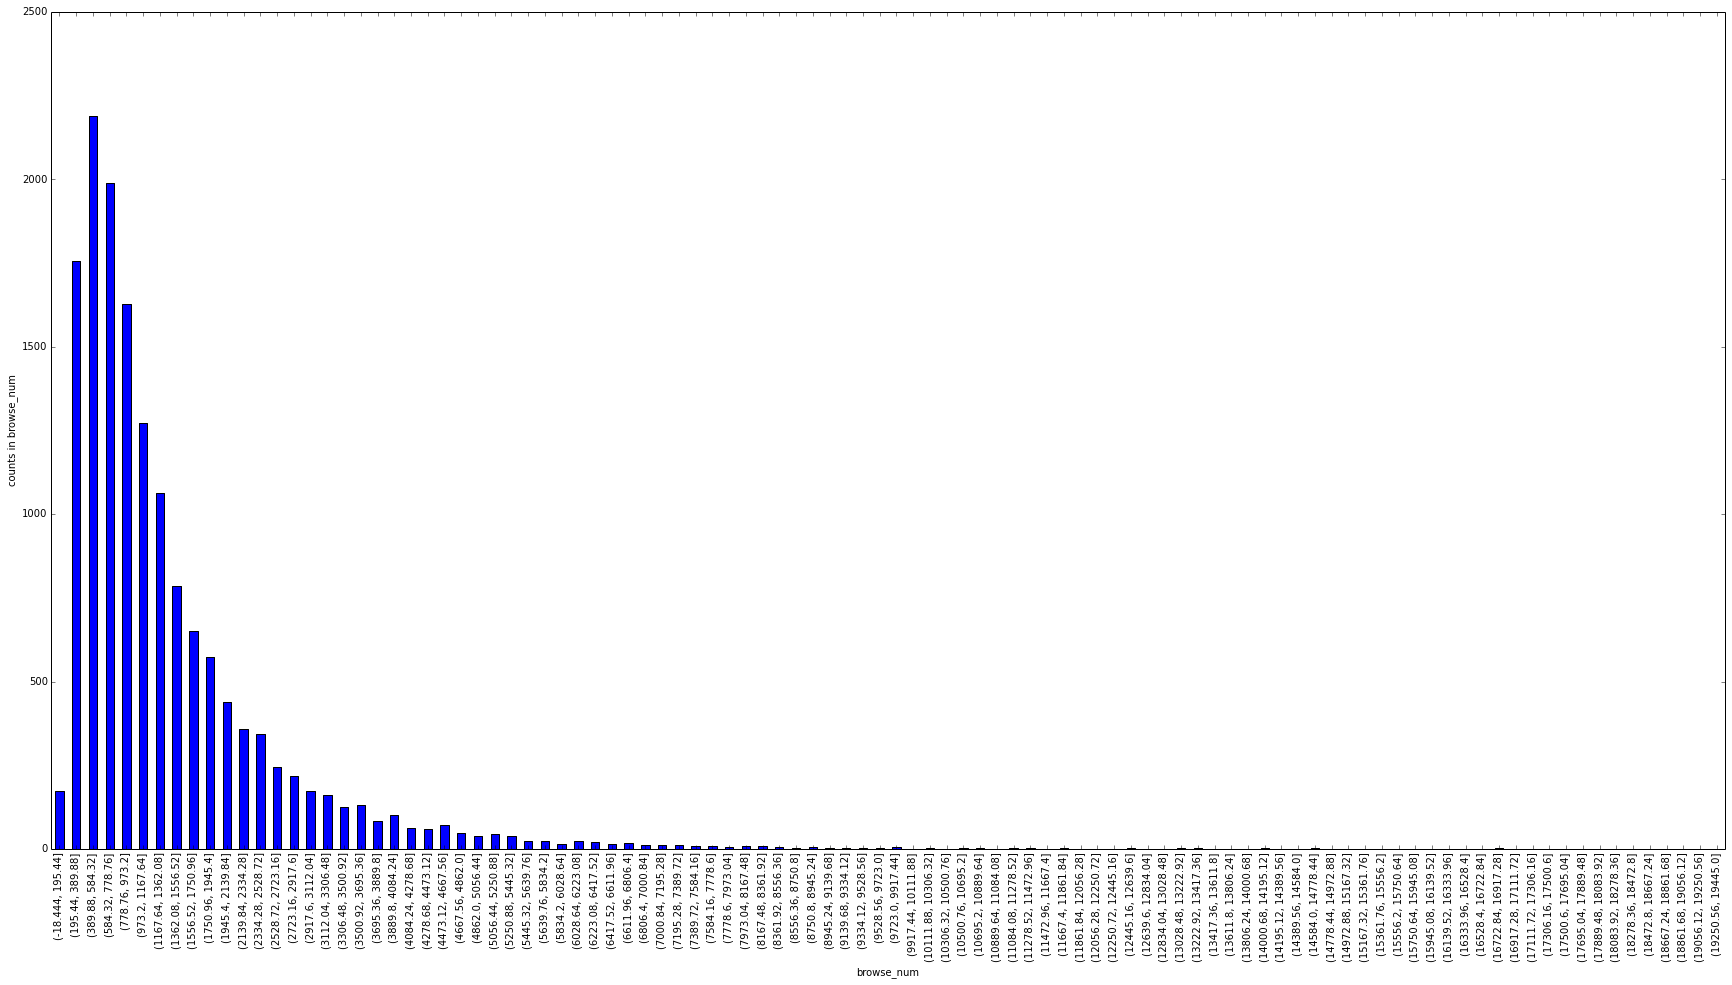

In [93]:
plot_data_cut(users, 'browse_num', 100)

In [94]:
def click_num_discretization(num):
    if 0 < num and num < 50:
        return 0
    elif 50 < num and num < 100:
        return 1
    elif 100 < num and num < 200:
        return 2
    elif 200 < num and num < 500:
        return 3
    elif 500 < num and num < 1000:
        return 4
    else:
        return 5

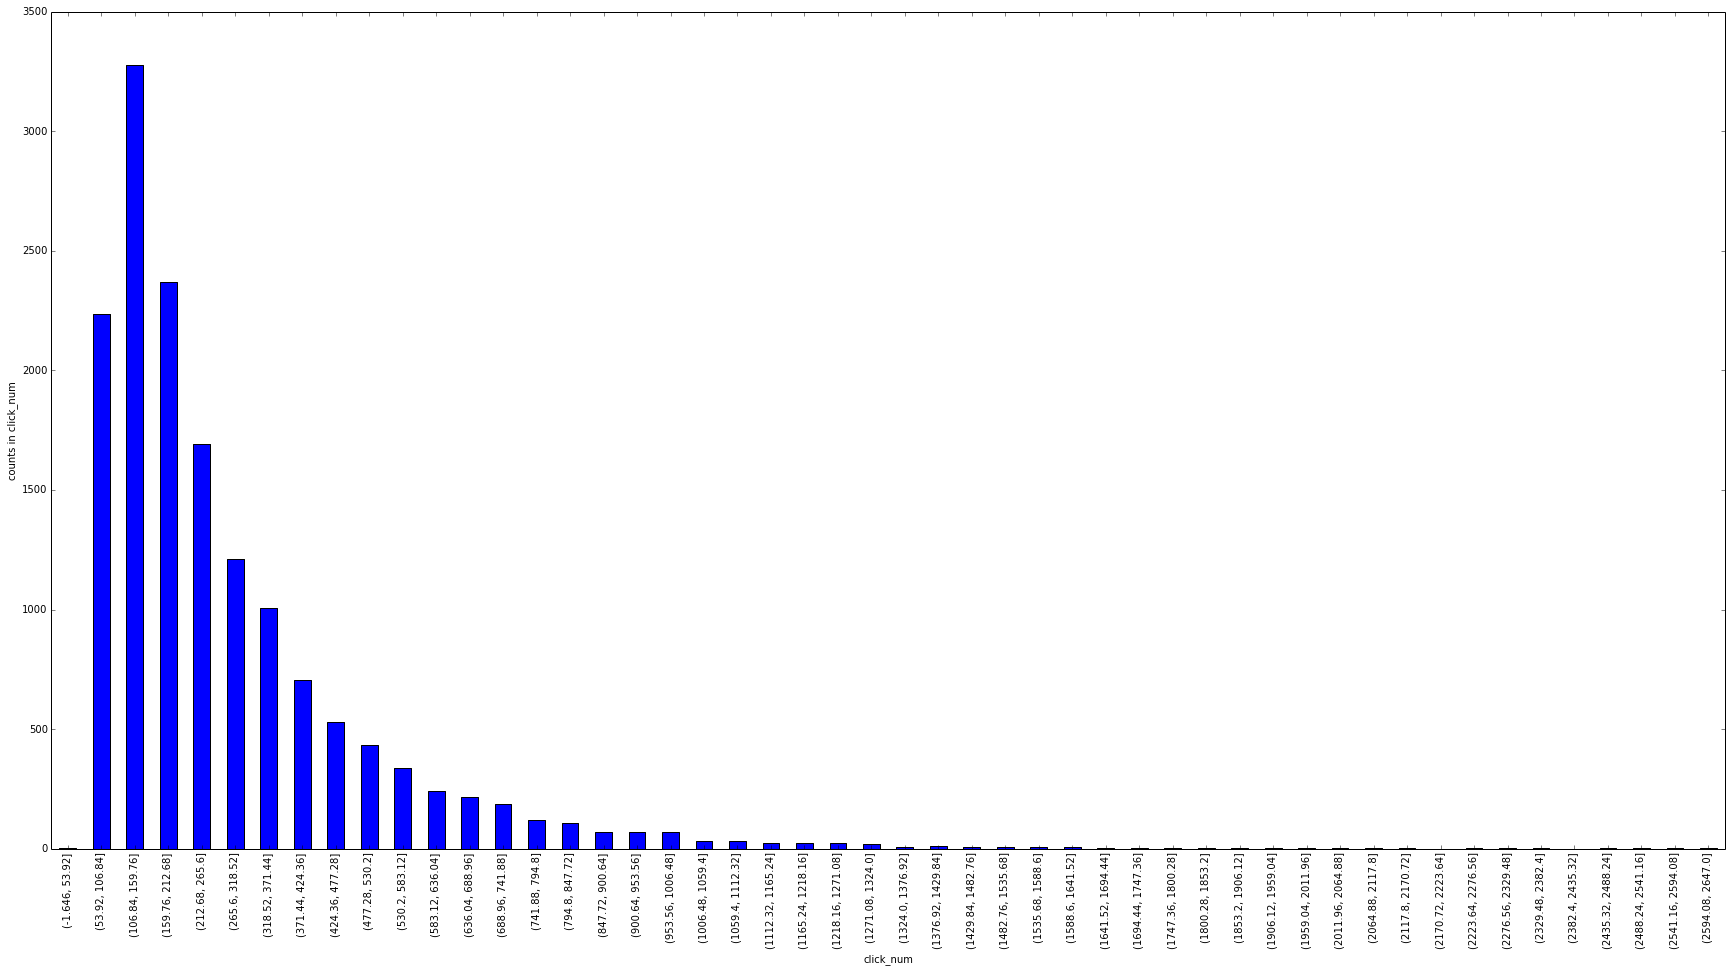

In [95]:
plot_data_cut(users, 'click_num', 50)

In [96]:
def like_num_discretization(num):
    if 0 < num and num < 10:
        return 0
    elif 10 < num and num < 20:
        return 1
    elif 20 < num and num < 30:
        return 3
    elif 30 < num and num < 40:
        return 4
    else:
        return 5

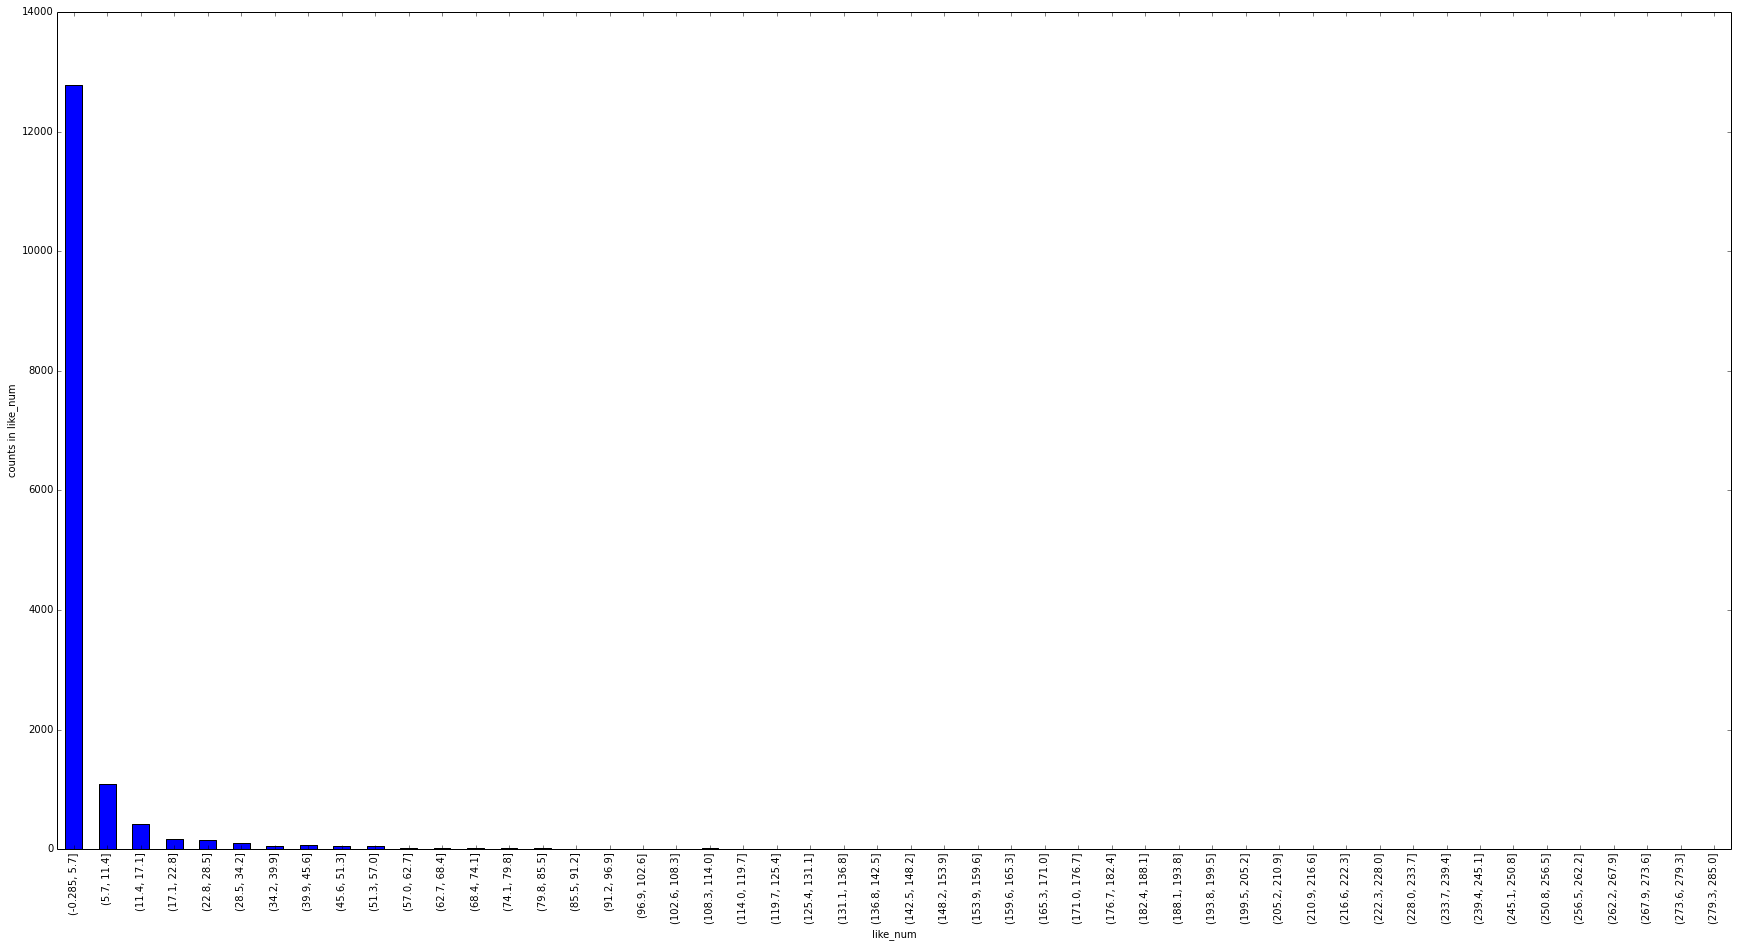

In [97]:
plot_data_cut(users, 'like_num', 50)

In [98]:
def follow_num_discretization(num):
    if 0 < num and num < 5:
        return 0
    elif 5 < num and num < 10:
        return 1
    elif 10 < num and num < 15:
        return 3
    elif 15 < num and num < 30:
        return 4
    else:
        return 5

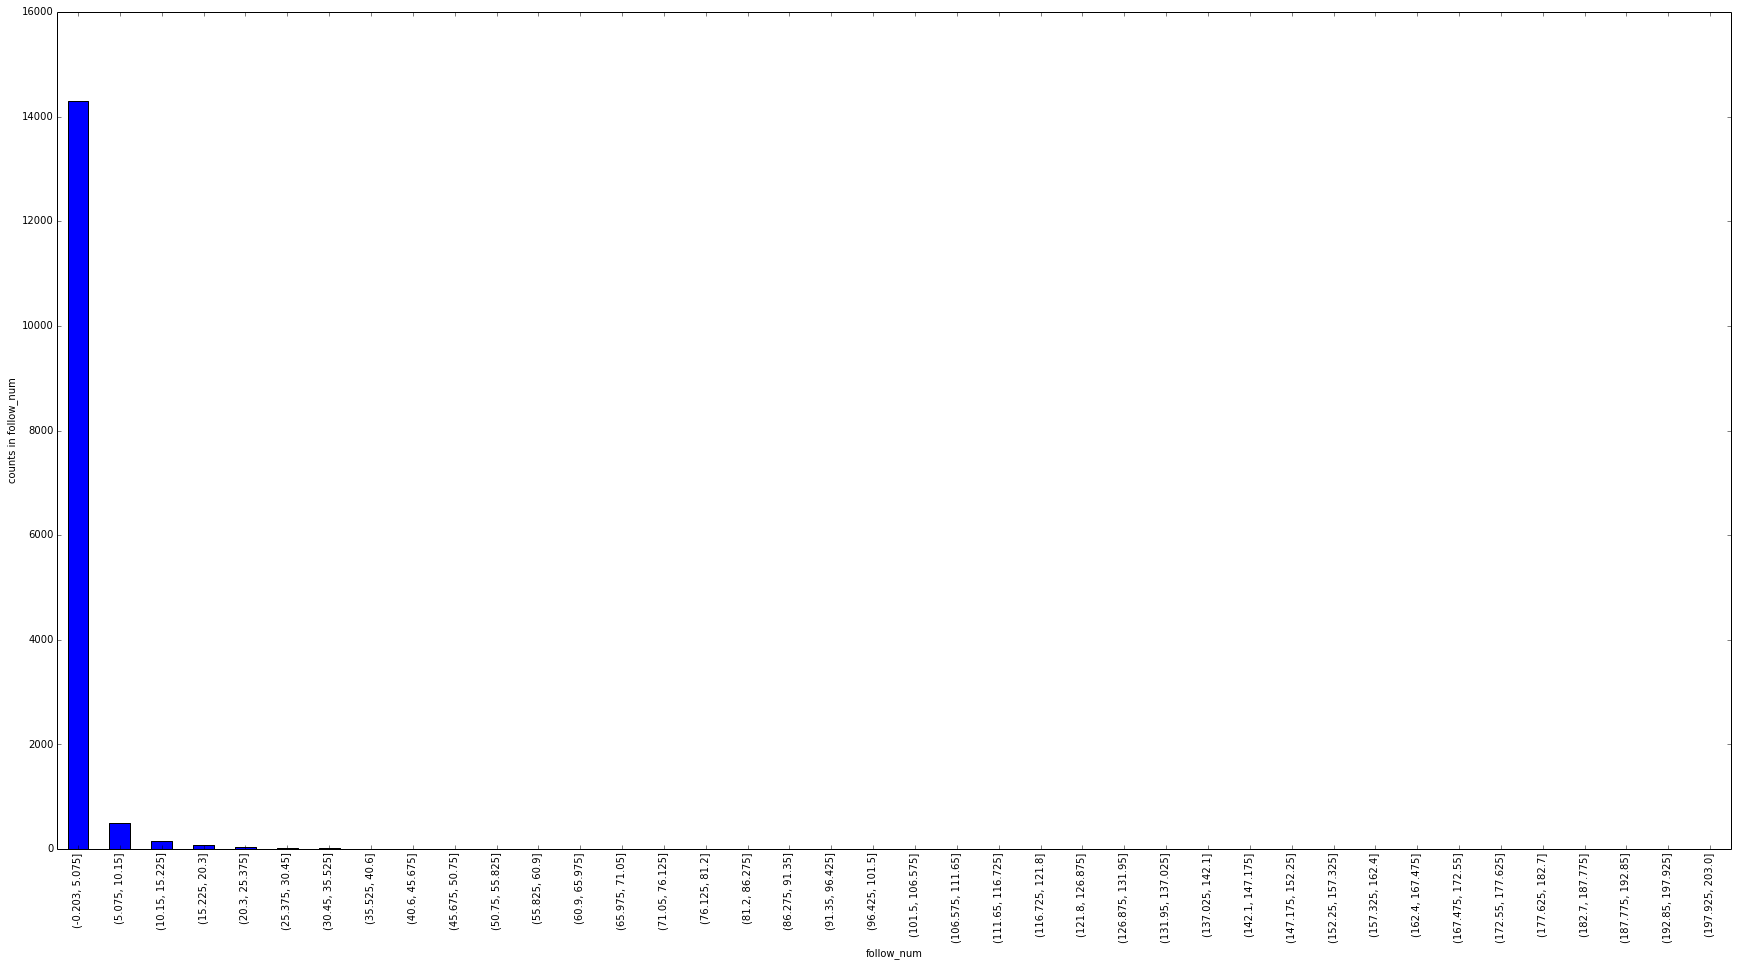

In [99]:
plot_data_cut(users, 'follow_num', 40)

In [100]:
def playing_sum_discretization(num):
    if 0 < num and num < 2000:
        return 0
    elif 2000 < num and num < 5000:
        return 1
    elif 5000 < num and num < 10000:
        return 2
    elif 10000 < num and num < 20000:
        return 3
    else:
        return 4

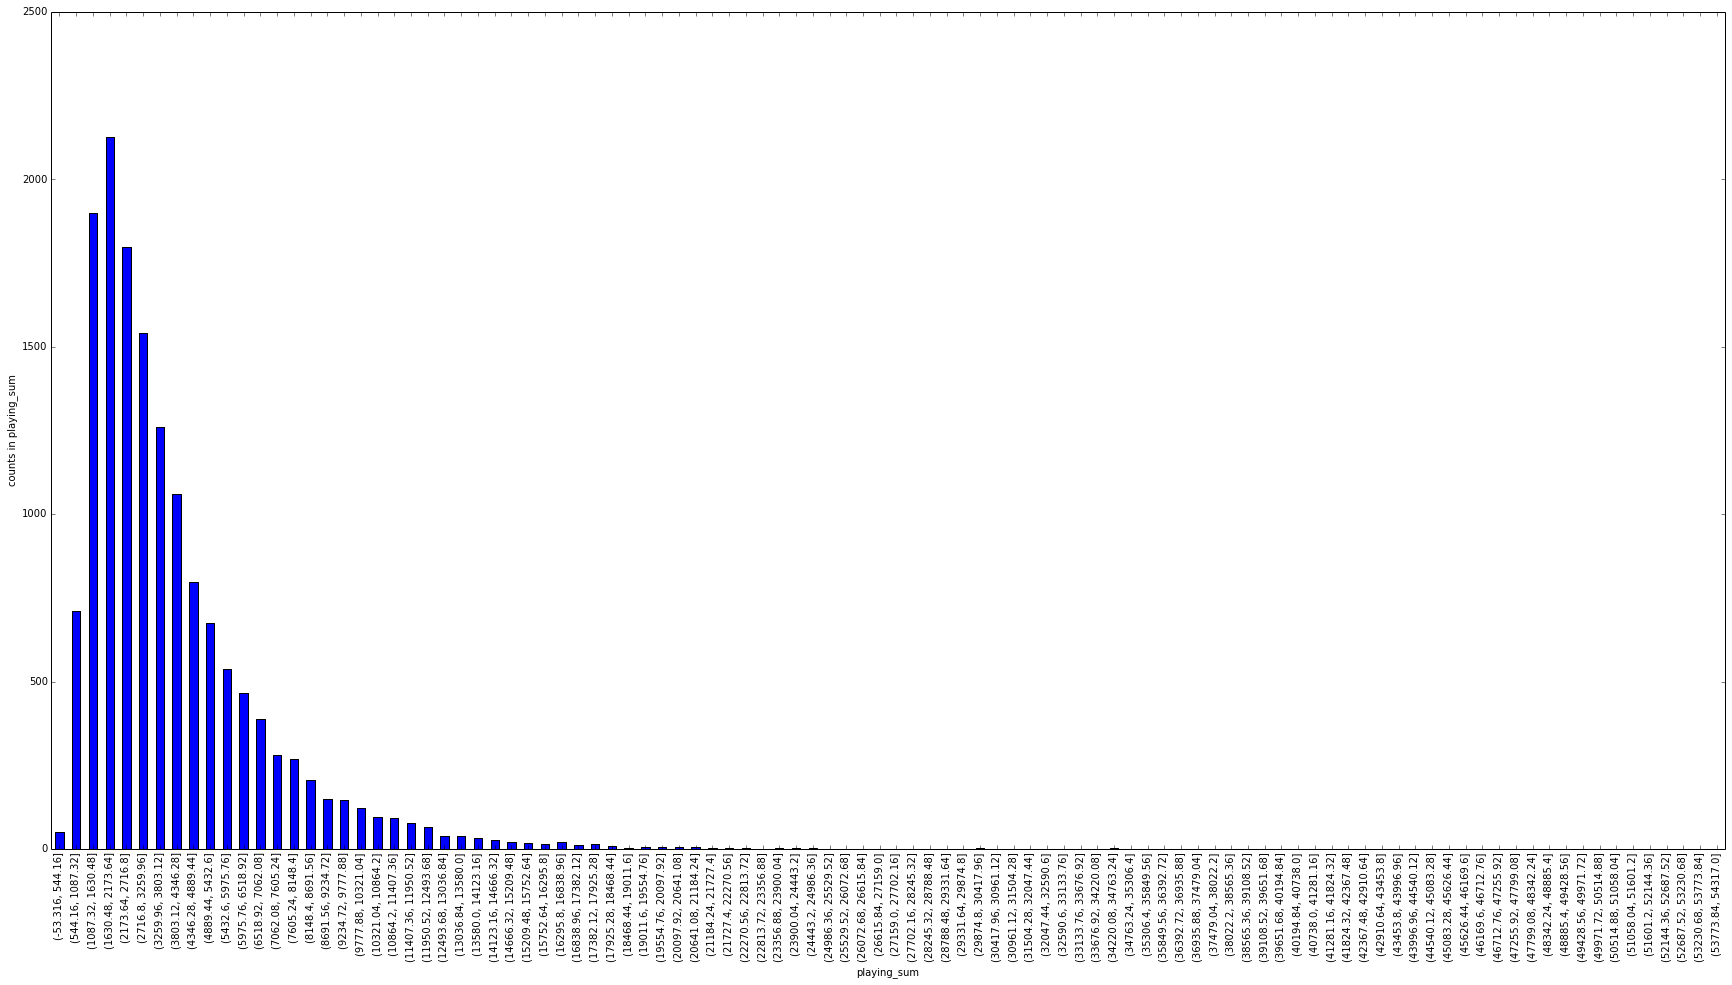

In [101]:
plot_data_cut(users, 'playing_sum', 100)

In [102]:
def duration_sum_discretization(num):
    if 1000 < num and num < 10000:
        return 0
    elif 10000 < num and num < 20000:
        return 1
    elif 20000 < num and num < 30000:
        return 2
    elif 30000 < num and num < 40000:
        return 3
    elif 40000 < num and num < 60000:
        return 4
    elif 60000 < num and num < 80000:
        return 5
    else:
        return 6

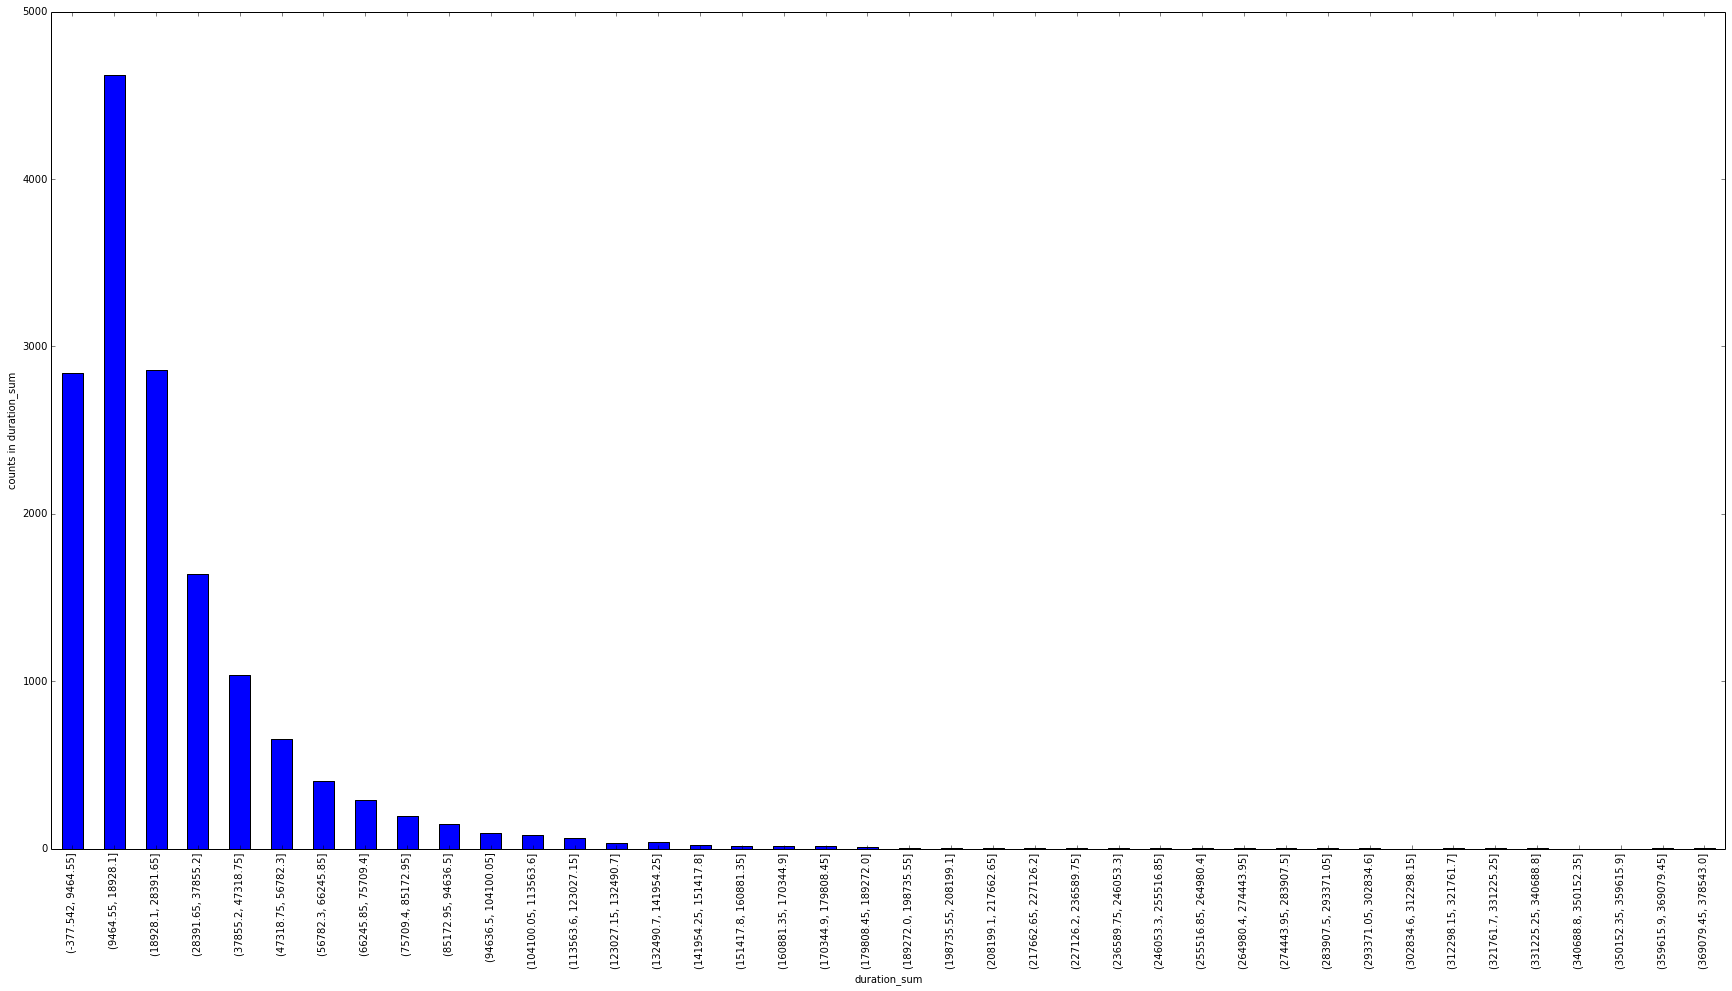

In [103]:
plot_data_cut(users, 'duration_sum', 40)

In [104]:
def click_ratio_discretization(num):
    if 0 < num and num < 0.1:
        return 0
    elif 0.1 < num and num < 0.2:
        return 1
    elif 0.2 < num and num < 0.4:
        return 2
    elif 0.4 < num and num < 0.6:
        return 3
    elif 0.6 < num and num < 0.8:
        return 4
    else:
        return 5

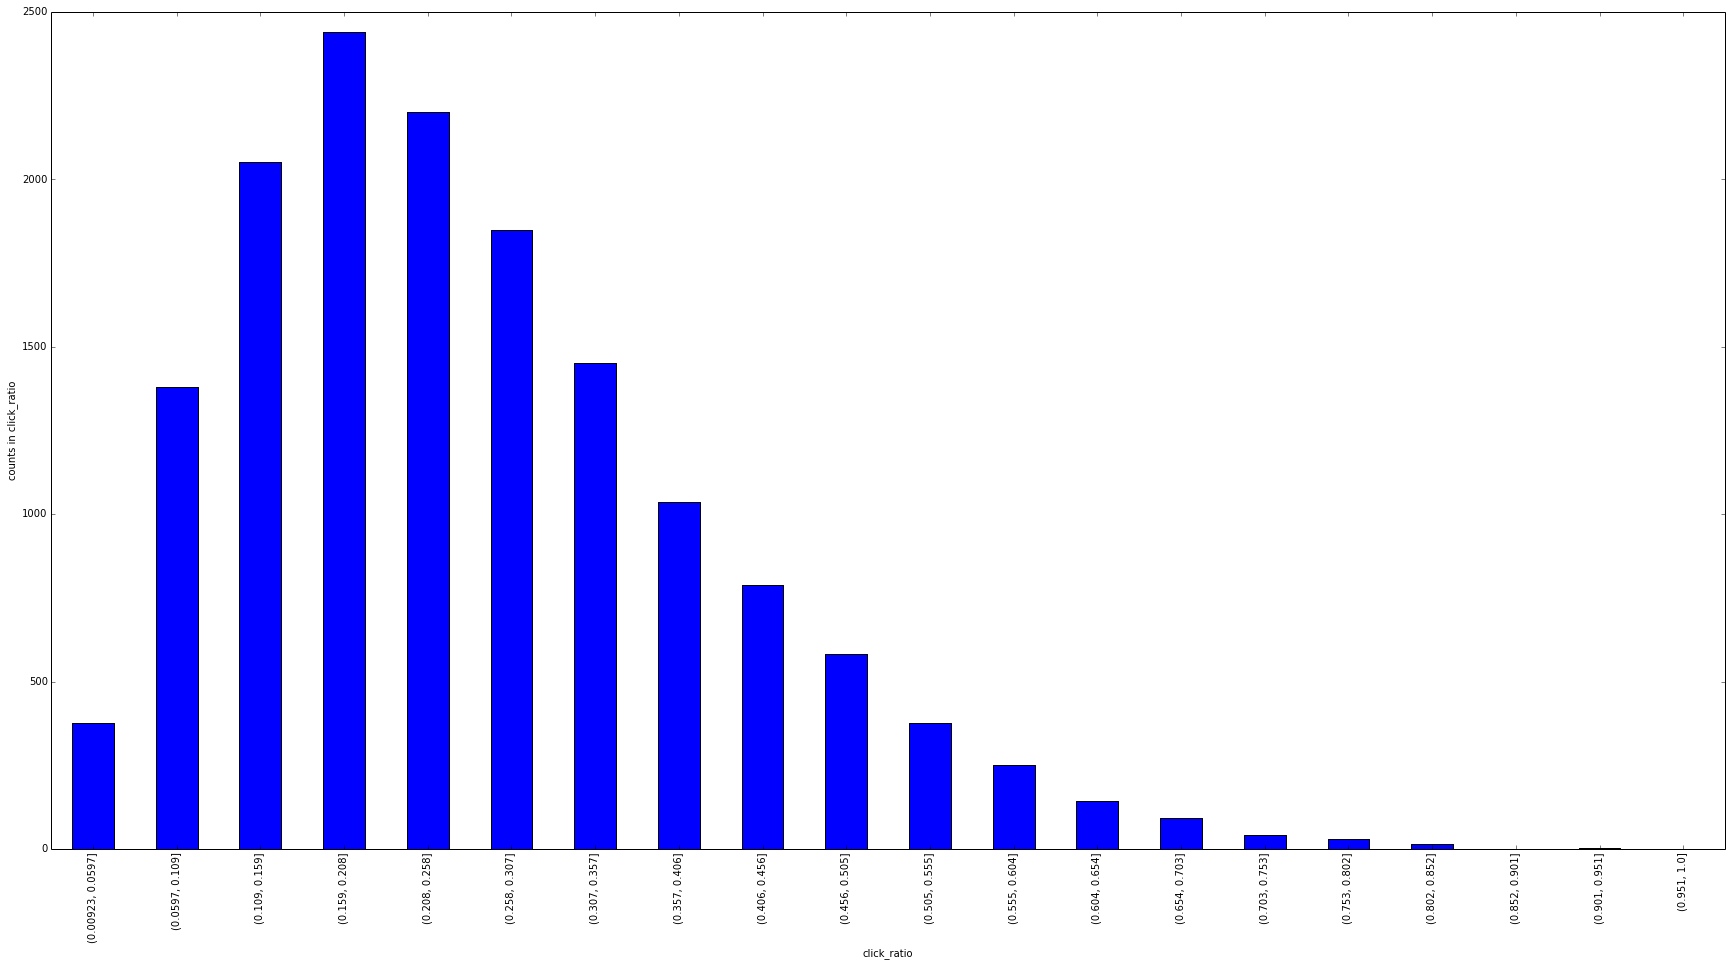

In [105]:
plot_data_cut(users, 'click_ratio', 20)

In [106]:
def like_ratio_discretization(num):
    if 0 < num and num < 0.02:
        return 0
    elif 0.02 < num and num < 0.04:
        return 1
    elif 0.04 < num and num < 0.06:
        return 2
    elif 0.06 < num and num < 0.1:
        return 3
    else:
        return 4

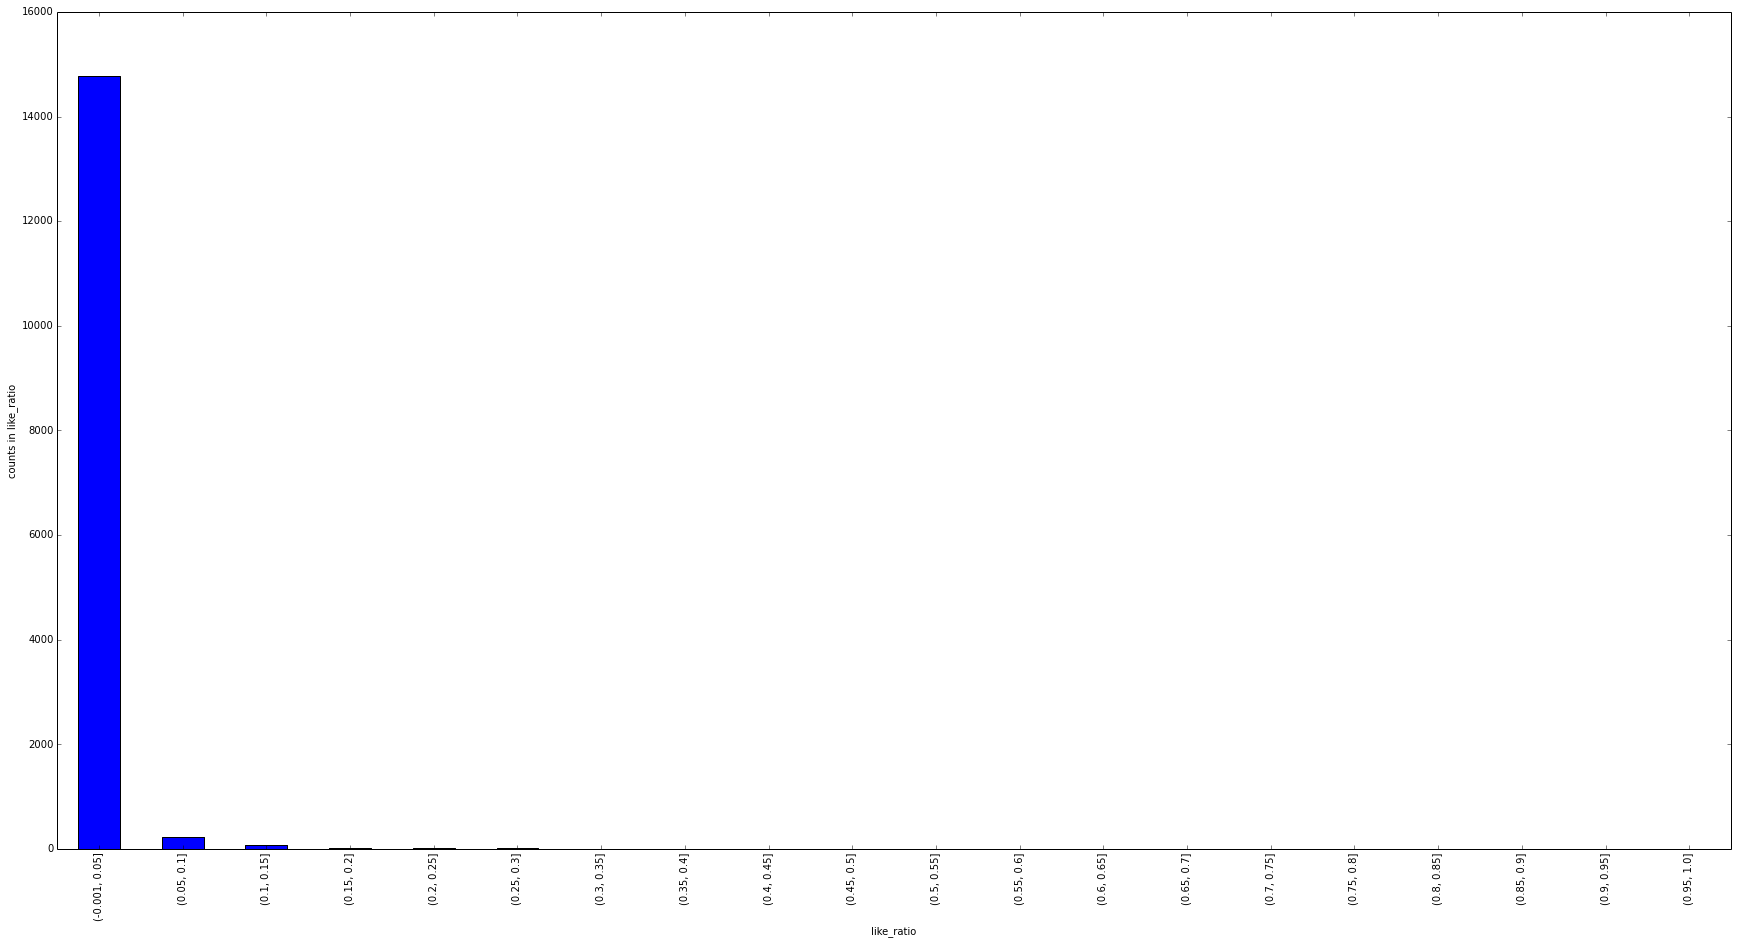

In [107]:
plot_data_cut(users, 'like_ratio', 20)

In [108]:
def follow_ratio_discretization(num):
    if 0 < num and num < 0.02:
        return 0
    elif 0.02 < num and num < 0.04:
        return 1
    elif 0.04 < num and num < 0.06:
        return 2
    else:
        return 3

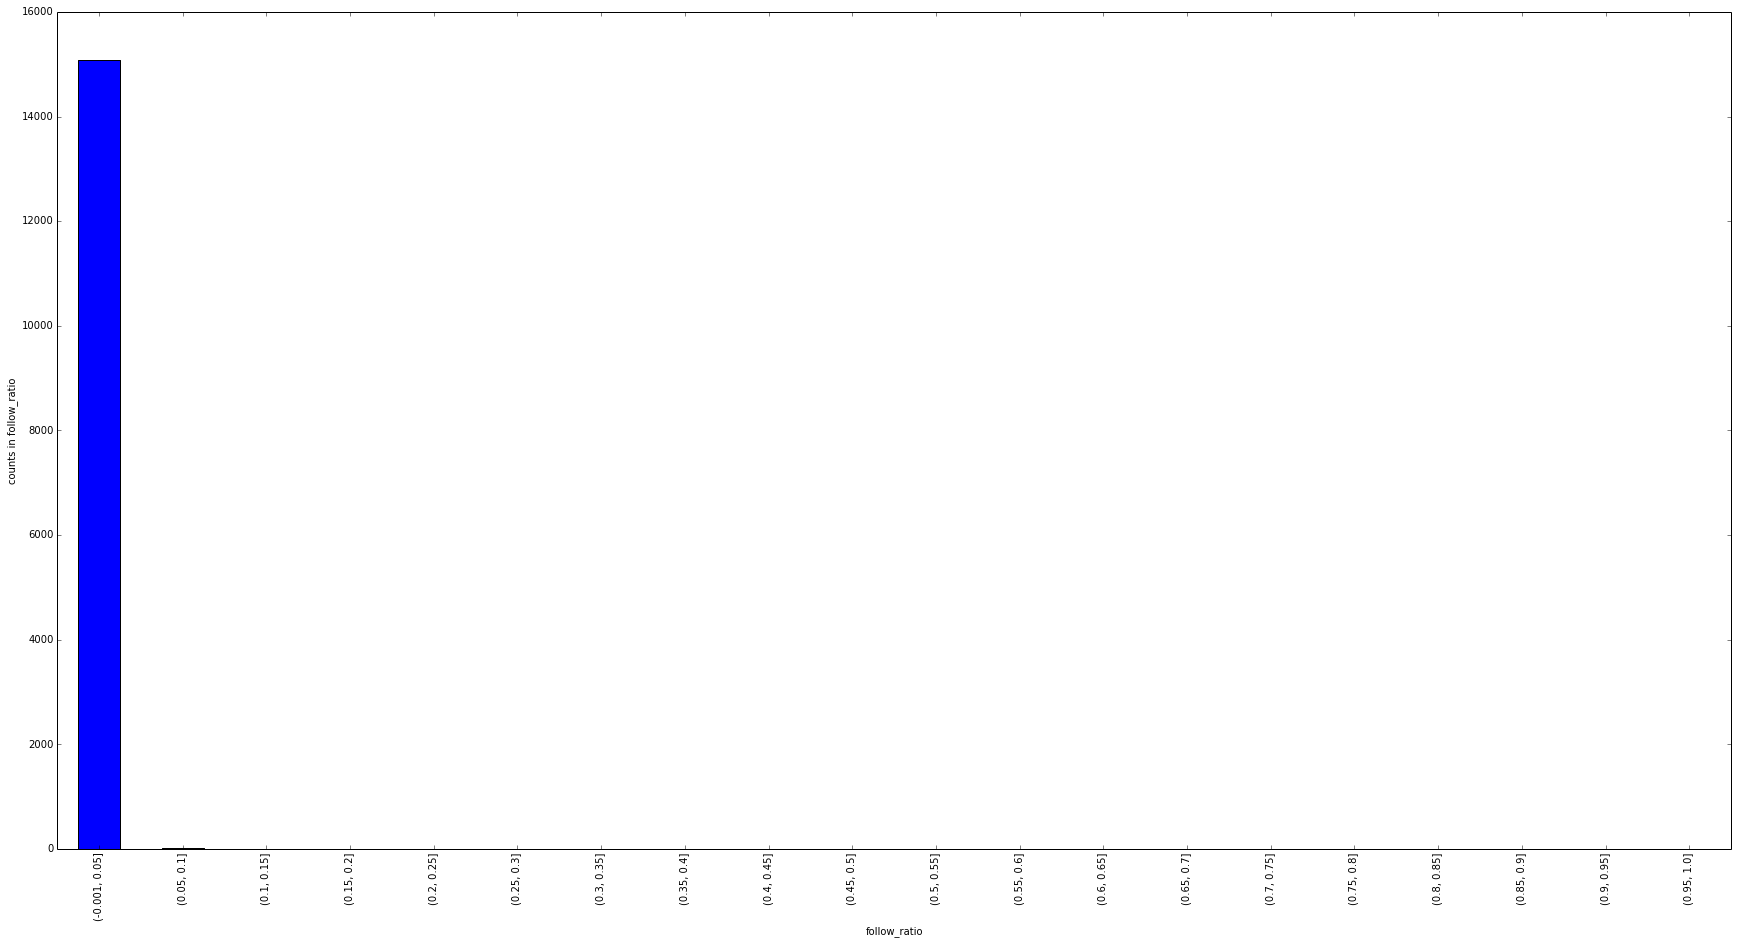

In [109]:
plot_data_cut(users, 'follow_ratio', 20)

In [110]:
def playing_ratio_discretization(num):
    if 0 < num and num < 0.2:
        return 0
    elif 0.2 < num and num < 0.4:
        return 1
    elif 0.4 < num and num < 0.6:
        return 2
    else:
        return 3

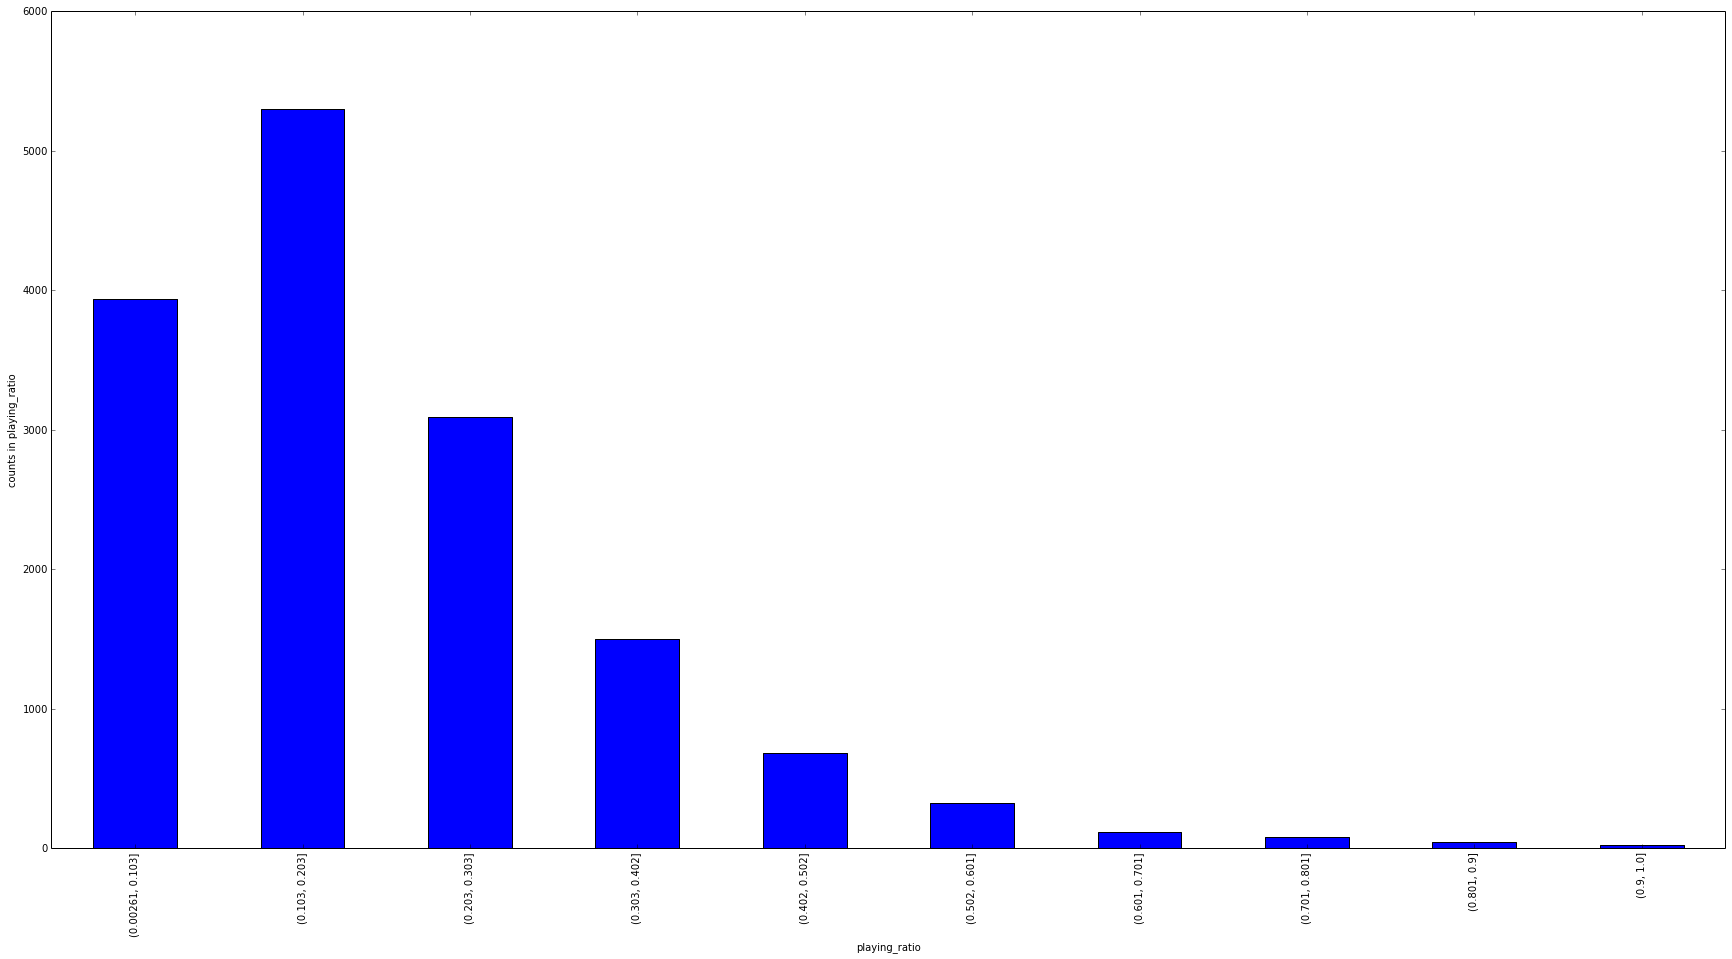

In [111]:
plot_data_cut(users, 'playing_ratio', 10)

In [112]:
def face_favor_discretization(num):
    if 0 < num and num < 1:
        return 0
    elif 1 < num and num < 2:
        return 1
    else:
        return 2

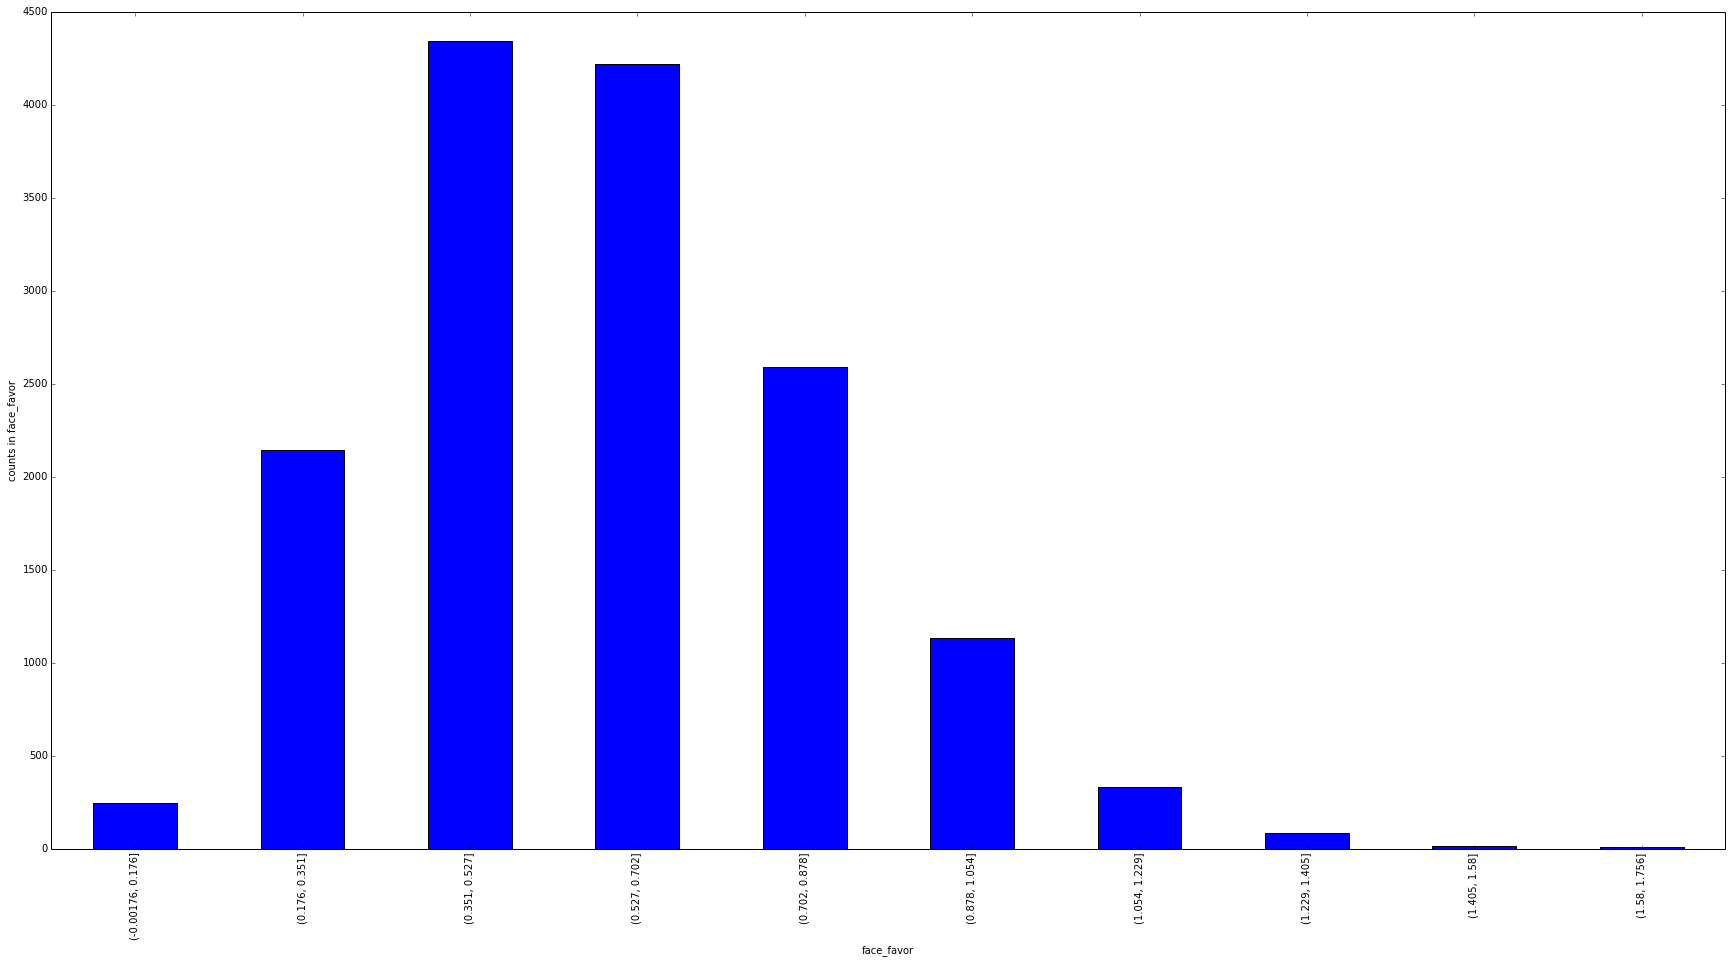

In [113]:
plot_data_cut(users, 'face_favor', 10)

In [114]:
def man_favor_discretization(num):
    if 0 < num and num < 1:
        return 0
    elif 1 < num and num < 2:
        return 1
    else:
        return 2

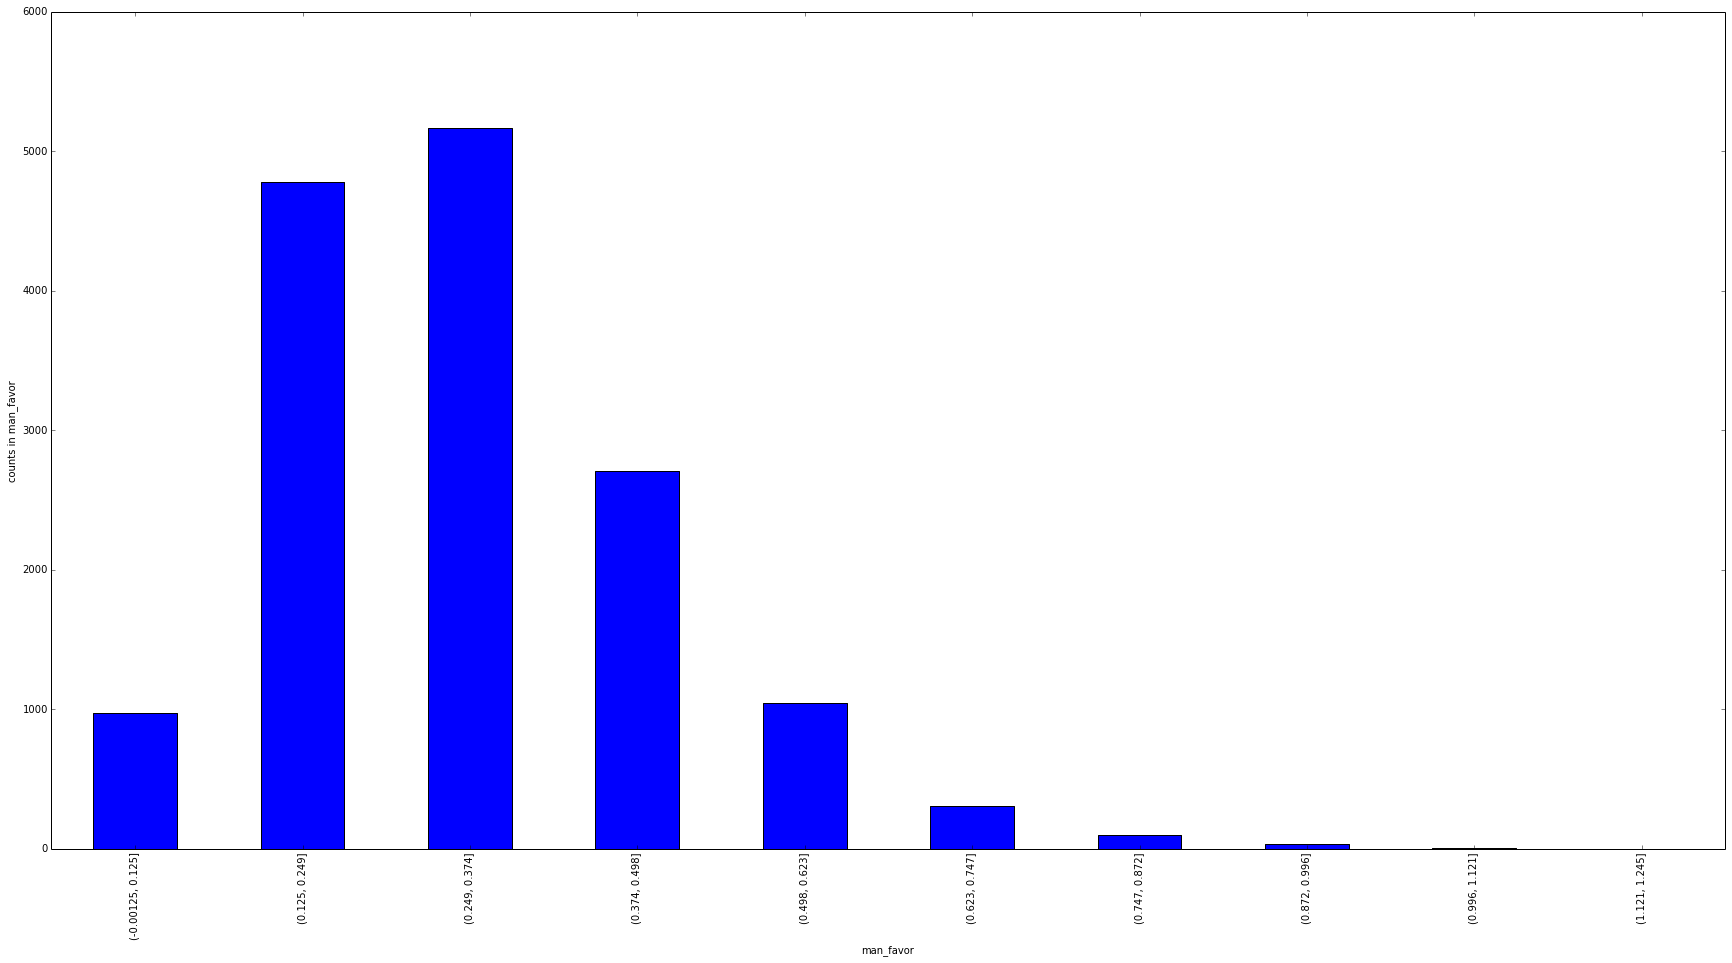

In [115]:
plot_data_cut(users, 'man_favor', 10)

In [116]:
def woman_favor_discretization(num):
    if 0 < num and num < 1:
        return 0
    elif 1 < num and num < 2:
        return 1
    else:
        return 2

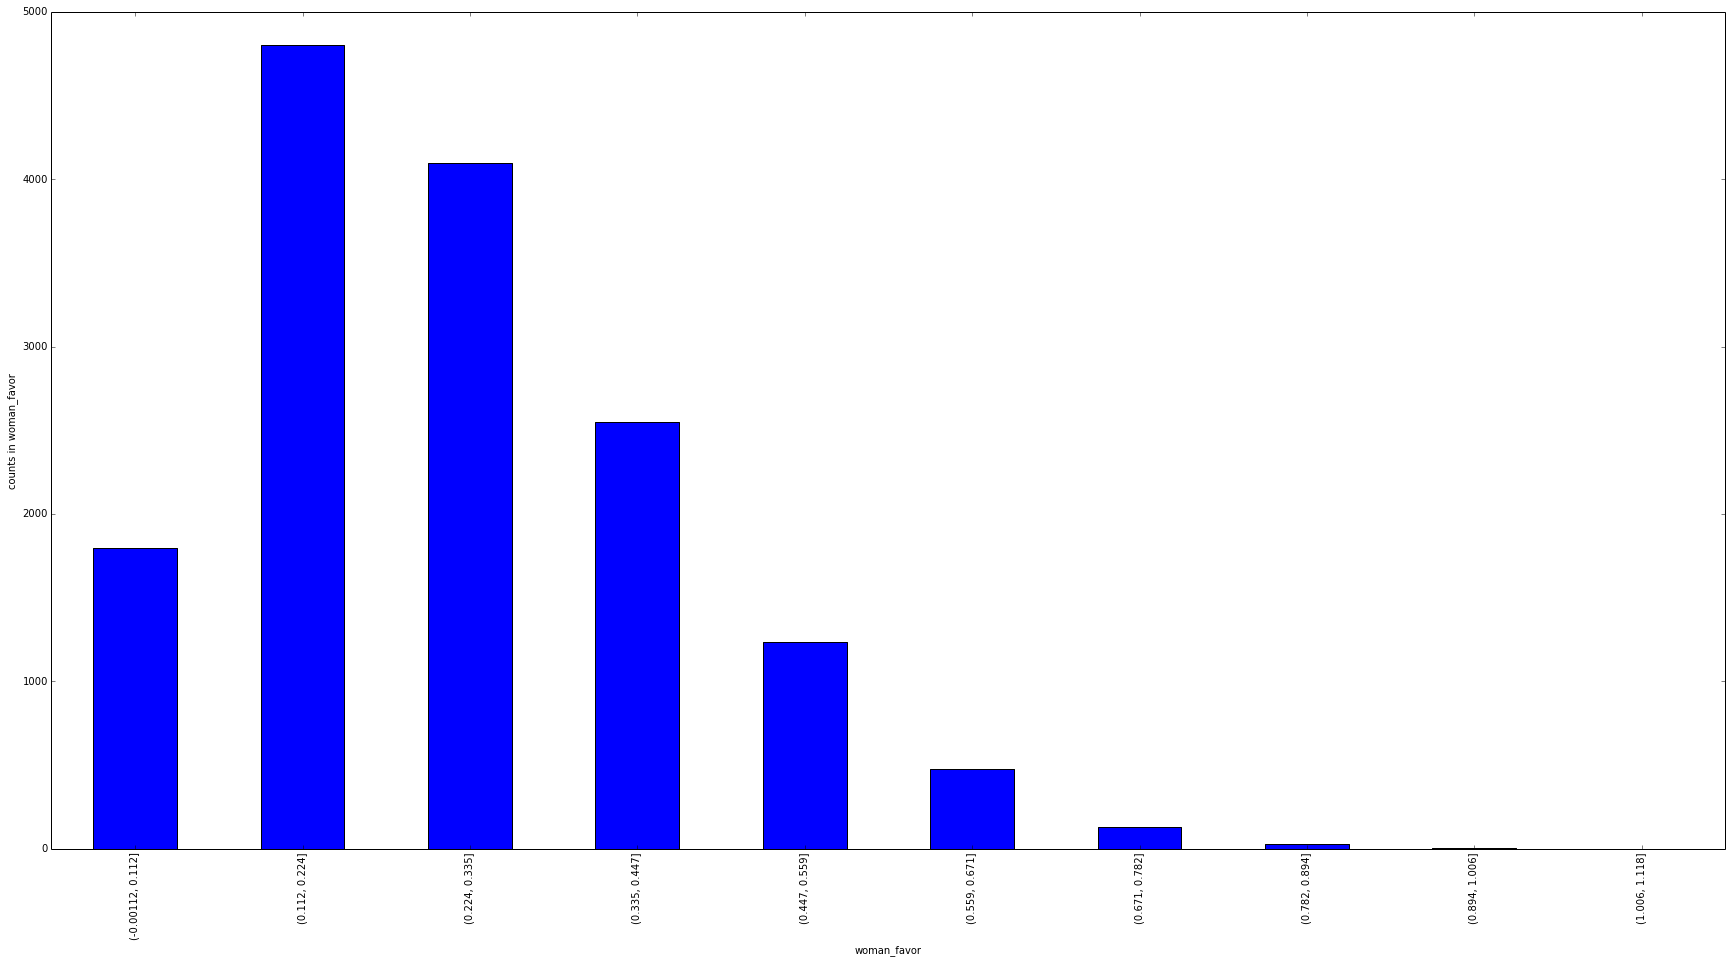

In [117]:
plot_data_cut(users, 'woman_favor', 10)

In [118]:
def man_cv_favor_discretization(num):
    if 0 < num and num < 0.02:
        return 0
    elif 0.02 < num and num < 0.04:
        return 1
    elif 0.04 < num and num < 0.06:
        return 2
    else:
        return 3

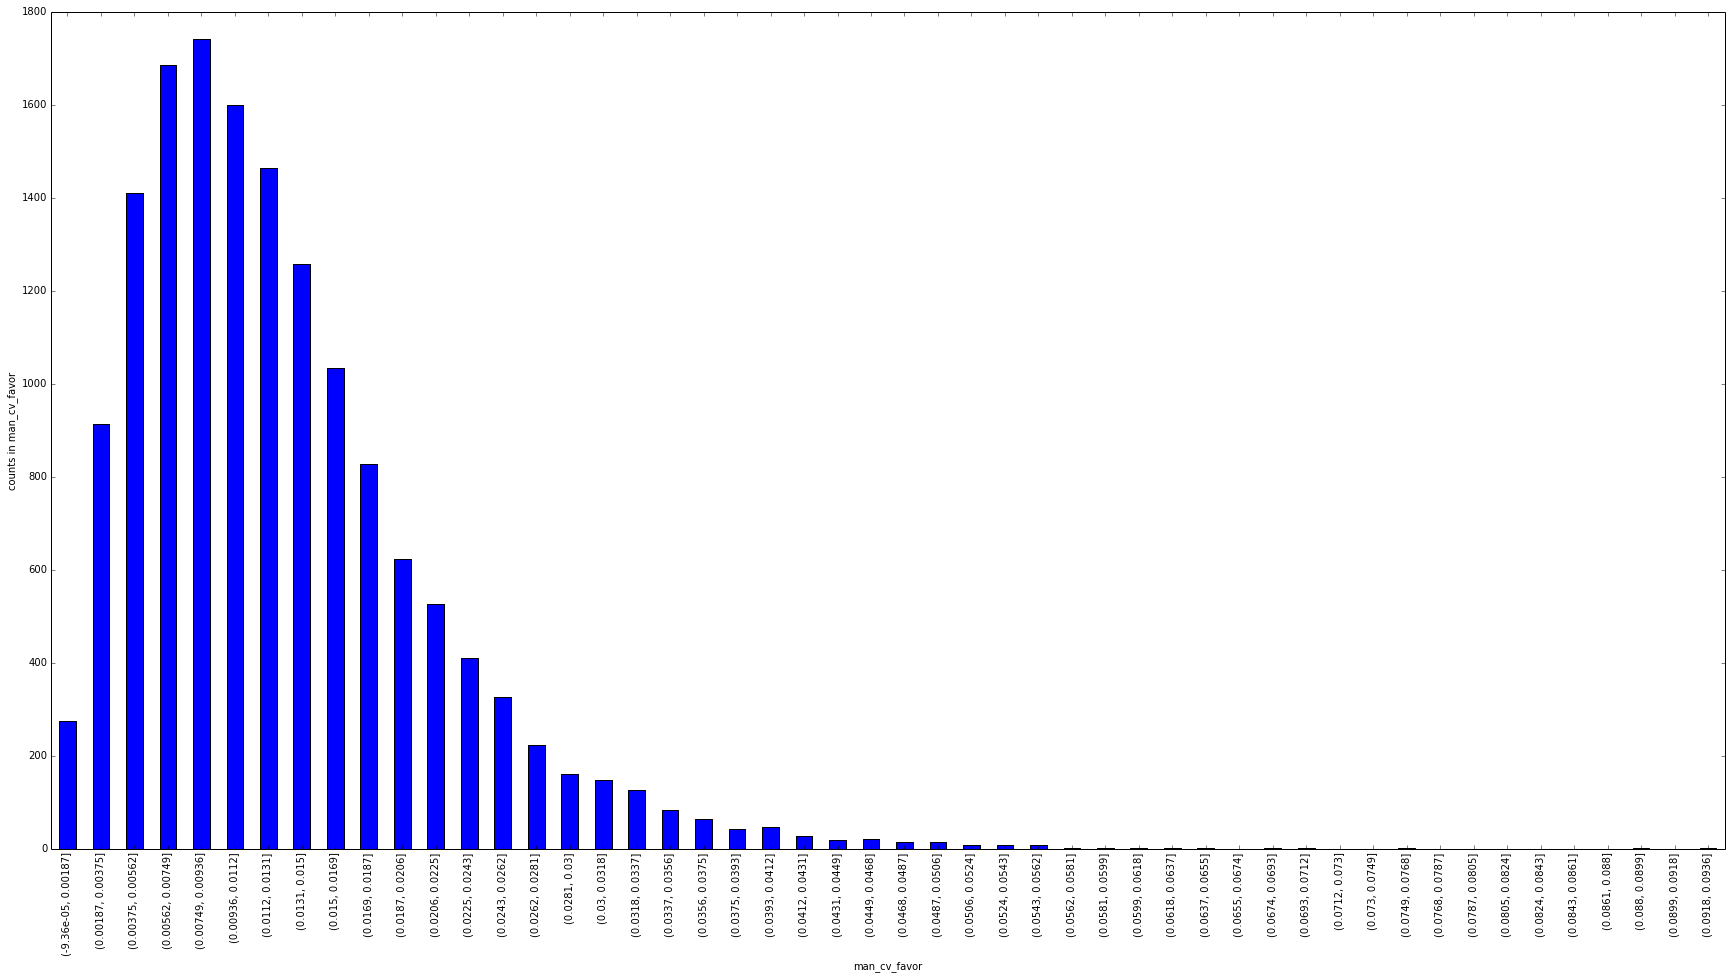

In [119]:
plot_data_cut(users, 'man_cv_favor', 50)

In [120]:
def woman_cv_favor_discretization(num):
    if 0 < num and num < 0.03:
        return 0
    elif 0.03 < num and num < 0.06:
        return 1
    elif 0.06 < num and num < 0.1:
        return 2
    else:
        return 3

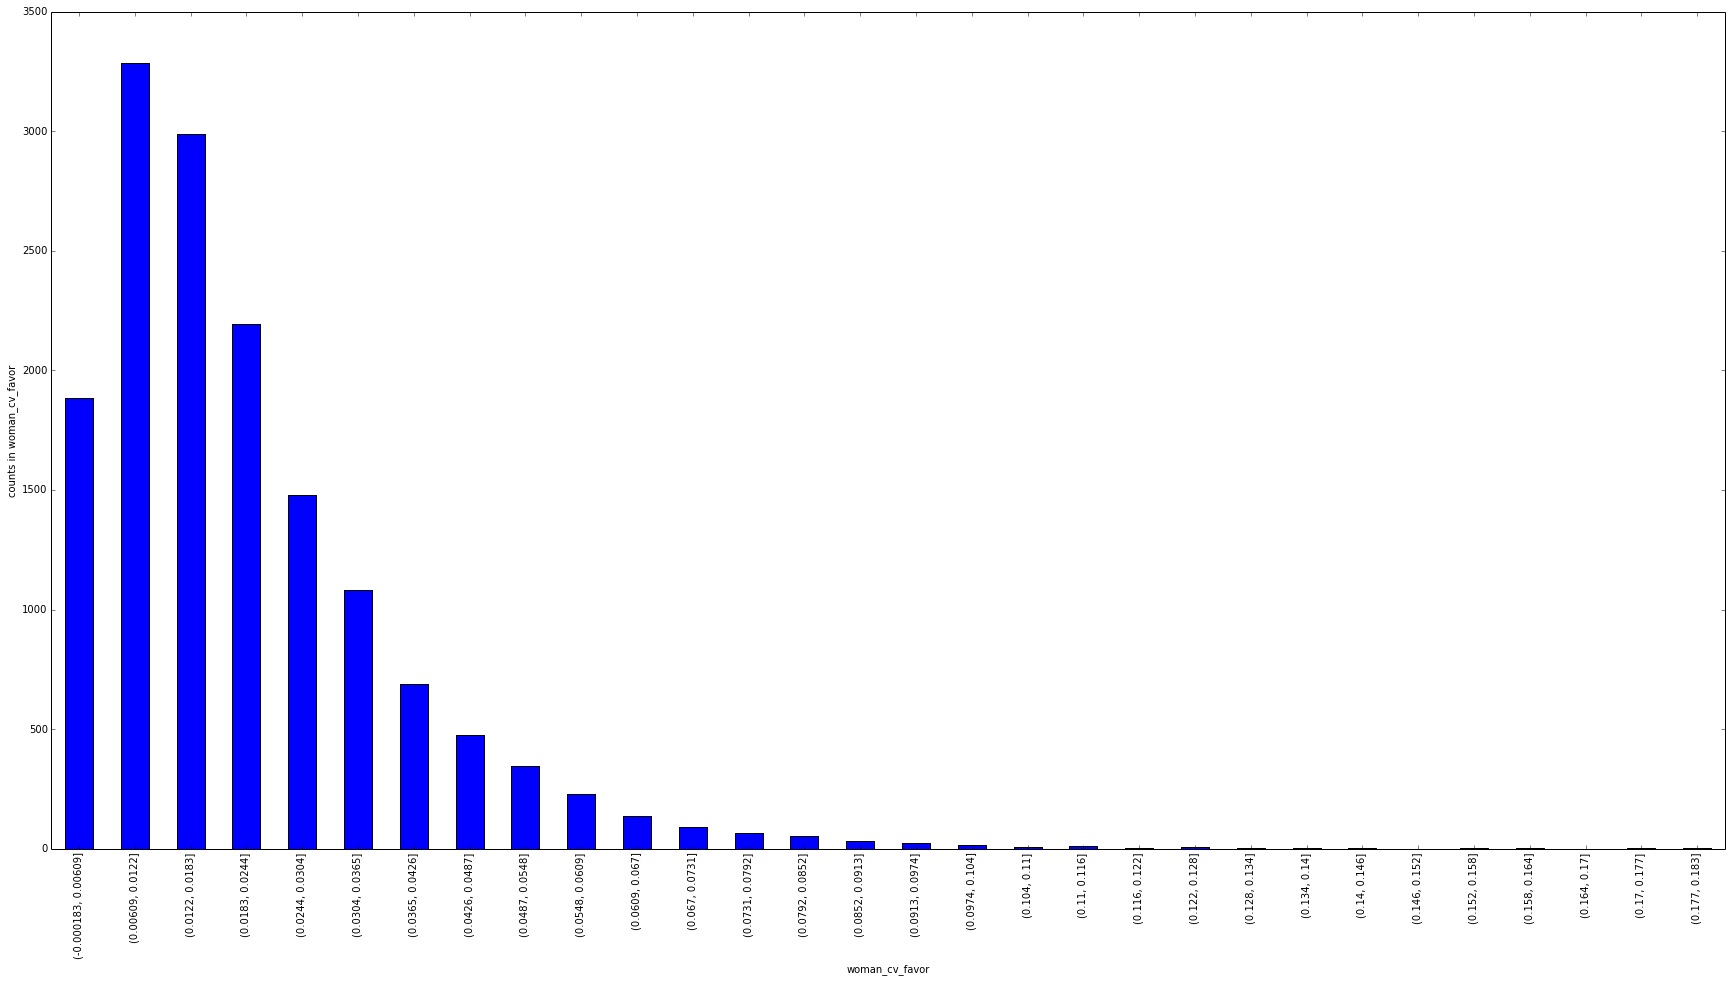

In [121]:
plot_data_cut(users, 'woman_cv_favor', 30)

In [122]:
def man_age_favor_discretization(num):
    if 0 < num and num < 4:
        return 0
    elif 4 < num and num < 8:
        return 1
    elif 8 < num and num < 12:
        return 2
    else:
        return 3

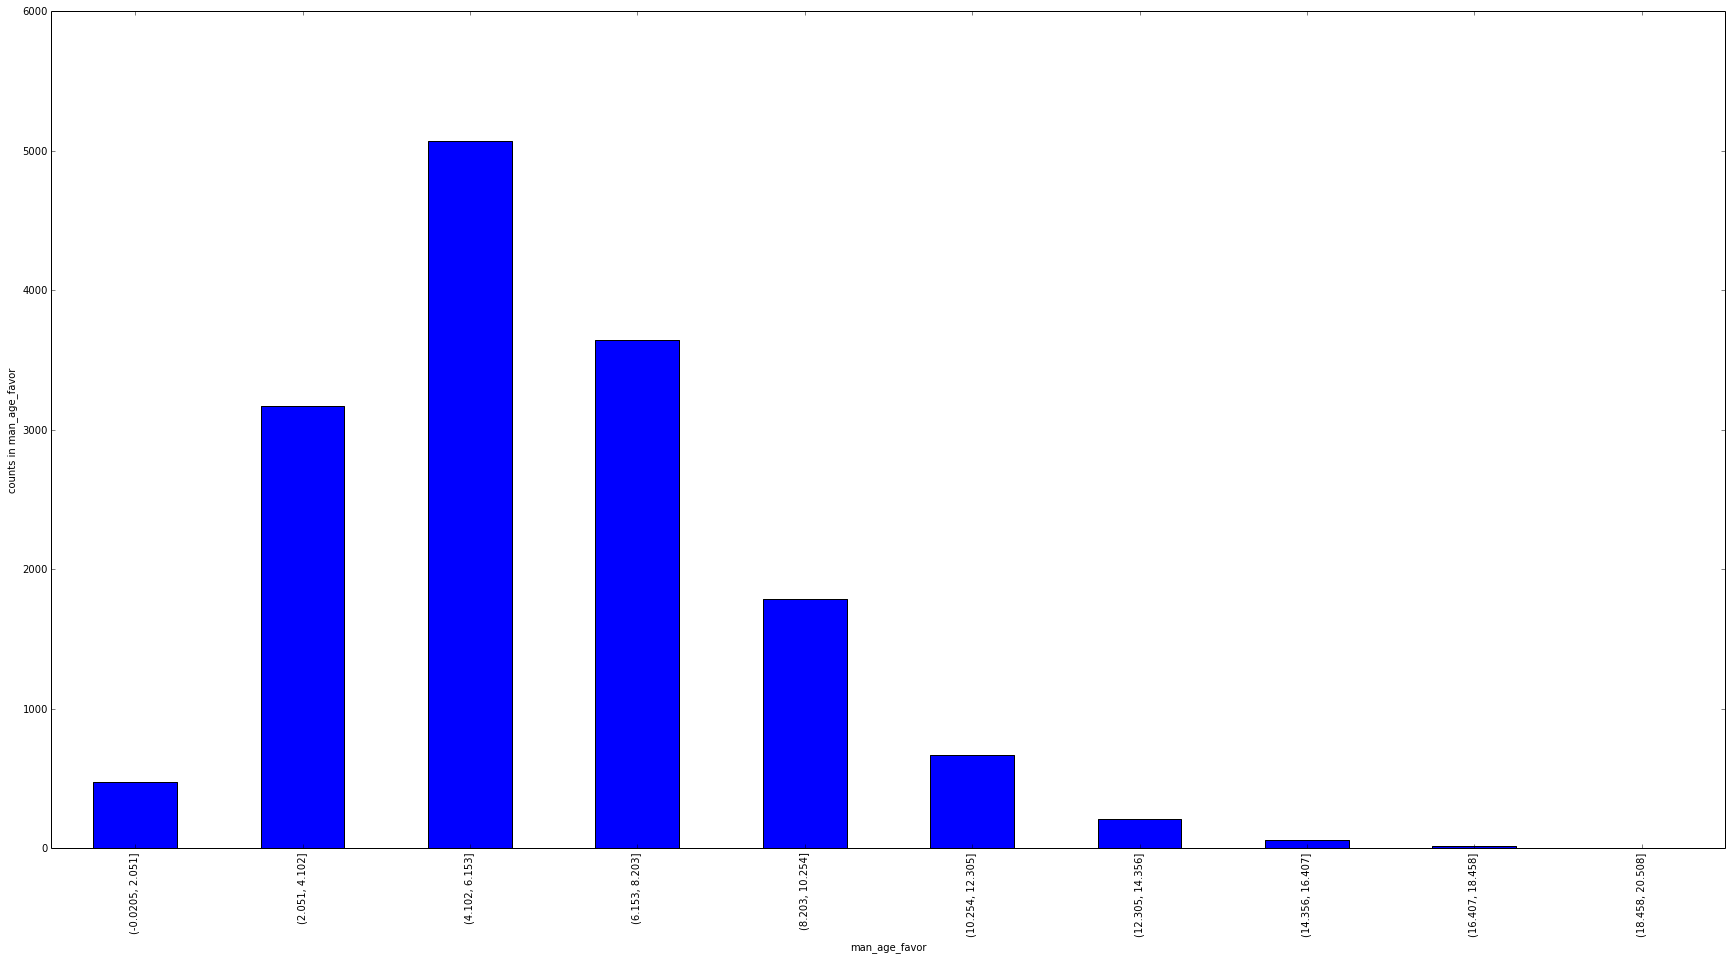

In [123]:
plot_data_cut(users, 'man_age_favor', 10)

In [124]:
def woman_age_favor_discretization(num):
    if 0 < num and num < 4:
        return 0
    elif 4 < num and num < 8:
        return 1
    elif 8 < num and num < 12:
        return 2
    else:
        return 3

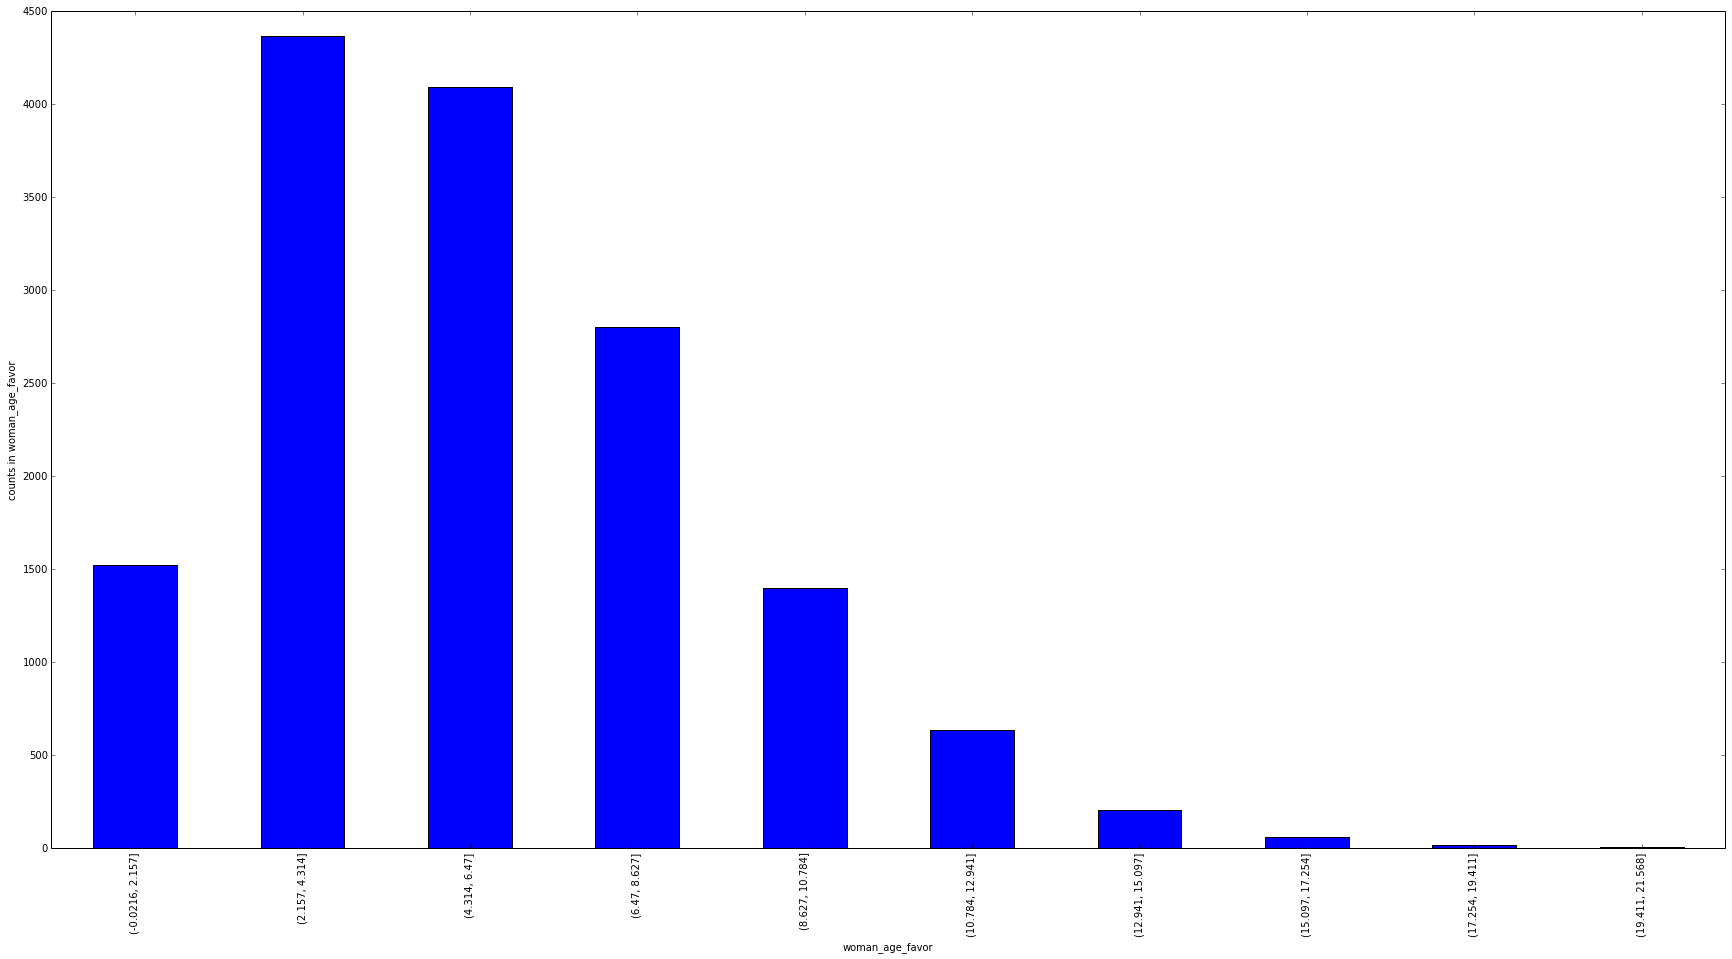

In [125]:
plot_data_cut(users, 'woman_age_favor', 10)

In [126]:
def man_yen_value_favor_discretization(num):
    if 0 < num and num < 10:
        return 0
    elif 10 < num and num < 20:
        return 1
    else:
        return 2

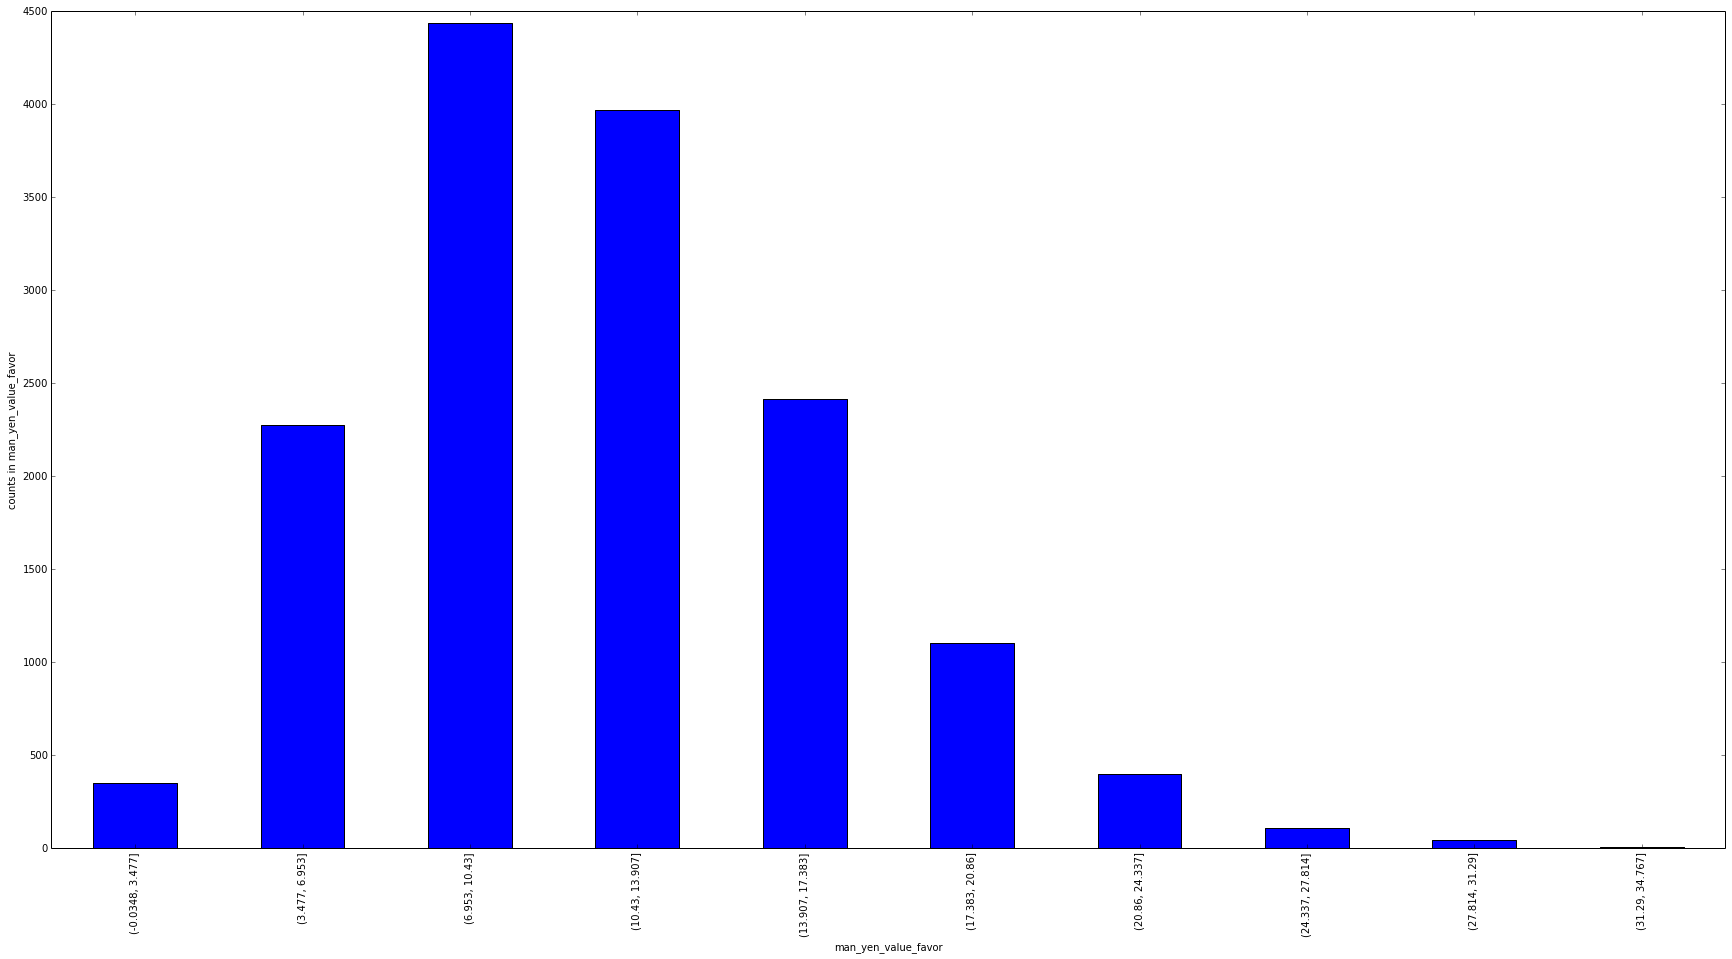

In [127]:
plot_data_cut(users, 'man_yen_value_favor', 10)

In [128]:
def woman_yen_value_favor_discretization(num):
    if 0 < num and num < 10:
        return 0
    elif 10 < num and num < 20:
        return 1
    elif 20 < num and num < 40:
        return 2
    else:
        return 3

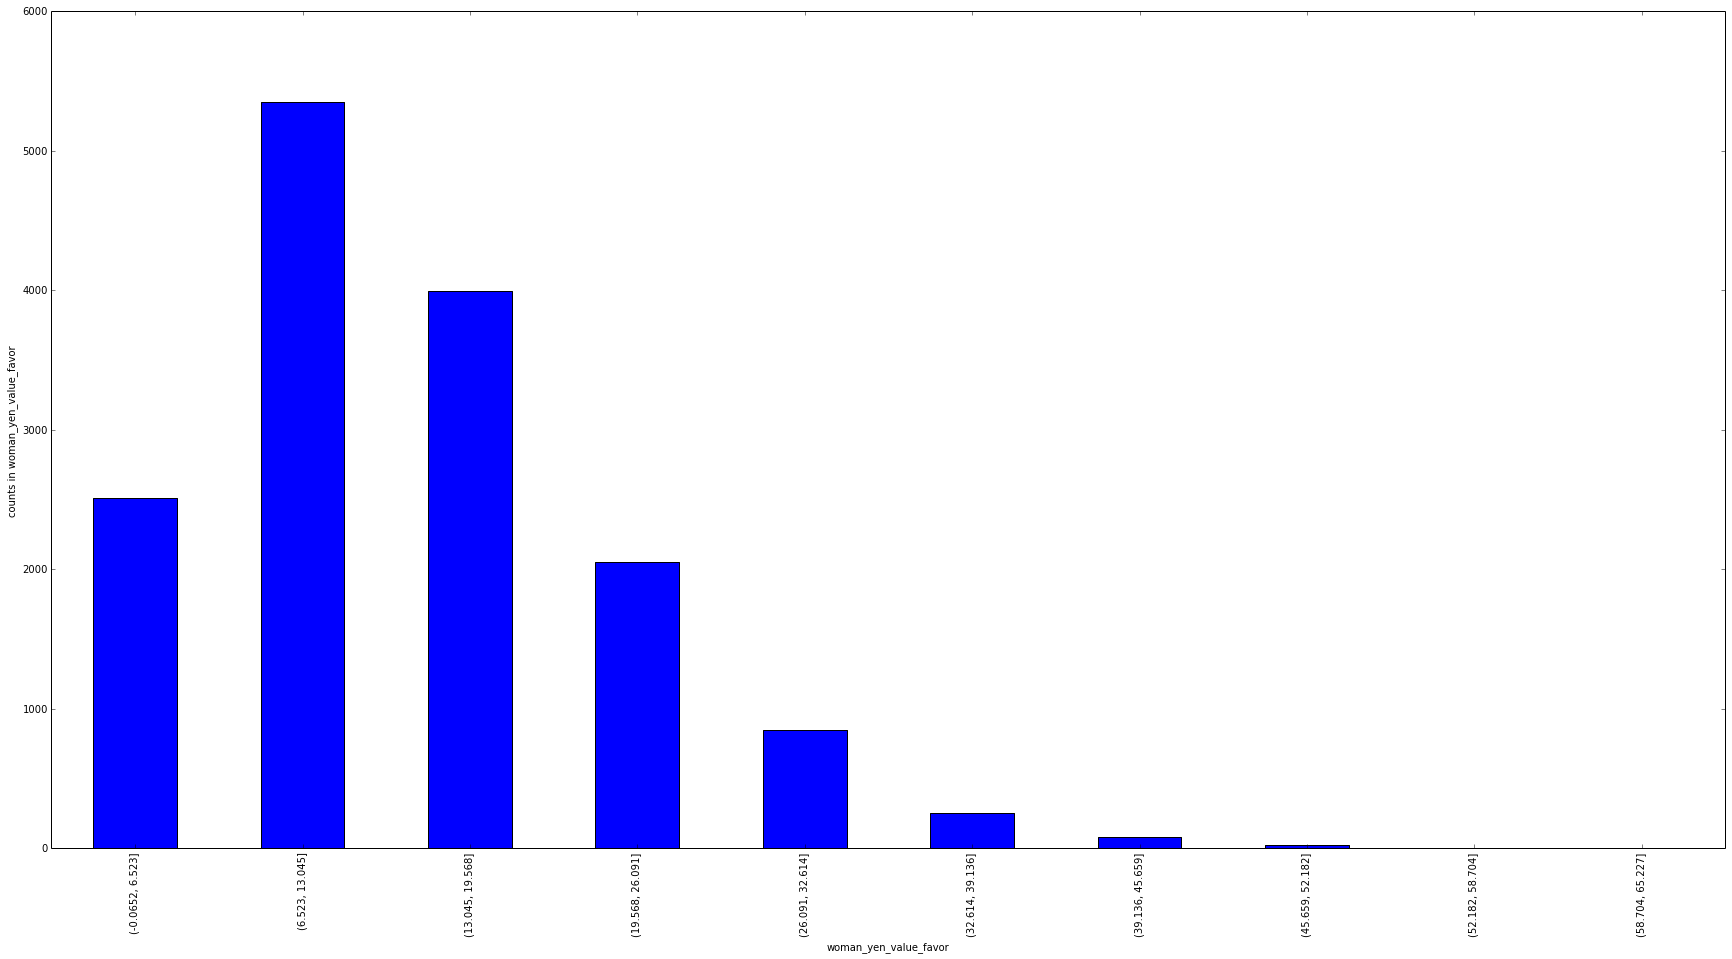

In [129]:
plot_data_cut(users, 'woman_yen_value_favor', 10)

In [130]:
users.head()

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
0,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.000000,0.148741,0.997260,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
1,17470,477,82,0,1,1937,8586,0.171908,0.000000,0.002096,0.225600,0.426829,0.268293,0.158537,0.006262,0.014798,5.912602,3.987805,10.439024,10.829268
2,14148,852,139,2,1,1120,16928,0.163146,0.002347,0.001174,0.066163,0.726619,0.201439,0.525180,0.008571,0.051771,4.125899,10.139688,7.700000,25.859712
3,37431,355,128,4,1,2548,8752,0.360563,0.011268,0.002817,0.291133,0.484375,0.226562,0.257812,0.012066,0.018660,4.979167,5.050781,8.635417,14.738281
4,35273,2486,576,0,1,7228,35415,0.231698,0.000000,0.000402,0.204094,0.359375,0.194444,0.164931,0.007851,0.011083,4.123264,3.647569,7.314959,9.075087


# 构造数据集

In [131]:
import numpy as np
import scipy as sp
from scipy import sparse as ssp
from scipy.stats import spearmanr
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

In [132]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,face_num_class,have_face
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,False
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,False
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333,3,True
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,False
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,False


In [133]:
user_item_train = pd.merge(user_item_train, users,
                          how='inner',
                          on=['user_id'])


In [134]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,playing_ratio,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749


In [135]:
user_item_train.fillna(0, inplace=True)

In [136]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,playing_ratio,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749


In [137]:
user_item_train.columns

Index([u'user_id', u'photo_id', u'click', u'like', u'follow', u'time',
       u'playing_time', u'duration_time', u'exposure_num', u'face_num',
       u'man_num', u'woman_num', u'man_scale', u'woman_scale', u'human_scale',
       u'man_avg_age', u'woman_avg_age', u'human_avg_age', u'man_avg_attr',
       u'woman_avg_attr', u'human_avg_attr', u'face_num_class', u'have_face',
       u'browse_num', u'click_num', u'like_num', u'follow_num', u'playing_sum',
       u'duration_sum', u'click_ratio', u'like_ratio', u'follow_ratio',
       u'playing_ratio', u'face_favor', u'man_favor', u'woman_favor',
       u'man_cv_favor', u'woman_cv_favor', u'man_age_favor',
       u'woman_age_favor', u'man_yen_value_favor', u'woman_yen_value_favor'],
      dtype='object')

In [78]:
user_item_train[(user_item_train['user_id']==26380) & (user_item_train['click']==1)]

,user_id,photo_id,click,like,follow,time,playing_time,duration_time_x,duration_time_y,exposure_num,...,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,have_face_cate
7480116,26380,6718067,1,0,0,761117417330,1,17,17,92,...,0.0000,0.1056,0.1056,0.000000,27.0,27.000000,0.000000,72.0,72.000000,True
7480224,26380,4360556,1,0,0,761107341342,5,10,10,6,...,0.0000,0.0064,0.0064,0.000000,27.0,27.000000,0.000000,49.0,49.000000,True
7480254,26380,6926175,1,0,0,761112254838,14,17,17,3,...,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
7480330,26380,4776932,1,0,0,761106486958,9,17,17,27,...,0.2939,0.0000,0.2939,27.000000,0.0,27.000000,49.000000,0.0,49.000000,True
7480347,26380,6426487,1,0,0,761040759314,9,17,17,63,...,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
7480375,26380,1905277,1,0,0,761073896432,8,7,7,117,...,0.0000,0.0964,0.0964,0.000000,23.0,23.000000,0.000000,96.0,96.000000,True
7480391,26380,5354909,1,0,0,761098719740,8,6,6,4,...,0.0000,0.0063,0.0063,0.000000,27.0,27.000000,0.000000,45.0,45.000000,True
7480392,26380,2170768,1,0,0,761024571864,1,17,17,247,...,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
7480463,26380,1829944,1,0,0,761112100057,6,17,17,29,...,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
7480504,26380,6949166,1,0,0,761117907334,10,9,9,113,...,0.0000,0.0088,0.0088,0.000000,27.0,27.000000,0.000000,50.0,50.000000,True


In [ ]:
#?? 非常奇葩。。。无法直接要用xx['face_num'] 这个Series 作为一列给DataFrame当一列，赋值之是错误的值，并不是xx['face_num']
# users['face_favor'] = xx['face_num'].values

In [138]:
import gc
gc.collect()


5351

In [139]:
user_item_test.head()

,user_id,photo_id,time,duration_time
0,29999,8154819,761158905921,17
1,29999,8374672,761163438550,9
2,29999,7987126,761143659968,11
3,29999,7912672,761159000400,17
4,29999,9062638,761163738888,11


In [140]:
user_item_test = pd.merge(user_item_test, users,
                          how='inner',
                          on=['user_id'])

user_item_test = pd.merge(user_item_test, photo_data,
                         how='left',
                         on=['photo_id'])

In [141]:
user_item_test.head()

,user_id,photo_id,time,duration_time,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,...,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,face_num_class,have_face
0,29999,8154819,761158905921,17,267,90,1,3,943,4845,...,0.0077,0.0190,31.0,27.0,29.0,45.0,48.0,46.5,2,True
1,29999,8374672,761163438550,9,267,90,1,3,943,4845,...,0.0000,0.0207,28.0,0.0,28.0,40.0,0.0,40.0,1,True
2,29999,7987126,761143659968,11,267,90,1,3,943,4845,...,0.1103,0.1103,0.0,27.0,27.0,0.0,53.0,53.0,1,True
3,29999,7912672,761159000400,17,267,90,1,3,943,4845,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
4,29999,9062638,761163738888,11,267,90,1,3,943,4845,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0,False


In [142]:
set(list(user_item_train.columns.values)) - set(list(user_item_test.columns.values))

{'click', 'follow', 'like', 'playing_time'}

In [143]:
inter = set(list(user_item_train.columns.values)) & set(list(user_item_test.columns.values))

In [144]:
user_action_features = ['browse_num', 'click_num', 'like_num', 'follow_num', 'playing_sum','duration_sum', 'click_ratio', 'like_ratio', 'follow_ratio', 'playing_ratio']
    
face_features = ['face_num', 'man_num', 'woman_num', 'man_scale', 'woman_scale', 'human_scale', 'man_avg_age', 'woman_avg_age', 'human_avg_age',  'man_avg_attr', 'woman_avg_attr', 'human_avg_attr']
    
    
user_face_favor_features = ['face_favor', 'man_favor', 'woman_favor', 'man_cv_favor', 'woman_cv_favor', 'man_age_favor', 'woman_age_favor', 'man_yen_value_favor', 'woman_yen_value_favor']
    
    
id_features = ['user_id', 'photo_id']
time_features = ['time', 'duration_time']

photo_features = ['exposure_num', 'face_num_class', 'have_face'] + face_features
user_features = user_action_features + user_face_favor_features

y_label = ['click']

all_features = id_features + time_features + user_features + photo_features


In [145]:
len(inter)

38

In [146]:
len(all_features)

38

In [147]:
inter - set(all_features)

set()

In [148]:
def normalize_min_max(df, features):
    df[features] = df[features].apply(lambda x: (x-x.min())/(x.max()-x.min()))

def normalize_z_score(df, features):
    df[features] = df[features].apply(lambda x: (x-x.mean())/x.std())

In [149]:
num_train, num_test = user_item_train.shape[0], user_item_test.shape[0]

In [150]:
user_item_data = pd.concat([user_item_train[all_features], user_item_test[all_features]])

In [151]:
user_item_data.head()

,user_id,photo_id,time,duration_time,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,...,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,1637,6484142,761036604603,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,1637,4647664,761035501863,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,1637,4994626,761036933553,10,1736,365,4,0,4124,27726,...,0.0,0.3959,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333
3,1637,4416881,761119247892,9,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,1637,2597756,761119421332,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [152]:
# user_item_data['datetime'] = pd.to_datetime(user_item_data['time']-8*3600*1000, utc=True, unit='ms')

In [153]:
user_item_data.head()

,user_id,photo_id,time,duration_time,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,...,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,1637,6484142,761036604603,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,1637,4647664,761035501863,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,1637,4994626,761036933553,10,1736,365,4,0,4124,27726,...,0.0,0.3959,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333
3,1637,4416881,761119247892,9,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,1637,2597756,761119421332,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [154]:
datetime.time(1,0,0) < user_item_data.iloc[0]['datetime'].time() < datetime.time(5, 0, 0)

NameError: name 'datetime' is not defined

In [ ]:
import datetime
# 凌晨 1-5 早上 5-8 上午 8-12 中午 12-15 下午 15-17 晚上 17-23 深夜 23-1
period_1_5 = (datetime.time(1,0,0), datetime.time(5,0,0))
period_5_8 = (datetime.time(5,0,0), datetime.time(8,0,0))
period_8_12 = (datetime.time(8,0,0), datetime.time(12,0,0))
period_12_15 = (datetime.time(12,0,0), datetime.time(15,0,0))
period_15_17 = (datetime.time(15,0,0), datetime.time(17,0,0))
period_17_23 = (datetime.time(17,0,0), datetime.time(23,0,0))
period_0_1 = (datetime.time(0,0,0), datetime.time(1,0,0))
period_23_0 = (datetime.time(23,0,0), datetime.time(0,0,0))


def datetime_discretization(dt):
    global period_1_5, period_5_8, period_8_12, period_12_15, period_15_17, period_17_23, period_0_1, period_23_0
    t = dt.time()
    if period_1_5[0] < t < period_1_5[1]:
        return 0
    elif period_5_8[0] < t < period_5_8[1]:
        return 1
    elif period_8_12[0] < t < period_8_12[1]:
        return 2
    elif period_12_15[0] < t < period_12_15[1]:
        return 3
    elif period_15_17[0] < t < period_15_17[1]:
        return 4
    elif period_17_23[0] < t < period_17_23[1]:
        return 5
    elif period_0_1[0] < t < period_0_1[1] or period_23_0[0] < t:
        return 6
    

In [ ]:
# user_item_data['datetime_class'] = user_item_data['datetime'].apply(datetime_discretization)

In [ ]:
user_item_data.head()

In [ ]:
plot_data_cut(user_item_data, 'datetime', 48)

In [ ]:
plot_data_cut(user_item_data.iloc[:num_train,:], 'datetime', 48)

In [ ]:
plot_data_cut(user_item_data.iloc[num_train:,:], 'datetime', 12)

In [ ]:
norm_features = ['time', 'duration_sum', 'exposure_num', 'click_num', 'playing_sum', 'woman_favor', 'woman_age_favor', 'woman_scale', 'woman_cv_favor', 'human_scale', 'browse_num', 'duration_sum']
normalize_min_max(user_item_data, norm_features)
# normalize_z_score(user_item_data, norm_features)

In [ ]:
user_item_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

df_num_corr = user_item_train.corr()['click'][:-1] # -1 because the latest row is SalePrice


golden_features_list = df_num_corr[abs(df_num_corr) > 0.03].sort_values(ascending=False)
print("There is {} strongly correlated values with click:\n{}".format(len(golden_features_list), golden_features_list))

list(golden_features_list.index.values)

# 特征处理
## 类别特征和Onehot
onehot 和 embedding 特征对于训练神经网络特别有用, onehot 对于线性模型也是非常有用的，它相当于让线性模型变得非线性，通过逻辑组合特征，维度升高之后，能够实现非线性数据的划分，如果直接使用类别特征，LR可能无法分类。
>At first, onehot encoding is one of the conversion method for categorical data, and good representation of the data on neural network learning.(except random forest and other method which can use the categorical data.

- [Onehot Conversion for Categorical Data](http://www.renom.jp/notebooks/preprocessing/onehot/notebook.html)

In [155]:
user_item_data.columns.values

array(['user_id', 'photo_id', 'time', 'duration_time', 'browse_num',
       'click_num', 'like_num', 'follow_num', 'playing_sum',
       'duration_sum', 'click_ratio', 'like_ratio', 'follow_ratio',
       'playing_ratio', 'face_favor', 'man_favor', 'woman_favor',
       'man_cv_favor', 'woman_cv_favor', 'man_age_favor',
       'woman_age_favor', 'man_yen_value_favor', 'woman_yen_value_favor',
       'exposure_num', 'face_num_class', 'have_face', 'face_num',
       'man_num', 'woman_num', 'man_scale', 'woman_scale', 'human_scale',
       'man_avg_age', 'woman_avg_age', 'human_avg_age', 'man_avg_attr',
       'woman_avg_attr', 'human_avg_attr'], dtype=object)

# 特征选取
 - 皮尔逊相关系数
 - Gini 系数
 - 信息增益

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['man_num'])
print('click - man_num: %s' % (str(corrscore)))

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['man_num'])
print('click - man_num: %s' % (str(corrscore)))

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['woman_scale'])
print('click - woman_scale: %s' % (str(corrscore)))

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['woman_num'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['woman_avg_attr'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['woman_avg_age'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['woman_scale'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['click_ratio'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['like_ratio'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['follow_ratio'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['playing_ratio'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['click_num'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['like_num'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['follow_num'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['playing_sum'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['time'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['display_num'])
print(corrscore)

In [ ]:
user_item_train.info()

In [ ]:
user_item_train.head()

In [ ]:
y = user_item_train['click'].values

In [ ]:
face_features = ['face_num', 'man_num', 'woman_num', 'man_scale', 'woman_scale', 'man_avg_age', 'woman_avg_age', 'man_avg_attr', 'woman_avg_attr']
user_face_favor = ['face_favor', 'man_favor', 'woman_favor', 'man_cv_favor', 'woman_cv_favor', 'man_age_favor', 'woman_age_favor', 'man_yen_value_favor', 'woman_yen_value_favor']
input_features = ['user_id', 'photo_id', 'click', 'time', 'duration_time'] + user_features + face_features + user_face_favor
user_item_train = user_item_train[input_features]

In [ ]:
user_item_train.head()

离散特征的编码分为两种情况：
 - 离散特征的取值之间没有大小的意义，比如color：[red,blue],那么就使用one-hot编码
 - 离散特征的取值有大小的意义，比如size:[X,XL,XXL],那么就使用数值的映射{X:1,XL:2,XXL:3}

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
t = user_item_test.user_id.astype(str).str.get_dummies()

In [ ]:
input_features

In [ ]:
features = list(set(input_features) - set(['user_id', 'photo_id', 'click']))
X = user_item_train.as_matrix(features)

In [ ]:
np.sum(np.isnan(X))

In [182]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [183]:
del user_item_train
gc.collect()

666

In [184]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score
from sklearn import svm
from xgboost import XGBClassifier


In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [186]:
%%time
clf = LogisticRegression(C=1,random_state=1)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8037492329949165
CPU times: user 26 s, sys: 3.71 s, total: 29.7 s
Wall time: 31 s


In [104]:
%%time
scores = cross_val_score(clf, X, y, cv=5)
print(scores)

[0.80415777 0.80431317 0.80208273 0.80400205 0.80444392]
CPU times: user 1min 28s, sys: 16.9 s, total: 1min 45s
Wall time: 1min 48s


In [105]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.00)


In [106]:
%%time
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=9)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8041721872341516
CPU times: user 18min 22s, sys: 11.4 s, total: 18min 33s
Wall time: 18min 34s


In [187]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8048674983698638
CPU times: user 8min 40s, sys: 3.96 s, total: 8min 44s
Wall time: 8min 46s


/Library/Python/2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [84]:
%%time
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.7580381331697056
CPU times: user 1min 58s, sys: 312 ms, total: 1min 59s
Wall time: 1min 59s


In [85]:
%%time
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8034704677008753
CPU times: user 3min 35s, sys: 12 ms, total: 3min 35s
Wall time: 3min 35s


In [45]:
# %%time
# clf = svm.SVC(kernel="linear", C=0.025)
# clf.fit(X_train, y_train)
# print(clf.score(X_test, y_test))
# 无法收敛？

In [86]:
%%time
param_grid = {
              'C': [1, 10, 100, 500, 1000],
             }

# est = GradientBoostingClassifier({'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 9})
# this may take some minutes
gs_cv = GridSearchCV(LogisticRegression(), param_grid).fit(X_train, y_train)
print(gs_cv.best_params_)


# best hyperparameter setting

# est.fit(X_train, y_train)
print(accuracy_score(y_test, gs_cv.predict(X_test)))

{'C': 1}
0.8031981108043981
CPU times: user 1min 21s, sys: 6.28 s, total: 1min 28s
Wall time: 1min 20s


Logistic Regression             测试集acc/recall:  0.803198110804/ 0.547419984411 训练集acc/recall:  0.803452529719/ 0.803452529719
Decision Tree                   测试集acc/recall:  0.803233356991/ 0.548200542239 训练集acc/recall:  0.803756528565/ 0.803756528565
Random Forest                   测试集acc/recall:  0.797509055867/ 0.500083824726 训练集acc/recall:  0.798000176231/ 0.798000176231
AdaBoost                        测试集acc/recall:  0.803470467701/ 0.544536245292 训练集acc/recall:  0.803993639655/ 0.803993639655
Gradient Boosting Decision Tree 测试集acc/recall:  0.803774866585/ 0.541911642983 训练集acc/recall:  0.804413390368/ 0.804413390368


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

XGBoost                         测试集acc/recall:  0.803713986808/  0.54087891739 训练集acc/recall:  0.804273206447/ 0.804273206447
Logistic Regression has no feture_importances_
Decision Tree特征权值分布为: 
1. feature 3 (0.982352)
2. feature 4 (0.017400)
3. feature 11 (0.000248)
4. feature 10 (0.000000)
5. feature 9 (0.000000)
6. feature 8 (0.000000)
7. feature 7 (0.000000)
8. feature 6 (0.000000)
9. feature 5 (0.000000)
10. feature 2 (0.000000)
11. feature 1 (0.000000)
12. feature 0 (0.000000)
Random Forest特征权值分布为: 
1. feature 3 (0.326419)
2. feature 0 (0.170496)
3. feature 11 (0.142327)
4. feature 9 (0.086825)
5. feature 5 (0.070664)
6. feature 10 (0.067439)
7. feature 6 (0.047288)
8. feature 2 (0.043262)
9. feature 4 (0.029392)
10. feature 7 (0.008334)
11. feature 8 (0.003850)
12. feature 1 (0.003704)
AdaBoost特征权值分布为: 
1. feature 3 (0.720000)
2. feature 8 (0.140000)
3. feature 4 (0.140000)
4. feature 11 (0.000000)
5. feature 10 (0.000000)
6. feature 9 (0.000000)
7. feature 7 (0.000000)
8. feat

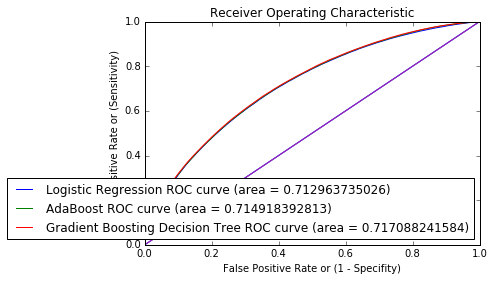

In [89]:
%%time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score, accuracy_score

from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# "Linear SVM", "RBF SVM",
names = ["Logistic Regression",  
         "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting Decision Tree", "XGBoost"]
classifiers = [
    LogisticRegression(C=1),
#     svm.SVC(kernel="linear", C=0.025),
#     svm.SVC(gamma=0.01, C=10),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=9),
    XGBClassifier()]

for name, clf in zip(names,classifiers):
    clf.fit(X_train, y_train)
    print("{:31} 测试集acc/recall: {:15}/{:15} 训练集acc/recall: {:15}/{:15}".format(name, 
        accuracy_score(y_test, clf.predict(X_test)), recall_score(y_test, clf.predict(X_test), average='macro'), 
        accuracy_score(y_train, clf.predict(X_train)), recall_score(y_train, clf.predict(X_train), average='micro')))
    
for name, clf in zip(names, classifiers):
    try: 
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        print('{}特征权值分布为: '.format(name))
        for f in range(X_train.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    except AttributeError:
        print('{} has no feture_importances_'.format(name))
    
# b: blue
# g: green
# r: red
# c: cyan
# m: magenta
# y: yellow
# k: black
# w: white
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for name, clf, color in zip(names,classifiers, colors):
    # y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    try:
        y_score = clf.decision_function(X_test)
    except AttributeError:
        print('{} has no decision_function'.format(name))
        continue

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=None)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='{} ROC curve (area = {})'.format(name, roc_auc))
    plt.plot([0, 1], [0, 1], color)  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [94]:
def feature_select(clf, X_train, X_test):
    
    # 评估特征
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("特征权值分布为: ")
    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    # 过滤掉权值小于threshold的特征
    model = SelectFromModel(clf, threshold=0.02, prefit=True)
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)
    print '训练集和测试集的容量以及选择的特征数为: ', X_train_new.shape, X_test_new.shape
    # 返回压缩特征之后的训练集和测试集
    return X_train_new, X_test_new

In [95]:
X_t = user_item_test.as_matrix(features)
from sklearn import preprocessing
X_t = preprocessing.scale(X_t)

In [96]:
X_compressed, X_t_compressed = feature_select(classifiers[4], X, X_t)

特征权值分布为: 
1. feature 3 (0.331854)
2. feature 8 (0.203366)
3. feature 4 (0.148786)
4. feature 10 (0.095543)
5. feature 9 (0.088117)
6. feature 11 (0.066473)
7. feature 0 (0.024473)
8. feature 5 (0.013774)
9. feature 6 (0.011050)
10. feature 2 (0.010402)
11. feature 7 (0.004146)
12. feature 1 (0.002017)
训练集和测试集的容量以及选择的特征数为:  (3120901, 7) (489929, 7)


/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [100]:
X_train_compressed, X_test_compressed, y_train, y_test = train_test_split(X_compressed, y, test_size=0.2, random_state=0)

In [102]:
for name, clf in zip(names,classifiers):
    clf.fit(X_train_compressed, y_train)
    
    print "{:31} 测试集acc: {:15} 训练集acc: {:15}".format(name, accuracy_score(clf.predict(X_test_compressed), y_test), accuracy_score(clf.predict(X_train_compressed), y_train))
    print "{:31} 测试集recall: {:15} 训练集recall: {:15}".format(name, 
        recall_score(y_test, clf.predict(X_test_compressed)), 
        recall_score(y_train, clf.predict(X_train_compressed)))

Logistic Regression             测试集acc:  0.803230152792 训练集acc:  0.803466147586
Logistic Regression             测试集recall:  0.117712676324 训练集recall:  0.116731363227
Decision Tree                   测试集acc:  0.803233356991 训练集acc:  0.803756528565
Decision Tree                   测试集recall:  0.119563927501 训练集recall:  0.119044975674
Random Forest                   测试集acc:  0.797981675187 训练集acc:  0.798446762152
Random Forest                   测试集recall: 0.00344933979953 训练集recall: 0.00336831837845
AdaBoost                        测试集acc:  0.803470467701 训练集acc:  0.803993639655
AdaBoost                        测试集recall:  0.109342489379 训练集recall:  0.108850806691
Gradient Boosting Decision Tree 测试集acc:    0.8037348141 训练集acc:  0.804428209811
Gradient Boosting Decision Tree 测试集recall:  0.101905839353 训练集recall:  0.101489673002


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost                         测试集acc:  0.803707578411 训练集acc:  0.804266798039


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost                         测试集recall: 0.0991606079066 训练集recall: 0.0985694063909


In [ ]:
%%time
param_grid = {'learning_rate': [1, 0.5, 0.1, 0.05, 0.02, 0.01],
              'max_depth': [2, 4, 6, 8],
              'min_samples_leaf': [3, 5, 9, 11, 13, 15, 17],
              'n_estimators': [10, 100, 500, 1000, 2000],
              # 'max_features': [1.0, 0.3, 0.1] ## not         possible in our example (only 1 fx)
             }

# est = GradientBoostingClassifier({'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 9})
# this may take some minutes
gs_cv = GridSearchCV(GradientBoostingClassifier(), param_grid, n_jobs=4).fit(X_train, y_train)
print(gs_cv.best_params_)


# best hyperparameter setting

# est.fit(X_train, y_train)
print(accuracy_score(y_test, gs_cv.predict(X_test)))

In [89]:
X_t = user_item_test.as_matrix(features)
from sklearn import preprocessing
X_t = preprocessing.scale(X_t)
X_t.shape

(3291332, 12)

In [90]:
y_sub = clf.predict_proba(X_t)[:,1]
submission = pd.DataFrame()
submission['user_id'] = user_item_test['user_id']
submission['photo_id'] = user_item_test['photo_id']
submission['click_probability'] = y_sub
submission['click_probability'] = submission['click_probability'].apply(lambda x: float('%.6f' % x))
submission.to_csv('sub_lr.txt', sep='\t', index=False, header=False)

In [91]:
submission['click_probability'].describe()

count    3.291332e+06
mean     2.022132e-01
std      1.253956e-01
min      0.000000e+00
25%      1.160200e-01
50%      1.669270e-01
75%      2.521780e-01
max      9.315520e-01
Name: click_probability, dtype: float64